In [1]:
import codecs
import copy
import gc
import json
import logging
import os
import pickle
import random
import time
from typing import List, Tuple, Union

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
import tensorflow as tf
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras.utils import losses_utils, tf_utils
from tensorflow.python.ops.losses import util as tf_losses_util
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import umap

In [4]:
from assessment import calc_uncertainty_regection_curve, f_beta_metrics
from uncertainty import ensemble_uncertainties_regression

In [5]:
class LossFunctionWrapper(tf.keras.losses.Loss):
    def __init__(self,
                 fn,
                 reduction=losses_utils.ReductionV2.AUTO,
                 name=None,
                 **kwargs):
        super(LossFunctionWrapper, self).__init__(reduction=reduction, name=name)
        self.fn = fn
        self._fn_kwargs = kwargs

    def call(self, y_true, y_pred):
        if tensor_util.is_tensor(y_pred) and tensor_util.is_tensor(y_true):
            y_pred, y_true = tf_losses_util.squeeze_or_expand_dimensions(y_pred, y_true)
        return self.fn(y_true, y_pred, **self._fn_kwargs)

    def get_config(self):
        config = {}
        for k, v in six.iteritems(self._fn_kwargs):
            config[k] = tf.keras.backend.eval(v) if tf_utils.is_tensor_or_variable(v) \
                else v
        base_config = super(LossFunctionWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
def npairs_loss(labels, feature_vectors):
    feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
    logits = tf.divide(
        tf.matmul(
            feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
        ),
        0.5  # temperature
    )
    return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [7]:
class NPairsLoss(LossFunctionWrapper):
    def __init__(self, reduction=losses_utils.ReductionV2.AUTO,
                 name='m_pairs_loss'):
        super(NPairsLoss, self).__init__(npairs_loss, name=name,
                                         reduction=reduction)

In [8]:
def build_preprocessor(X: np.ndarray, colnames: List[str]) -> Pipeline:
    X_ = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'scaler',
            MinMaxScaler()
        )
    ]).fit_transform(X)
    X_ = np.rint(X_ * 100000.0).astype(np.int32)
    binary_features = dict()
    categorical_features = dict()
    removed_features = []
    for col_idx in range(X.shape[1]):
        values = set(X_[:, col_idx].tolist())
        print(f'Column {col_idx} "{colnames[col_idx]}" has ' \
              f'{len(values)} unique values.')
        if len(values) > 1:
            if len(values) < 3:
                binary_features[col_idx] = np.min(X[:, col_idx])
            else:
                categorical_features[col_idx] = len(values)
        else:
            removed_features.append(col_idx)
        del values
    del X_
    all_features = set(range(X.shape[1]))
    useful_features = sorted(list(all_features - set(removed_features)))
    if len(useful_features) == 0:
        raise ValueError('Training inputs are bad. All features are removed.')
    print(f'There are {X.shape[1]} features.')
    if len(removed_features) > 0:
        print(f'These features will be removed: ' \
              f'{[colnames[col_idx] for col_idx in removed_features]}.')
    transformers = []
    if (len(categorical_features) > 0) and (len(binary_features) > 0):
        print(f'There are {len(categorical_features)} categorical ' \
              f'features and {len(binary_features)} binary features.')
    elif len(categorical_features) > 0:
        print(f'There are {len(categorical_features)} categorical features.')
    else:
        print(f'There are {len(binary_features)} binary features.')
    for col_idx in categorical_features:
        n_unique_values = categorical_features[col_idx]
        transformers.append(
            (
                colnames[col_idx],
                KBinsDiscretizer(
                    n_bins=min(max(n_unique_values // 3, 3), 256),
                    encode='ordinal',
                    strategy=('quantile' if n_unique_values > 50 else 'kmeans')
                ),
                (col_idx,)
            )
        )
    for col_idx in binary_features:
        transformers.append(
            (
                colnames[col_idx],
                Binarizer(threshold=0.0),
                (col_idx,)
            )
        )
    preprocessor = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'minmax_scaler',
            MinMaxScaler()
        ),
        (
            'composite_transformer', ColumnTransformer(
                transformers=transformers,
                sparse_threshold=0.0,
                n_jobs=1
            )
        ),
        (
            'selector',
            VarianceThreshold()
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return preprocessor.fit(X)

In [9]:
def reduce_dimensions_of_data(features: np.ndarray) -> np.ndarray:
    preprocessed_features = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=features.shape[1] // 3,
                        random_state=42))
        ]
    ).fit_transform(features)
    print('Features are preprocessed.')
    reduced_features = umap.UMAP(
        low_memory=False,
        n_jobs=-1,
        random_state=42,
        verbose=True
    ).fit_transform(preprocessed_features)
    print('Feature space is reduced.')
    del preprocessed_features
    return reduced_features

In [10]:
def show_temperature(features: np.ndarray, targets: np.ndarray,
                     title: str='', figure_id: int=0):
    if features.shape[0] != targets.shape[0]:
        err_msg = f'Features do not correspond to targets! ' \
                  f'{features.shape[0]} != {targets.shape[0]}'
        raise ValueError(err_msg)
    if len(features.shape) != 2:
        err_msg = f'Features are wrong! Expected 2-D array, got ' \
                  f'{len(features.shape)}-D one.'
        raise ValueError(err_msg)
    if features.shape[1] != 2:
        err_msg = f'Features are wrong! Expected number of ' \
                  f'columns is 2, got {features.shape[1]}.'
        raise ValueError(err_msg)
    if len(targets.shape) != 1:
        err_msg = f'Targets are wrong! Expected 1-D array, got ' \
                  f'{len(targets.shape)}-D one.'
        raise ValueError(err_msg)
    sorted_targets = sorted(targets.tolist())
    n_percentile2 = max(int(round(0.01 * len(sorted_targets))), 1)
    min_target = sorted_targets[n_percentile2]
    max_target = sorted_targets[-n_percentile2]
    del sorted_targets
    clipped_targets = np.empty(targets.shape, dtype=np.float64)
    for sample_idx in range(targets.shape[0]):
        if targets[sample_idx] < min_target:
            clipped_targets[sample_idx] = min_target
        elif targets[sample_idx] > max_target:
            clipped_targets[sample_idx] = max_target
        else:
            clipped_targets[sample_idx] = targets[sample_idx]
    temperature_colors = clipped_targets.tolist()
    temperature_norm = Normalize(vmin=np.min(temperature_colors),
                                 vmax=np.max(temperature_colors))
    fig = plt.figure(figure_id, figsize=(11, 11))
    plt.scatter(x=features[:, 0], y=features[:, 1],
                marker='o', cmap=plt.cm.get_cmap("jet"), c=temperature_colors,
                norm=temperature_norm)
    if len(title) > 0:
        plt.title(f'UMAP projections of weather data {title} (temperature)')
    else:
        plt.title(f'UMAP projections of weather data (temperature)')
    plt.colorbar()
    plt.show()

In [11]:
def filter_dataset(y: np.ndarray) -> List[int]:
    all_values = sorted(y.tolist())
    n = len(all_values)
    if n <= 10000:
        err_msg = f'y is wrong! Expected length of y is greater than 10000, ' \
                  f'but got {n}.'
        raise ValueError(err_msg)
    y001 = all_values[int(round((n - 1) * 0.001))]
    y999 = all_values[int(round((n - 1) * 0.999))]
    del all_values
    filtered_indices = list(filter(
        lambda idx: (y[idx] > y001) and (y[idx] < y999),
        range(n)
    ))
    return filtered_indices

In [12]:
def build_neural_network(input_size: int, layer_size: int, n_layers: int,
                         dropout_rate: float, scale_coeff: float,
                         nn_name: str) -> tf.keras.Model:
    feature_vector = tf.keras.layers.Input(
        shape=(input_size,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    outputs = []
    hidden_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_dropout1'
    )(feature_vector)
    for layer_idx in range(1, (2 * n_layers) // 3 + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    projection_layer = tf.keras.layers.Dense(
        units=50,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_projection'
    )(hidden_layer)
    for layer_idx in range((2 * n_layers) // 3 + 1, n_layers + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    output_layer = tf.keras.layers.Dense(
        units=2,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_output'
    )(hidden_layer)
    bayesian_layer = tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Normal(
            loc=t[..., :1],
            scale=1e-6 + tf.math.softplus((1.0 / scale_coeff) * t[..., 1:])
        ),
        name=f'{nn_name}_distribution'
    )(output_layer)
    neural_network = tf.keras.Model(
        inputs=feature_vector,
        outputs=[bayesian_layer, projection_layer],
        name=nn_name
    )
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    radam = tfa.optimizers.RectifiedAdam(learning_rate=3e-4)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    losses = {
        f'{nn_name}_distribution': negloglik,
        f'{nn_name}_projection': NPairsLoss()
    }
    loss_weights = {
        f'{nn_name}_distribution': 1.0,
        f'{nn_name}_projection': 0.5
    }
    metrics = {
        f'{nn_name}_distribution': [
            tf.keras.metrics.MeanAbsoluteError()
        ]
    }
    neural_network.compile(
        optimizer=ranger,
        loss=losses,
        loss_weights=loss_weights,
        metrics=metrics
    )
    return neural_network

In [13]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [14]:
def predict_with_single_nn(input_data: np.ndarray, model_for_prediction: tf.keras.Model,
                           batch_size: int, output_scaler: StandardScaler) \
        -> Tuple[np.ndarray, np.ndarray]:
    if len(input_data.shape) != 2:
        err_msg = f'The `input_data` argument is wrong! Expected 2-D array, ' \
                  f'got {len(input_data.shape)}-D one!'
        raise ValueError(err_msg)
    n_batches = int(np.ceil(input_data.shape[0] / float(batch_size)))
    pred_mean = []
    pred_std = []
    for batch_idx in range(n_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(input_data.shape[0], batch_start + batch_size)
        instant_predictions = model_for_prediction(input_data[batch_start:batch_end])[0]
        if not isinstance(instant_predictions, tfp.distributions.Distribution):
            err_msg = f'Minibatch {batch_idx}: predictions are wrong! ' \
                      f'Expected tfp.distributions.Distribution, ' \
                      f'got {type(instant_predictions)}.'
            raise ValueError(err_msg)
        instant_mean = instant_predictions.mean()
        instant_std = instant_predictions.stddev()
        del instant_predictions
        if not isinstance(instant_mean, np.ndarray):
            instant_mean = instant_mean.numpy()
        if not isinstance(instant_std, np.ndarray):
            instant_std = instant_std.numpy()
        instant_mean = instant_mean.astype(np.float64).flatten()
        instant_std = instant_std.astype(np.float64).flatten()
        pred_mean.append(instant_mean)
        pred_std.append(instant_std)
        del instant_mean, instant_std
    pred_mean = np.concatenate(pred_mean)
    pred_std = np.concatenate(pred_std)
    pred_mean = output_scaler.inverse_transform(
        pred_mean.reshape((input_data.shape[0], 1))
    ).flatten()
    pred_std *= output_scaler.scale_[0]
    return pred_mean, pred_std * pred_std

In [15]:
def evaluate_single_nn(pred_means: np.ndarray, pred_vars: np.ndarray,
                       true_outputs: np.ndarray) -> float:
    if len(pred_means.shape) != 1:
        err_msg = f'The `pred_means` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_means.shape)}-D one.'
        raise ValueError(err_msg)
    if len(pred_vars.shape) != 1:
        err_msg = f'The `pred_vars` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_vars.shape)}-D one.'
        raise ValueError(err_msg)
    if len(true_outputs.shape) != 1:
        err_msg = f'The `true_outputs` argument is wrong! Expected 1-D array, ' \
                  f'got {len(true_outputs.shape)}-D one.'
        raise ValueError(err_msg)
    n_test_samples = true_outputs.shape[0]
    if n_test_samples < 5:
        raise ValueError(f'Number of test samples = {n_test_samples} is too small!')
    if n_test_samples != pred_means.shape[0]:
        err_msg = f'The `pred_means` does not correspond to the `true_outputs`! ' \
                  f'{pred_means.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    if n_test_samples != pred_vars.shape[0]:
        err_msg = f'The `pred_vars` does not correspond to the `true_outputs`! ' \
                  f'{pred_vars.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    
    all_preds_ = np.empty((1, n_test_samples, 2), dtype=np.float32)
    all_preds_[0, :, 0] = pred_means
    all_preds_[0, :, 1] = pred_vars
    all_uncertainty_ = ensemble_uncertainties_regression(all_preds_)
    uncertainties = all_uncertainty_['tvar']
    del all_preds_, all_uncertainty_
    
    errors = (pred_means - true_outputs) ** 2
    rejection_mse_ = calc_uncertainty_regection_curve(errors, uncertainties)
    return np.mean(rejection_mse_)

In [16]:
def predict_by_ensemble(input_data: np.ndarray,
                        preprocessing: Pipeline,
                        ensemble: List[tf.keras.Model],
                        postprocessing: List[StandardScaler],
                        minibatch: int) -> np.ndarray:
    num_samples = input_data.shape[0]
    ensemble_size = len(postprocessing)
    if ensemble_size != len(ensemble):
        err_msg = f'Ensemble of preprocessors does not correspond to ' \
                  f'ensemble of models! {ensemble_size} != {len(ensemble)}'
        raise ValueError(err_msg)
    predictions_of_ensemble = np.empty((ensemble_size, num_samples, 2),
                                       dtype=np.float64)
    X = preprocessing.transform(input_data).astype(np.float32)
    for model_idx, (cur_model, post_) in enumerate(zip(ensemble, postprocessing)):
        y_mean, y_var = predict_with_single_nn(
            input_data=X,
            model_for_prediction=cur_model,
            output_scaler=post_,
            batch_size=minibatch
        )
        predictions_of_ensemble[model_idx, :, 0] = y_mean
        predictions_of_ensemble[model_idx, :, 1] = y_var
    return predictions_of_ensemble

In [17]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
data_dir = os.path.join('data', 'yandex-shifts', 'weather')
print(f'{data_dir} {os.path.isdir(data_dir)}')

data/yandex-shifts/weather True


In [19]:
model_dir = os.path.join('models', 'yandex-shifts', 'weather')
print(f'{model_dir} {os.path.isdir(model_dir)}')

models/yandex-shifts/weather True


In [20]:
traindata_name = os.path.join(data_dir, 'train.csv')
print(f'{traindata_name} {os.path.isfile(traindata_name)}')

data/yandex-shifts/weather/train.csv True


In [21]:
dev_in_name = os.path.join(data_dir, 'dev_in.csv')
print(f'{dev_in_name} {os.path.isfile(dev_in_name)}')

data/yandex-shifts/weather/dev_in.csv True


In [22]:
dev_out_name = os.path.join(data_dir, 'dev_out.csv')
print(f'{dev_out_name} {os.path.isfile(dev_out_name)}')

data/yandex-shifts/weather/dev_out.csv True


In [23]:
eval_name = os.path.join(data_dir, 'eval.csv')
print(f'{eval_name} {os.path.isfile(eval_name)}')

data/yandex-shifts/weather/eval.csv True


In [24]:
df_train = pd.read_csv(traindata_name)
print(f'Row number is {df_train.shape[0]}.')
print(f'Column number is {df_train.shape[1]}.')

Row number is 3129592.
Column number is 129.


In [25]:
df_train.head()

fact_time  fact_latitude  fact_longitude  fact_temperature  \
0  1.543321e+09      26.968800      -99.248901               2.0   
1  1.538776e+09      29.374201     -100.927002              31.0   
2  1.552115e+09      22.149599      113.592003              17.0   
3  1.549566e+09      34.678699      -86.684799              24.0   
4  1.552910e+09      46.066667       41.966667               9.0   

   fact_cwsm_class         climate  topography_bathymetry  sun_elevation  \
0              0.0             dry                  127.0     -17.526443   
1             20.0  mild temperate                  297.0      41.531032   
2             10.0  mild temperate                   -1.0      43.916531   
3             20.0  mild temperate                  193.0      40.240955   
4             20.0             dry                   90.0      30.394660   

   climate_temperature  climate_pressure  ...  cmc_0_1_66_0_grad  \
0            14.613571        754.263405  ...                0.0   
1            26.992143        733.117168  ...                0.0   
2            18.842143        761.571076  ...                0.0   
3             8.303571        747.524910  ...                0.0   
4             6.451429        753.168113  ...                0.0   

   cmc_0_1_66_0_next  cmc_0_1_67_0_grad  cmc_0_1_67_0_next  cmc_0_1_68_0_grad  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   cmc_0_1_68_0_next  gfs_2m_dewpoint_grad  gfs_2m_dewpoint_next  \
0                0.0             -2.600006             -2.750006   
1                0.0             -0.600006             17.950006   
2                0.0             -0.233978             21.450006   
3                0.0              0.059448             16.150018   
4                0.0              0.400024              3.150018   

   gfs_total_clouds_cover_low_grad  gfs_total_clouds_cover_low_next  
0                              0.0                              0.0  
1                            -12.0                             11.0  
2                              1.0                              8.0  
3                            -58.0                             41.0  
4                             18.0                             92.0  

[5 rows x 129 columns]

In [26]:
X_train = df_train.iloc[:, 6:].to_numpy().astype(np.float64)
y_train = df_train['fact_temperature'].to_numpy().astype(np.float64)

In [27]:
print(f'X_train: dtype = {X_train.dtype}, shape = {X_train.shape}')
print(f'y_train: dtype = {y_train.dtype}, shape = {y_train.shape}')

X_train: dtype = float64, shape = (3129592, 123)
y_train: dtype = float64, shape = (3129592,)


In [28]:
common_preprocessor = build_preprocessor(X_train, df_train.columns[6:])

Column 0 "topography_bathymetry" has 1572 unique values.
Column 1 "sun_elevation" has 97164 unique values.
Column 2 "climate_temperature" has 71263 unique values.
Column 3 "climate_pressure" has 61129 unique values.
Column 4 "cmc_0_0_0_1000" has 20896 unique values.
Column 5 "cmc_0_0_0_2_grad" has 70861 unique values.
Column 6 "cmc_0_0_0_2_interpolated" has 22732 unique values.
Column 7 "cmc_0_0_0_2_next" has 22708 unique values.
Column 8 "cmc_0_0_0_2" has 22751 unique values.
Column 9 "cmc_0_0_0_500" has 15603 unique values.
Column 10 "cmc_0_0_0_700" has 16122 unique values.
Column 11 "cmc_0_0_0_850" has 19235 unique values.
Column 12 "cmc_0_0_0_925" has 20172 unique values.
Column 13 "cmc_0_0_6_2" has 20279 unique values.
Column 14 "cmc_0_0_7_1000" has 248 unique values.
Column 15 "cmc_0_0_7_2" has 252 unique values.
Column 16 "cmc_0_0_7_500" has 94038 unique values.
Column 17 "cmc_0_0_7_700" has 249 unique values.
Column 18 "cmc_0_0_7_850" has 249 unique values.
Column 19 "cmc_0_0_7

/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins w

/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/data/ibondarenko/anaconda3/envs/env_for_tf22/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins w

In [29]:
print(common_preprocessor)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-1.0, strategy='constant')),
                ('minmax_scaler', MinMaxScaler()),
                ('composite_transformer',
                 ColumnTransformer(n_jobs=1, sparse_threshold=0.0,
                                   transformers=[('topography_bathymetry',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=256),
                                                  (0,)),
                                                 ('sun_elevation',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=256),
                                                  (1,)),
                                                 ('cli...
                                                  KBinsDiscretizer(encode='ordinal',
            

In [30]:
X_train = common_preprocessor.transform(X_train)
num_features = X_train.shape[1]

In [31]:
correct_values = all(np.isfinite(X_train).ravel())
if not correct_values:
    raise ValueError('Some values of input values are not correct (NaNs or infinite)!')

In [32]:
print(f'Maximal value of input matrix is {np.max(X_train)}.')
print(f'Minimal value of input matrix is {np.min(X_train)}.')

Maximal value of input matrix is 382.41506714996007.
Minimal value of input matrix is -133.47699895017269.


In [33]:
all_indices = list(range(X_train.shape[0]))
random.shuffle(all_indices)
X_train = X_train[all_indices]
y_train = y_train[all_indices]
del all_indices
gc.collect()

111

In [34]:
indices_for_projections = random.sample(
    population=list(range(X_train.shape[0])),
    k=100000
)
X_train_prj = reduce_dimensions_of_data(X_train[indices_for_projections])

Features are preprocessed.
UMAP(dens_frac=0.0, dens_lambda=0.0, low_memory=False, random_state=42,
     verbose=True)
Construct fuzzy simplicial set
Fri Nov  5 21:36:39 2021 Finding Nearest Neighbors
Fri Nov  5 21:36:39 2021 Building RP forest with 21 trees
Fri Nov  5 21:36:40 2021 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	 10  /  17
	Stopping threshold met -- exiting after 10 iterations
Fri Nov  5 21:37:07 2021 Finished Nearest Neighbor Search
Fri Nov  5 21:37:09 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Nov  5 21:39:03 2021 Finished embedding
Feature space is reduced.


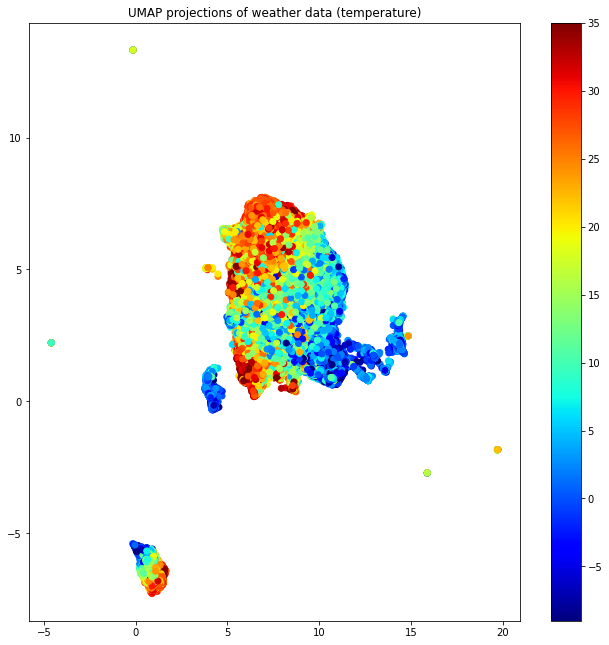

In [35]:
show_temperature(X_train_prj, y_train[indices_for_projections],
                 figure_id=0)

In [36]:
gc.collect()

43523

In [37]:
all_temperatures = sorted(y_train.tolist())
min_temperature = all_temperatures[0]
max_temperature = all_temperatures[-1]
n_samples_in_trainset = len(all_temperatures)
temperature_001 = all_temperatures[int(round(0.001 * n_samples_in_trainset))]
temperature_999 = all_temperatures[int(round(0.999 * n_samples_in_trainset))]
print(f'Minimal temperature is {min_temperature}.')
print(f'Maximal temperature is {max_temperature}.')
print(f'0.1% of temperature is {temperature_001}.')
print(f'99.9% of temperature is {temperature_999}.')
max_temperature = int(np.ceil(temperature_999))
min_temperature = int(np.floor(temperature_001))
n_classes = max_temperature - min_temperature + 1
dict_of_classes = dict()
for class_idx in range(n_classes):
    dict_of_classes[min_temperature + class_idx] = class_idx
print(f'Number of temperature classes is {n_classes}.')
print('They are:')
for temperature_val in dict_of_classes:
    class_idx = dict_of_classes[temperature_val]
    print('  Class {0:>2}: temperature = {1:4.1f}'.format(class_idx, temperature_val))
y_train_class = np.empty(y_train.shape, dtype=np.int32)
for sample_idx in range(y_train.shape[0]):
    temperature_val = int(round(y_train[sample_idx]))
    if temperature_val in dict_of_classes:
        class_idx = dict_of_classes[temperature_val]
    else:
        if temperature_val < min_temperature:
            class_idx = 0
        else:
            class_idx = n_classes - 1
    y_train_class[sample_idx] = class_idx

Minimal temperature is -46.0.
Maximal temperature is 64.0.
0.1% of temperature is -23.0.
99.9% of temperature is 40.0.
Number of temperature classes is 64.
They are:
  Class  0: temperature = -23.0
  Class  1: temperature = -22.0
  Class  2: temperature = -21.0
  Class  3: temperature = -20.0
  Class  4: temperature = -19.0
  Class  5: temperature = -18.0
  Class  6: temperature = -17.0
  Class  7: temperature = -16.0
  Class  8: temperature = -15.0
  Class  9: temperature = -14.0
  Class 10: temperature = -13.0
  Class 11: temperature = -12.0
  Class 12: temperature = -11.0
  Class 13: temperature = -10.0
  Class 14: temperature = -9.0
  Class 15: temperature = -8.0
  Class 16: temperature = -7.0
  Class 17: temperature = -6.0
  Class 18: temperature = -5.0
  Class 19: temperature = -4.0
  Class 20: temperature = -3.0
  Class 21: temperature = -2.0
  Class 22: temperature = -1.0
  Class 23: temperature =  0.0
  Class 24: temperature =  1.0
  Class 25: temperature =  2.0
  Class 26: te

In [38]:
print(f'X_train: dtype = {X_train.dtype}, shape = {X_train.shape}')
print(f'y_train: dtype = {y_train.dtype}, shape = {y_train.shape}')

X_train: dtype = float64, shape = (3129592, 123)
y_train: dtype = float64, shape = (3129592,)


In [39]:
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
splitter = skf.split(X_train, y_train_class)
splits = [(train_index, test_index) for train_index, test_index in splitter]
del splitter, skf

In [40]:
postprocessing_scalers = []
deep_ensemble = []
BATCH_SIZE = 4096
MAX_EPOCHS = 1000
PATIENCE = 15
new_figure_id = 5
BEST_LAYER_SIZE = 512
best_hyperparams = (18, 3e-4)

In [41]:
gc.collect()
tf.keras.backend.clear_session()

 Self-Normalizing Network 1 for weather prediction


Model: "weather_snn_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_1_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_1_dropout1 (AlphaDr (None, 123)          0           weather_snn_1_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_1_dense1 (Dense)    (None, 512)          63488       weather_snn_1_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_1_dropout2 (AlphaDr (None, 512)          0           weather_snn_1_dense1[0][0]       
_________________________________

Epoch 1/1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
725/725 [==============================] - 35s 48ms/step - loss: 3.8823 - weather_snn_1_distribution_loss: 0.1383 - weather_snn_1_projection_loss: 7.4881 - weather_snn_1_distribution_mean_absolute_error: 0.3363 - val_loss: 3.6341 - val_weather_snn_1_distribution_loss: -0.0367 - val_weather_snn_1_projection_loss: 7.3417 - val_weather_snn_1_distribution_mean_absolute_error: 0.2772
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5782 - weather_snn_1_distribution_loss: -0.0836 - weather_snn_1_projection_loss: 7.3237 - weather_snn_1_distribution_mean_absolute_error: 0.2583 - val_loss: 3.4076 - val_weather_snn_1_distribution_loss: -0.2390 - val_weather_snn_1_projection_loss: 7.2932 - val_weather_snn_1_distribution_mean_absolute_error: 0.2260
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4843 - weather_snn_1_distribution_loss: -0.1614 

Epoch 21/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1256 - weather_snn_1_distribution_loss: -0.4685 - weather_snn_1_projection_loss: 7.1881 - weather_snn_1_distribution_mean_absolute_error: 0.1788 - val_loss: 3.1704 - val_weather_snn_1_distribution_loss: -0.4251 - val_weather_snn_1_projection_loss: 7.1910 - val_weather_snn_1_distribution_mean_absolute_error: 0.1752
Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1138 - weather_snn_1_distribution_loss: -0.4790 - weather_snn_1_projection_loss: 7.1857 - weather_snn_1_distribution_mean_absolute_error: 0.1772 - val_loss: 3.1802 - val_weather_snn_1_distribution_loss: -0.4129 - val_weather_snn_1_projection_loss: 7.1862 - val_weather_snn_1_distribution_mean_absolute_error: 0.1807
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0986 - weather_snn_1_distribution_loss: -0.4930 - weather_snn_1_projection_loss: 7.1832 - weather_snn_1_distribution_mean_abs

Epoch 42/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8987 - weather_snn_1_distribution_loss: -0.6745 - weather_snn_1_projection_loss: 7.1464 - weather_snn_1_distribution_mean_absolute_error: 0.1477 - val_loss: 3.0911 - val_weather_snn_1_distribution_loss: -0.4923 - val_weather_snn_1_projection_loss: 7.1667 - val_weather_snn_1_distribution_mean_absolute_error: 0.1616
Epoch 43/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.8869 - weather_snn_1_distribution_loss: -0.6853 - weather_snn_1_projection_loss: 7.1444 - weather_snn_1_distribution_mean_absolute_error: 0.1462 - val_loss: 3.1749 - val_weather_snn_1_distribution_loss: -0.4106 - val_weather_snn_1_projection_loss: 7.1709 - val_weather_snn_1_distribution_mean_absolute_error: 0.1592
Epoch 44/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8788 - weather_snn_1_distribution_loss: -0.6930 - weather_snn_1_projection_loss: 7.1435 - weather_snn_1_distribution_mean_abs

Epoch 63/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7292 - weather_snn_1_distribution_loss: -0.8323 - weather_snn_1_projection_loss: 7.1231 - weather_snn_1_distribution_mean_absolute_error: 0.1273 - val_loss: 3.2439 - val_weather_snn_1_distribution_loss: -0.3380 - val_weather_snn_1_projection_loss: 7.1639 - val_weather_snn_1_distribution_mean_absolute_error: 0.1475
Epoch 64/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7175 - weather_snn_1_distribution_loss: -0.8432 - weather_snn_1_projection_loss: 7.1215 - weather_snn_1_distribution_mean_absolute_error: 0.1260 - val_loss: 3.2432 - val_weather_snn_1_distribution_loss: -0.3391 - val_weather_snn_1_projection_loss: 7.1647 - val_weather_snn_1_distribution_mean_absolute_error: 0.1487
Epoch 65/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7102 - weather_snn_1_distribution_loss: -0.8501 - weather_snn_1_projection_loss: 7.1206 - weather_snn_1_distribution_mean_abs

Epoch 84/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5970 - weather_snn_1_distribution_loss: -0.9563 - weather_snn_1_projection_loss: 7.1065 - weather_snn_1_distribution_mean_absolute_error: 0.1129 - val_loss: 3.3430 - val_weather_snn_1_distribution_loss: -0.2371 - val_weather_snn_1_projection_loss: 7.1602 - val_weather_snn_1_distribution_mean_absolute_error: 0.1445
Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5929 - weather_snn_1_distribution_loss: -0.9602 - weather_snn_1_projection_loss: 7.1061 - weather_snn_1_distribution_mean_absolute_error: 0.1126 - val_loss: 3.3923 - val_weather_snn_1_distribution_loss: -0.1895 - val_weather_snn_1_projection_loss: 7.1637 - val_weather_snn_1_distribution_mean_absolute_error: 0.1446
Epoch 86/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5881 - weather_snn_1_distribution_loss: -0.9645 - weather_snn_1_projection_loss: 7.1053 - weather_snn_1_distribution_mean_abs

Epoch 105/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5114 - weather_snn_1_distribution_loss: -1.0361 - weather_snn_1_projection_loss: 7.0951 - weather_snn_1_distribution_mean_absolute_error: 0.1047 - val_loss: 3.6023 - val_weather_snn_1_distribution_loss: 0.0209 - val_weather_snn_1_projection_loss: 7.1629 - val_weather_snn_1_distribution_mean_absolute_error: 0.1377
Epoch 106/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5062 - weather_snn_1_distribution_loss: -1.0413 - weather_snn_1_projection_loss: 7.0948 - weather_snn_1_distribution_mean_absolute_error: 0.1041 - val_loss: 3.5794 - val_weather_snn_1_distribution_loss: -0.0015 - val_weather_snn_1_projection_loss: 7.1619 - val_weather_snn_1_distribution_mean_absolute_error: 0.1388
Epoch 107/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.4988 - weather_snn_1_distribution_loss: -1.0480 - weather_snn_1_projection_loss: 7.0936 - weather_snn_1_distribution_mean_a

Epoch 126/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.4451 - weather_snn_1_distribution_loss: -1.0985 - weather_snn_1_projection_loss: 7.0873 - weather_snn_1_distribution_mean_absolute_error: 0.0983 - val_loss: 3.6672 - val_weather_snn_1_distribution_loss: 0.0870 - val_weather_snn_1_projection_loss: 7.1605 - val_weather_snn_1_distribution_mean_absolute_error: 0.1371
Epoch 127/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4374 - weather_snn_1_distribution_loss: -1.1058 - weather_snn_1_projection_loss: 7.0863 - weather_snn_1_distribution_mean_absolute_error: 0.0976 - val_loss: 3.7800 - val_weather_snn_1_distribution_loss: 0.1977 - val_weather_snn_1_projection_loss: 7.1646 - val_weather_snn_1_distribution_mean_absolute_error: 0.1363
Epoch 128/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.4401 - weather_snn_1_distribution_loss: -1.1030 - weather_snn_1_projection_loss: 7.0863 - weather_snn_1_distribution_mean_ab

Epoch 147/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3925 - weather_snn_1_distribution_loss: -1.1478 - weather_snn_1_projection_loss: 7.0804 - weather_snn_1_distribution_mean_absolute_error: 0.0936 - val_loss: 3.8203 - val_weather_snn_1_distribution_loss: 0.2391 - val_weather_snn_1_projection_loss: 7.1624 - val_weather_snn_1_distribution_mean_absolute_error: 0.1352
Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3983 - weather_snn_1_distribution_loss: -1.1421 - weather_snn_1_projection_loss: 7.0808 - weather_snn_1_distribution_mean_absolute_error: 0.0941 - val_loss: 3.8195 - val_weather_snn_1_distribution_loss: 0.2381 - val_weather_snn_1_projection_loss: 7.1629 - val_weather_snn_1_distribution_mean_absolute_error: 0.1352
Epoch 149/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3935 - weather_snn_1_distribution_loss: -1.1464 - weather_snn_1_projection_loss: 7.0799 - weather_snn_1_distribution_mean_ab

Epoch 168/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3511 - weather_snn_1_distribution_loss: -1.1864 - weather_snn_1_projection_loss: 7.0750 - weather_snn_1_distribution_mean_absolute_error: 0.0900 - val_loss: 3.9066 - val_weather_snn_1_distribution_loss: 0.3260 - val_weather_snn_1_projection_loss: 7.1613 - val_weather_snn_1_distribution_mean_absolute_error: 0.1333
Epoch 169/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.3477 - weather_snn_1_distribution_loss: -1.1896 - weather_snn_1_projection_loss: 7.0747 - weather_snn_1_distribution_mean_absolute_error: 0.0897 - val_loss: 3.9414 - val_weather_snn_1_distribution_loss: 0.3593 - val_weather_snn_1_projection_loss: 7.1643 - val_weather_snn_1_distribution_mean_absolute_error: 0.1352
Epoch 170/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.3554 - weather_snn_1_distribution_loss: -1.1823 - weather_snn_1_projection_loss: 7.0752 - weather_snn_1_distribution_mean_ab

Epoch 189/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3277 - weather_snn_1_distribution_loss: -1.2079 - weather_snn_1_projection_loss: 7.0712 - weather_snn_1_distribution_mean_absolute_error: 0.0881 - val_loss: 3.9166 - val_weather_snn_1_distribution_loss: 0.3347 - val_weather_snn_1_projection_loss: 7.1640 - val_weather_snn_1_distribution_mean_absolute_error: 0.1348
Epoch 190/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3203 - weather_snn_1_distribution_loss: -1.2150 - weather_snn_1_projection_loss: 7.0706 - weather_snn_1_distribution_mean_absolute_error: 0.0875 - val_loss: 4.0554 - val_weather_snn_1_distribution_loss: 0.4733 - val_weather_snn_1_projection_loss: 7.1642 - val_weather_snn_1_distribution_mean_absolute_error: 0.1333
Epoch 191/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3253 - weather_snn_1_distribution_loss: -1.2100 - weather_snn_1_projection_loss: 7.0706 - weather_snn_1_distribution_mean_ab

Epoch 210/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2908 - weather_snn_1_distribution_loss: -1.2425 - weather_snn_1_projection_loss: 7.0666 - weather_snn_1_distribution_mean_absolute_error: 0.0851 - val_loss: 4.0796 - val_weather_snn_1_distribution_loss: 0.4987 - val_weather_snn_1_projection_loss: 7.1618 - val_weather_snn_1_distribution_mean_absolute_error: 0.1312
Epoch 211/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2910 - weather_snn_1_distribution_loss: -1.2422 - weather_snn_1_projection_loss: 7.0663 - weather_snn_1_distribution_mean_absolute_error: 0.0851 - val_loss: 4.1264 - val_weather_snn_1_distribution_loss: 0.5439 - val_weather_snn_1_projection_loss: 7.1651 - val_weather_snn_1_distribution_mean_absolute_error: 0.1328
Epoch 212/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2874 - weather_snn_1_distribution_loss: -1.2454 - weather_snn_1_projection_loss: 7.0657 - weather_snn_1_distribution_mean_ab

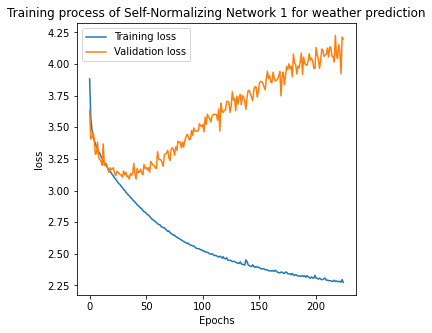

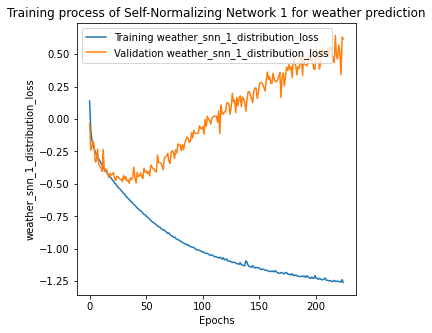

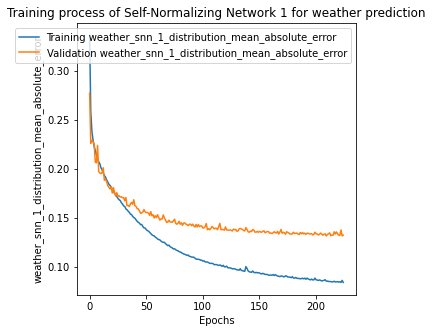


Test quality:
  mean absolute error   = 1.1948221102059644
  mean squared error    = 2.763012533893964
  median absolute error = 0.8783051523994292
  r2 score              = 0.9740325747433195
  R-AUC MSE             = 0.898769083381477
 Self-Normalizing Network 2 for weather prediction

Model: "weather_snn_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_2_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_2_dropout1 (AlphaDr (None, 123)          0           weather_snn_2_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_2_dense1 (Dense)    (None, 512)          63488       weather_snn_2_dropout1[0][0]

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.9279 - weather_snn_2_distribution_loss: 0.1755 - weather_snn_2_projection_loss: 7.5048 - weather_snn_2_distribution_mean_absolute_error: 0.3516 - val_loss: 3.5353 - val_weather_snn_2_distribution_loss: -0.1428 - val_weather_snn_2_projection_loss: 7.3562 - val_weather_snn_2_distribution_mean_absolute_error: 0.2461
Epoch 2/1000
725/725 [==============================] - 35s 49ms/step - loss: 3.5689 - weather_snn_2_distribution_loss: -0.0948 - weather_snn_2_projection_loss: 7.3272 - weather_snn_2_distribution_mean_absolute_error: 0.2540 - val_loss: 3.4531 - val_weather_snn_2_distribution_loss: -0.1949 - val_weather_snn_2_projection_loss: 7.2960 - val_weather_snn_2_distribution_mean_absolute_error: 0.2307
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4833 - weather_snn_2_distribution_loss: -0.1637 - weather_snn_2_projection_loss: 7.2940 - weather_snn_2_distribution_mean_absolut

Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1143 - weather_snn_2_distribution_loss: -0.4791 - weather_snn_2_projection_loss: 7.1867 - weather_snn_2_distribution_mean_absolute_error: 0.1771 - val_loss: 3.2001 - val_weather_snn_2_distribution_loss: -0.3938 - val_weather_snn_2_projection_loss: 7.1877 - val_weather_snn_2_distribution_mean_absolute_error: 0.1822
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1073 - weather_snn_2_distribution_loss: -0.4853 - weather_snn_2_projection_loss: 7.1851 - weather_snn_2_distribution_mean_absolute_error: 0.1760 - val_loss: 3.1396 - val_weather_snn_2_distribution_loss: -0.4538 - val_weather_snn_2_projection_loss: 7.1868 - val_weather_snn_2_distribution_mean_absolute_error: 0.1781
Epoch 24/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0922 - weather_snn_2_distribution_loss: -0.4989 - weather_snn_2_projection_loss: 7.1823 - weather_snn_2_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.8930 - weather_snn_2_distribution_loss: -0.6800 - weather_snn_2_projection_loss: 7.1459 - weather_snn_2_distribution_mean_absolute_error: 0.1468 - val_loss: 3.1488 - val_weather_snn_2_distribution_loss: -0.4359 - val_weather_snn_2_projection_loss: 7.1694 - val_weather_snn_2_distribution_mean_absolute_error: 0.1600
Epoch 44/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.8842 - weather_snn_2_distribution_loss: -0.6881 - weather_snn_2_projection_loss: 7.1447 - weather_snn_2_distribution_mean_absolute_error: 0.1458 - val_loss: 3.1500 - val_weather_snn_2_distribution_loss: -0.4351 - val_weather_snn_2_projection_loss: 7.1702 - val_weather_snn_2_distribution_mean_absolute_error: 0.1581
Epoch 45/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.8765 - weather_snn_2_distribution_loss: -0.6951 - weather_snn_2_projection_loss: 7.1431 - weather_snn_2_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7236 - weather_snn_2_distribution_loss: -0.8371 - weather_snn_2_projection_loss: 7.1214 - weather_snn_2_distribution_mean_absolute_error: 0.1265 - val_loss: 3.2618 - val_weather_snn_2_distribution_loss: -0.3200 - val_weather_snn_2_projection_loss: 7.1636 - val_weather_snn_2_distribution_mean_absolute_error: 0.1500
Epoch 65/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7167 - weather_snn_2_distribution_loss: -0.8435 - weather_snn_2_projection_loss: 7.1203 - weather_snn_2_distribution_mean_absolute_error: 0.1258 - val_loss: 3.2485 - val_weather_snn_2_distribution_loss: -0.3337 - val_weather_snn_2_projection_loss: 7.1644 - val_weather_snn_2_distribution_mean_absolute_error: 0.1494
Epoch 66/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7077 - weather_snn_2_distribution_loss: -0.8518 - weather_snn_2_projection_loss: 7.1191 - weather_snn_2_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5992 - weather_snn_2_distribution_loss: -0.9539 - weather_snn_2_projection_loss: 7.1062 - weather_snn_2_distribution_mean_absolute_error: 0.1130 - val_loss: 3.4616 - val_weather_snn_2_distribution_loss: -0.1206 - val_weather_snn_2_projection_loss: 7.1645 - val_weather_snn_2_distribution_mean_absolute_error: 0.1436
Epoch 86/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5907 - weather_snn_2_distribution_loss: -0.9620 - weather_snn_2_projection_loss: 7.1052 - weather_snn_2_distribution_mean_absolute_error: 0.1121 - val_loss: 3.4419 - val_weather_snn_2_distribution_loss: -0.1395 - val_weather_snn_2_projection_loss: 7.1627 - val_weather_snn_2_distribution_mean_absolute_error: 0.1424
Epoch 87/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6039 - weather_snn_2_distribution_loss: -0.9492 - weather_snn_2_projection_loss: 7.1062 - weather_snn_2_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5080 - weather_snn_2_distribution_loss: -1.0400 - weather_snn_2_projection_loss: 7.0961 - weather_snn_2_distribution_mean_absolute_error: 0.1039 - val_loss: 3.5433 - val_weather_snn_2_distribution_loss: -0.0381 - val_weather_snn_2_projection_loss: 7.1628 - val_weather_snn_2_distribution_mean_absolute_error: 0.1424
Epoch 107/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5024 - weather_snn_2_distribution_loss: -1.0451 - weather_snn_2_projection_loss: 7.0950 - weather_snn_2_distribution_mean_absolute_error: 0.1034 - val_loss: 3.5490 - val_weather_snn_2_distribution_loss: -0.0318 - val_weather_snn_2_projection_loss: 7.1617 - val_weather_snn_2_distribution_mean_absolute_error: 0.1396
Epoch 108/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5038 - weather_snn_2_distribution_loss: -1.0439 - weather_snn_2_projection_loss: 7.0954 - weather_snn_2_distribution_mean_

Epoch 127/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4485 - weather_snn_2_distribution_loss: -1.0959 - weather_snn_2_projection_loss: 7.0887 - weather_snn_2_distribution_mean_absolute_error: 0.0984 - val_loss: 3.7712 - val_weather_snn_2_distribution_loss: 0.1898 - val_weather_snn_2_projection_loss: 7.1629 - val_weather_snn_2_distribution_mean_absolute_error: 0.1375
Epoch 128/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.4412 - weather_snn_2_distribution_loss: -1.1027 - weather_snn_2_projection_loss: 7.0878 - weather_snn_2_distribution_mean_absolute_error: 0.0976 - val_loss: 3.6406 - val_weather_snn_2_distribution_loss: 0.0590 - val_weather_snn_2_projection_loss: 7.1632 - val_weather_snn_2_distribution_mean_absolute_error: 0.1397
Epoch 129/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4333 - weather_snn_2_distribution_loss: -1.1102 - weather_snn_2_projection_loss: 7.0869 - weather_snn_2_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3921 - weather_snn_2_distribution_loss: -1.1489 - weather_snn_2_projection_loss: 7.0819 - weather_snn_2_distribution_mean_absolute_error: 0.0932 - val_loss: 3.7770 - val_weather_snn_2_distribution_loss: 0.1959 - val_weather_snn_2_projection_loss: 7.1622 - val_weather_snn_2_distribution_mean_absolute_error: 0.1363
Epoch 149/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.3932 - weather_snn_2_distribution_loss: -1.1478 - weather_snn_2_projection_loss: 7.0820 - weather_snn_2_distribution_mean_absolute_error: 0.0934 - val_loss: 3.8025 - val_weather_snn_2_distribution_loss: 0.2215 - val_weather_snn_2_projection_loss: 7.1619 - val_weather_snn_2_distribution_mean_absolute_error: 0.1369
Epoch 150/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3942 - weather_snn_2_distribution_loss: -1.1467 - weather_snn_2_projection_loss: 7.0818 - weather_snn_2_distribution_mean_ab

Epoch 169/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3584 - weather_snn_2_distribution_loss: -1.1804 - weather_snn_2_projection_loss: 7.0776 - weather_snn_2_distribution_mean_absolute_error: 0.0905 - val_loss: 4.0275 - val_weather_snn_2_distribution_loss: 0.4448 - val_weather_snn_2_projection_loss: 7.1653 - val_weather_snn_2_distribution_mean_absolute_error: 0.1346
Epoch 170/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3538 - weather_snn_2_distribution_loss: -1.1848 - weather_snn_2_projection_loss: 7.0773 - weather_snn_2_distribution_mean_absolute_error: 0.0900 - val_loss: 4.0056 - val_weather_snn_2_distribution_loss: 0.4235 - val_weather_snn_2_projection_loss: 7.1643 - val_weather_snn_2_distribution_mean_absolute_error: 0.1348
Epoch 171/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3489 - weather_snn_2_distribution_loss: -1.1895 - weather_snn_2_projection_loss: 7.0767 - weather_snn_2_distribution_mean_ab

Epoch 190/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.3301 - weather_snn_2_distribution_loss: -1.2064 - weather_snn_2_projection_loss: 7.0730 - weather_snn_2_distribution_mean_absolute_error: 0.0881 - val_loss: 4.0087 - val_weather_snn_2_distribution_loss: 0.4264 - val_weather_snn_2_projection_loss: 7.1646 - val_weather_snn_2_distribution_mean_absolute_error: 0.1337
Epoch 191/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3281 - weather_snn_2_distribution_loss: -1.2086 - weather_snn_2_projection_loss: 7.0733 - weather_snn_2_distribution_mean_absolute_error: 0.0880 - val_loss: 3.9987 - val_weather_snn_2_distribution_loss: 0.4175 - val_weather_snn_2_projection_loss: 7.1624 - val_weather_snn_2_distribution_mean_absolute_error: 0.1329
Epoch 192/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3157 - weather_snn_2_distribution_loss: -1.2203 - weather_snn_2_projection_loss: 7.0721 - weather_snn_2_distribution_mean_ab

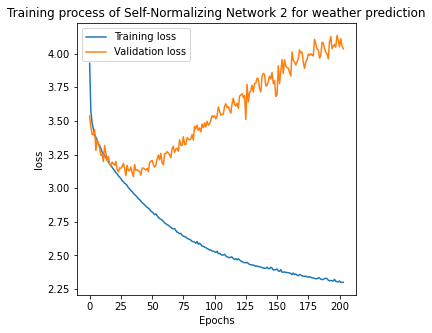

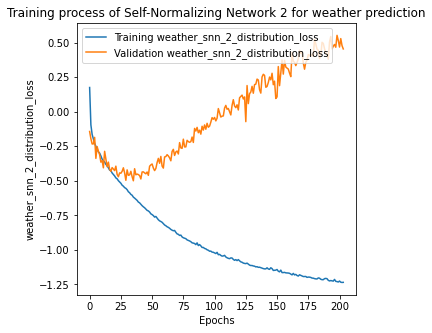

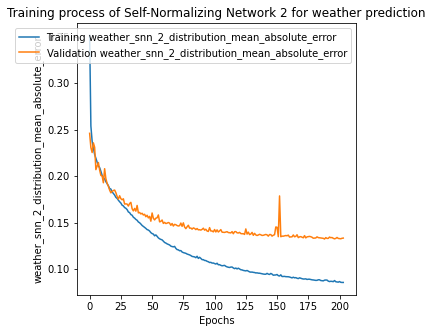


Test quality:
  mean absolute error   = 1.1977172557987208
  mean squared error    = 2.802091105973243
  median absolute error = 0.8800316561797601
  r2 score              = 0.9736354425148269
  R-AUC MSE             = 0.9226972317944193
 Self-Normalizing Network 3 for weather prediction

Model: "weather_snn_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_3_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_3_dropout1 (AlphaDr (None, 123)          0           weather_snn_3_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_3_dense1 (Dense)    (None, 512)          63488       weather_snn_3_dropout1[0][0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8800 - weather_snn_3_distribution_loss: 0.1367 - weather_snn_3_projection_loss: 7.4866 - weather_snn_3_distribution_mean_absolute_error: 0.3373 - val_loss: 3.5795 - val_weather_snn_3_distribution_loss: -0.0894 - val_weather_snn_3_projection_loss: 7.3378 - val_weather_snn_3_distribution_mean_absolute_error: 0.2501
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5683 - weather_snn_3_distribution_loss: -0.0939 - weather_snn_3_projection_loss: 7.3245 - weather_snn_3_distribution_mean_absolute_error: 0.2541 - val_loss: 3.4748 - val_weather_snn_3_distribution_loss: -0.1722 - val_weather_snn_3_projection_loss: 7.2940 - val_weather_snn_3_distribution_mean_absolute_error: 0.2490
Epoch 3/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.4815 - weather_snn_3_distribution_loss: -0.1652 - weather_snn_3_projection_loss: 7.2934 - weather_snn_3_distribution_mean_absolut

Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1112 - weather_snn_3_distribution_loss: -0.4819 - weather_snn_3_projection_loss: 7.1861 - weather_snn_3_distribution_mean_absolute_error: 0.1767 - val_loss: 3.1726 - val_weather_snn_3_distribution_loss: -0.4200 - val_weather_snn_3_projection_loss: 7.1853 - val_weather_snn_3_distribution_mean_absolute_error: 0.1796
Epoch 23/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.1000 - weather_snn_3_distribution_loss: -0.4918 - weather_snn_3_projection_loss: 7.1837 - weather_snn_3_distribution_mean_absolute_error: 0.1751 - val_loss: 3.1275 - val_weather_snn_3_distribution_loss: -0.4643 - val_weather_snn_3_projection_loss: 7.1834 - val_weather_snn_3_distribution_mean_absolute_error: 0.1745
Epoch 24/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0887 - weather_snn_3_distribution_loss: -0.5021 - weather_snn_3_projection_loss: 7.1817 - weather_snn_3_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.8886 - weather_snn_3_distribution_loss: -0.6846 - weather_snn_3_projection_loss: 7.1462 - weather_snn_3_distribution_mean_absolute_error: 0.1460 - val_loss: 3.1408 - val_weather_snn_3_distribution_loss: -0.4442 - val_weather_snn_3_projection_loss: 7.1700 - val_weather_snn_3_distribution_mean_absolute_error: 0.1588
Epoch 44/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8797 - weather_snn_3_distribution_loss: -0.6928 - weather_snn_3_projection_loss: 7.1449 - weather_snn_3_distribution_mean_absolute_error: 0.1449 - val_loss: 3.1423 - val_weather_snn_3_distribution_loss: -0.4425 - val_weather_snn_3_projection_loss: 7.1695 - val_weather_snn_3_distribution_mean_absolute_error: 0.1564
Epoch 45/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8710 - weather_snn_3_distribution_loss: -0.7009 - weather_snn_3_projection_loss: 7.1438 - weather_snn_3_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7202 - weather_snn_3_distribution_loss: -0.8415 - weather_snn_3_projection_loss: 7.1235 - weather_snn_3_distribution_mean_absolute_error: 0.1258 - val_loss: 3.2292 - val_weather_snn_3_distribution_loss: -0.3520 - val_weather_snn_3_projection_loss: 7.1625 - val_weather_snn_3_distribution_mean_absolute_error: 0.1466
Epoch 65/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7125 - weather_snn_3_distribution_loss: -0.8487 - weather_snn_3_projection_loss: 7.1224 - weather_snn_3_distribution_mean_absolute_error: 0.1254 - val_loss: 3.2177 - val_weather_snn_3_distribution_loss: -0.3628 - val_weather_snn_3_projection_loss: 7.1610 - val_weather_snn_3_distribution_mean_absolute_error: 0.1473
Epoch 66/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7066 - weather_snn_3_distribution_loss: -0.8541 - weather_snn_3_projection_loss: 7.1215 - weather_snn_3_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.6031 - weather_snn_3_distribution_loss: -0.9511 - weather_snn_3_projection_loss: 7.1084 - weather_snn_3_distribution_mean_absolute_error: 0.1135 - val_loss: 3.3581 - val_weather_snn_3_distribution_loss: -0.2233 - val_weather_snn_3_projection_loss: 7.1627 - val_weather_snn_3_distribution_mean_absolute_error: 0.1451
Epoch 86/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5919 - weather_snn_3_distribution_loss: -0.9614 - weather_snn_3_projection_loss: 7.1066 - weather_snn_3_distribution_mean_absolute_error: 0.1122 - val_loss: 3.3841 - val_weather_snn_3_distribution_loss: -0.1962 - val_weather_snn_3_projection_loss: 7.1606 - val_weather_snn_3_distribution_mean_absolute_error: 0.1423
Epoch 87/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.5879 - weather_snn_3_distribution_loss: -0.9652 - weather_snn_3_projection_loss: 7.1063 - weather_snn_3_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5125 - weather_snn_3_distribution_loss: -1.0360 - weather_snn_3_projection_loss: 7.0972 - weather_snn_3_distribution_mean_absolute_error: 0.1042 - val_loss: 3.5755 - val_weather_snn_3_distribution_loss: -0.0044 - val_weather_snn_3_projection_loss: 7.1598 - val_weather_snn_3_distribution_mean_absolute_error: 0.1376
Epoch 107/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5007 - weather_snn_3_distribution_loss: -1.0475 - weather_snn_3_projection_loss: 7.0964 - weather_snn_3_distribution_mean_absolute_error: 0.1031 - val_loss: 3.5765 - val_weather_snn_3_distribution_loss: -0.0029 - val_weather_snn_3_projection_loss: 7.1586 - val_weather_snn_3_distribution_mean_absolute_error: 0.1406
Epoch 108/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4989 - weather_snn_3_distribution_loss: -1.0491 - weather_snn_3_projection_loss: 7.0959 - weather_snn_3_distribution_mean_

Epoch 127/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4418 - weather_snn_3_distribution_loss: -1.1028 - weather_snn_3_projection_loss: 7.0893 - weather_snn_3_distribution_mean_absolute_error: 0.0976 - val_loss: 3.7448 - val_weather_snn_3_distribution_loss: 0.1636 - val_weather_snn_3_projection_loss: 7.1624 - val_weather_snn_3_distribution_mean_absolute_error: 0.1380
Epoch 128/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4369 - weather_snn_3_distribution_loss: -1.1076 - weather_snn_3_projection_loss: 7.0890 - weather_snn_3_distribution_mean_absolute_error: 0.0971 - val_loss: 3.6641 - val_weather_snn_3_distribution_loss: 0.0833 - val_weather_snn_3_projection_loss: 7.1616 - val_weather_snn_3_distribution_mean_absolute_error: 0.1387
Epoch 129/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4360 - weather_snn_3_distribution_loss: -1.1082 - weather_snn_3_projection_loss: 7.0884 - weather_snn_3_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3919 - weather_snn_3_distribution_loss: -1.1497 - weather_snn_3_projection_loss: 7.0833 - weather_snn_3_distribution_mean_absolute_error: 0.0931 - val_loss: 3.8166 - val_weather_snn_3_distribution_loss: 0.2366 - val_weather_snn_3_projection_loss: 7.1600 - val_weather_snn_3_distribution_mean_absolute_error: 0.1355
Epoch 149/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3957 - weather_snn_3_distribution_loss: -1.1459 - weather_snn_3_projection_loss: 7.0832 - weather_snn_3_distribution_mean_absolute_error: 0.0936 - val_loss: 3.7813 - val_weather_snn_3_distribution_loss: 0.2021 - val_weather_snn_3_projection_loss: 7.1585 - val_weather_snn_3_distribution_mean_absolute_error: 0.1353
Epoch 150/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.3873 - weather_snn_3_distribution_loss: -1.1537 - weather_snn_3_projection_loss: 7.0820 - weather_snn_3_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3499 - weather_snn_3_distribution_loss: -1.1892 - weather_snn_3_projection_loss: 7.0782 - weather_snn_3_distribution_mean_absolute_error: 0.0896 - val_loss: 3.8616 - val_weather_snn_3_distribution_loss: 0.2822 - val_weather_snn_3_projection_loss: 7.1588 - val_weather_snn_3_distribution_mean_absolute_error: 0.1333
Epoch 169/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3531 - weather_snn_3_distribution_loss: -1.1858 - weather_snn_3_projection_loss: 7.0777 - weather_snn_3_distribution_mean_absolute_error: 0.0898 - val_loss: 3.9436 - val_weather_snn_3_distribution_loss: 0.3624 - val_weather_snn_3_projection_loss: 7.1623 - val_weather_snn_3_distribution_mean_absolute_error: 0.1343
Epoch 170/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3529 - weather_snn_3_distribution_loss: -1.1859 - weather_snn_3_projection_loss: 7.0776 - weather_snn_3_distribution_mean_absolute_error: 0

Epoch 189/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3246 - weather_snn_3_distribution_loss: -1.2123 - weather_snn_3_projection_loss: 7.0738 - weather_snn_3_distribution_mean_absolute_error: 0.0876 - val_loss: 3.8988 - val_weather_snn_3_distribution_loss: 0.3177 - val_weather_snn_3_projection_loss: 7.1623 - val_weather_snn_3_distribution_mean_absolute_error: 0.1343
Epoch 190/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3318 - weather_snn_3_distribution_loss: -1.2050 - weather_snn_3_projection_loss: 7.0735 - weather_snn_3_distribution_mean_absolute_error: 0.0882 - val_loss: 3.8540 - val_weather_snn_3_distribution_loss: 0.2733 - val_weather_snn_3_projection_loss: 7.1613 - val_weather_snn_3_distribution_mean_absolute_error: 0.1339
Epoch 191/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3253 - weather_snn_3_distribution_loss: -1.2115 - weather_snn_3_projection_loss: 7.0738 - weather_snn_3_distribution_mean_ab

Epoch 210/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2975 - weather_snn_3_distribution_loss: -1.2374 - weather_snn_3_projection_loss: 7.0697 - weather_snn_3_distribution_mean_absolute_error: 0.0853 - val_loss: 4.0896 - val_weather_snn_3_distribution_loss: 0.5098 - val_weather_snn_3_projection_loss: 7.1597 - val_weather_snn_3_distribution_mean_absolute_error: 0.1318
Epoch 211/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2939 - weather_snn_3_distribution_loss: -1.2406 - weather_snn_3_projection_loss: 7.0692 - weather_snn_3_distribution_mean_absolute_error: 0.0850 - val_loss: 4.0696 - val_weather_snn_3_distribution_loss: 0.4883 - val_weather_snn_3_projection_loss: 7.1628 - val_weather_snn_3_distribution_mean_absolute_error: 0.1334
Epoch 212/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2879 - weather_snn_3_distribution_loss: -1.2465 - weather_snn_3_projection_loss: 7.0689 - weather_snn_3_distribution_mean_ab

Epoch 231/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2722 - weather_snn_3_distribution_loss: -1.2607 - weather_snn_3_projection_loss: 7.0658 - weather_snn_3_distribution_mean_absolute_error: 0.0832 - val_loss: 4.1309 - val_weather_snn_3_distribution_loss: 0.5500 - val_weather_snn_3_projection_loss: 7.1617 - val_weather_snn_3_distribution_mean_absolute_error: 0.1322
Epoch 232/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.2790 - weather_snn_3_distribution_loss: -1.2542 - weather_snn_3_projection_loss: 7.0664 - weather_snn_3_distribution_mean_absolute_error: 0.0842 - val_loss: 3.6169 - val_weather_snn_3_distribution_loss: 0.0322 - val_weather_snn_3_projection_loss: 7.1694 - val_weather_snn_3_distribution_mean_absolute_error: 0.1418
Epoch 233/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2875 - weather_snn_3_distribution_loss: -1.2457 - weather_snn_3_projection_loss: 7.0663 - weather_snn_3_distribution_mean_ab

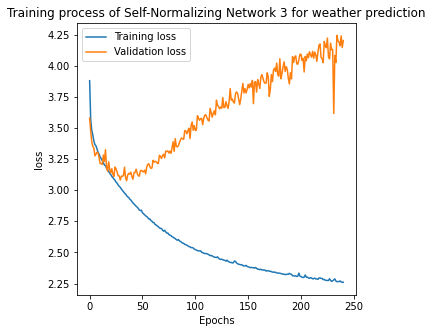

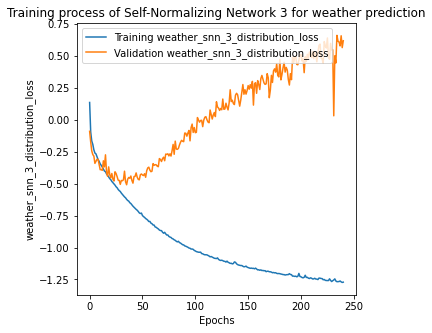

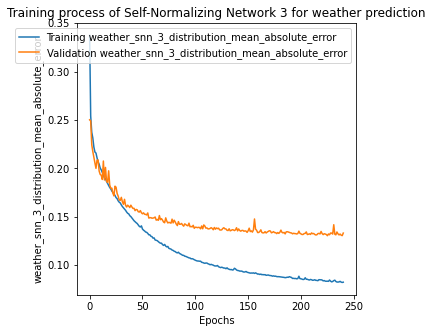


Test quality:
  mean absolute error   = 1.1976930247198982
  mean squared error    = 2.769345274699103
  median absolute error = 0.880272543224244
  r2 score              = 0.9739362985191692
  R-AUC MSE             = 0.9019836217382492
 Self-Normalizing Network 4 for weather prediction

Model: "weather_snn_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_4_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_4_dropout1 (AlphaDr (None, 123)          0           weather_snn_4_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_4_dense1 (Dense)    (None, 512)          63488       weather_snn_4_dropout1[0][0]

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8791 - weather_snn_4_distribution_loss: 0.1391 - weather_snn_4_projection_loss: 7.4800 - weather_snn_4_distribution_mean_absolute_error: 0.3366 - val_loss: 3.5346 - val_weather_snn_4_distribution_loss: -0.1302 - val_weather_snn_4_projection_loss: 7.3296 - val_weather_snn_4_distribution_mean_absolute_error: 0.2495
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5633 - weather_snn_4_distribution_loss: -0.0957 - weather_snn_4_projection_loss: 7.3180 - weather_snn_4_distribution_mean_absolute_error: 0.2540 - val_loss: 3.5267 - val_weather_snn_4_distribution_loss: -0.1159 - val_weather_snn_4_projection_loss: 7.2851 - val_weather_snn_4_distribution_mean_absolute_error: 0.2656
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4862 - weather_snn_4_distribution_loss: -0.1559 - weather_snn_4_projection_loss: 7.2842 - weather_snn_4_distribution_mean_absolut

Epoch 22/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.1186 - weather_snn_4_distribution_loss: -0.4742 - weather_snn_4_projection_loss: 7.1855 - weather_snn_4_distribution_mean_absolute_error: 0.1779 - val_loss: 3.1499 - val_weather_snn_4_distribution_loss: -0.4424 - val_weather_snn_4_projection_loss: 7.1848 - val_weather_snn_4_distribution_mean_absolute_error: 0.1777
Epoch 23/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.0995 - weather_snn_4_distribution_loss: -0.4919 - weather_snn_4_projection_loss: 7.1828 - weather_snn_4_distribution_mean_absolute_error: 0.1750 - val_loss: 3.1380 - val_weather_snn_4_distribution_loss: -0.4539 - val_weather_snn_4_projection_loss: 7.1838 - val_weather_snn_4_distribution_mean_absolute_error: 0.1776
Epoch 24/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0944 - weather_snn_4_distribution_loss: -0.4958 - weather_snn_4_projection_loss: 7.1804 - weather_snn_4_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8899 - weather_snn_4_distribution_loss: -0.6819 - weather_snn_4_projection_loss: 7.1435 - weather_snn_4_distribution_mean_absolute_error: 0.1465 - val_loss: 3.1388 - val_weather_snn_4_distribution_loss: -0.4454 - val_weather_snn_4_projection_loss: 7.1683 - val_weather_snn_4_distribution_mean_absolute_error: 0.1603
Epoch 44/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8857 - weather_snn_4_distribution_loss: -0.6859 - weather_snn_4_projection_loss: 7.1433 - weather_snn_4_distribution_mean_absolute_error: 0.1461 - val_loss: 3.1359 - val_weather_snn_4_distribution_loss: -0.4481 - val_weather_snn_4_projection_loss: 7.1680 - val_weather_snn_4_distribution_mean_absolute_error: 0.1591
Epoch 45/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8725 - weather_snn_4_distribution_loss: -0.6978 - weather_snn_4_projection_loss: 7.1408 - weather_snn_4_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7183 - weather_snn_4_distribution_loss: -0.8413 - weather_snn_4_projection_loss: 7.1193 - weather_snn_4_distribution_mean_absolute_error: 0.1260 - val_loss: 3.2718 - val_weather_snn_4_distribution_loss: -0.3089 - val_weather_snn_4_projection_loss: 7.1615 - val_weather_snn_4_distribution_mean_absolute_error: 0.1469
Epoch 65/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7105 - weather_snn_4_distribution_loss: -0.8489 - weather_snn_4_projection_loss: 7.1188 - weather_snn_4_distribution_mean_absolute_error: 0.1250 - val_loss: 3.2587 - val_weather_snn_4_distribution_loss: -0.3208 - val_weather_snn_4_projection_loss: 7.1590 - val_weather_snn_4_distribution_mean_absolute_error: 0.1451
Epoch 66/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7087 - weather_snn_4_distribution_loss: -0.8504 - weather_snn_4_projection_loss: 7.1183 - weather_snn_4_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5939 - weather_snn_4_distribution_loss: -0.9584 - weather_snn_4_projection_loss: 7.1045 - weather_snn_4_distribution_mean_absolute_error: 0.1125 - val_loss: 3.4383 - val_weather_snn_4_distribution_loss: -0.1427 - val_weather_snn_4_projection_loss: 7.1620 - val_weather_snn_4_distribution_mean_absolute_error: 0.1470
Epoch 86/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.5885 - weather_snn_4_distribution_loss: -0.9634 - weather_snn_4_projection_loss: 7.1038 - weather_snn_4_distribution_mean_absolute_error: 0.1120 - val_loss: 3.4250 - val_weather_snn_4_distribution_loss: -0.1551 - val_weather_snn_4_projection_loss: 7.1602 - val_weather_snn_4_distribution_mean_absolute_error: 0.1423
Epoch 87/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5815 - weather_snn_4_distribution_loss: -0.9699 - weather_snn_4_projection_loss: 7.1028 - weather_snn_4_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5024 - weather_snn_4_distribution_loss: -1.0444 - weather_snn_4_projection_loss: 7.0937 - weather_snn_4_distribution_mean_absolute_error: 0.1036 - val_loss: 3.5914 - val_weather_snn_4_distribution_loss: 0.0112 - val_weather_snn_4_projection_loss: 7.1604 - val_weather_snn_4_distribution_mean_absolute_error: 0.1404
Epoch 107/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5026 - weather_snn_4_distribution_loss: -1.0443 - weather_snn_4_projection_loss: 7.0938 - weather_snn_4_distribution_mean_absolute_error: 0.1037 - val_loss: 3.5635 - val_weather_snn_4_distribution_loss: -0.0154 - val_weather_snn_4_projection_loss: 7.1578 - val_weather_snn_4_distribution_mean_absolute_error: 0.1397
Epoch 108/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.4972 - weather_snn_4_distribution_loss: -1.0494 - weather_snn_4_projection_loss: 7.0931 - weather_snn_4_distribution_mean_a

Epoch 127/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4533 - weather_snn_4_distribution_loss: -1.0905 - weather_snn_4_projection_loss: 7.0875 - weather_snn_4_distribution_mean_absolute_error: 0.0992 - val_loss: 3.7016 - val_weather_snn_4_distribution_loss: 0.1212 - val_weather_snn_4_projection_loss: 7.1608 - val_weather_snn_4_distribution_mean_absolute_error: 0.1384
Epoch 128/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4337 - weather_snn_4_distribution_loss: -1.1093 - weather_snn_4_projection_loss: 7.0859 - weather_snn_4_distribution_mean_absolute_error: 0.0971 - val_loss: 3.7628 - val_weather_snn_4_distribution_loss: 0.1830 - val_weather_snn_4_projection_loss: 7.1597 - val_weather_snn_4_distribution_mean_absolute_error: 0.1367
Epoch 129/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4420 - weather_snn_4_distribution_loss: -1.1011 - weather_snn_4_projection_loss: 7.0861 - weather_snn_4_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3993 - weather_snn_4_distribution_loss: -1.1412 - weather_snn_4_projection_loss: 7.0808 - weather_snn_4_distribution_mean_absolute_error: 0.0944 - val_loss: 3.7702 - val_weather_snn_4_distribution_loss: 0.1905 - val_weather_snn_4_projection_loss: 7.1594 - val_weather_snn_4_distribution_mean_absolute_error: 0.1381
Epoch 149/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3855 - weather_snn_4_distribution_loss: -1.1543 - weather_snn_4_projection_loss: 7.0796 - weather_snn_4_distribution_mean_absolute_error: 0.0929 - val_loss: 3.8446 - val_weather_snn_4_distribution_loss: 0.2644 - val_weather_snn_4_projection_loss: 7.1604 - val_weather_snn_4_distribution_mean_absolute_error: 0.1362
Epoch 150/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3914 - weather_snn_4_distribution_loss: -1.1487 - weather_snn_4_projection_loss: 7.0801 - weather_snn_4_distribution_mean_ab

Epoch 169/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3467 - weather_snn_4_distribution_loss: -1.1908 - weather_snn_4_projection_loss: 7.0750 - weather_snn_4_distribution_mean_absolute_error: 0.0895 - val_loss: 3.9610 - val_weather_snn_4_distribution_loss: 0.3803 - val_weather_snn_4_projection_loss: 7.1614 - val_weather_snn_4_distribution_mean_absolute_error: 0.1347
Epoch 170/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3453 - weather_snn_4_distribution_loss: -1.1921 - weather_snn_4_projection_loss: 7.0748 - weather_snn_4_distribution_mean_absolute_error: 0.0894 - val_loss: 3.9655 - val_weather_snn_4_distribution_loss: 0.3842 - val_weather_snn_4_projection_loss: 7.1626 - val_weather_snn_4_distribution_mean_absolute_error: 0.1351
Epoch 171/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3433 - weather_snn_4_distribution_loss: -1.1939 - weather_snn_4_projection_loss: 7.0744 - weather_snn_4_distribution_mean_ab

Epoch 00189: early stopping



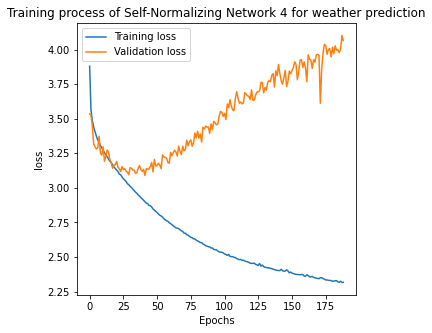

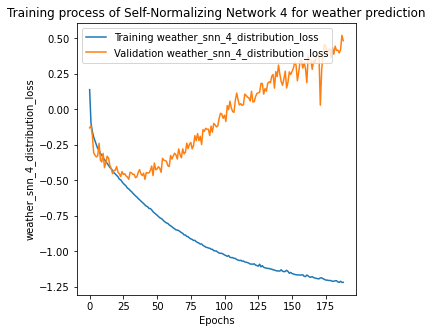

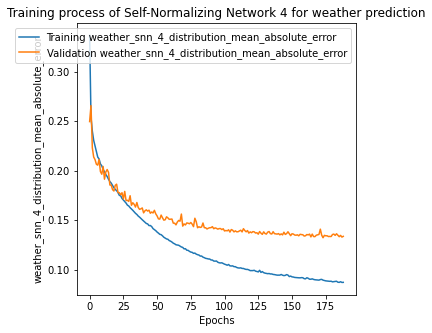


Test quality:
  mean absolute error   = 1.1970384559634064
  mean squared error    = 2.77271203095206
  median absolute error = 0.8810730476244242
  r2 score              = 0.9739252679397816
  R-AUC MSE             = 0.9129760554161179
 Self-Normalizing Network 5 for weather prediction

Model: "weather_snn_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_5_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_5_dropout1 (AlphaDr (None, 123)          0           weather_snn_5_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_5_dense1 (Dense)    (None, 512)          63488       weather_snn_5_dropout1[0][0]

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8491 - weather_snn_5_distribution_loss: 0.1117 - weather_snn_5_projection_loss: 7.4748 - weather_snn_5_distribution_mean_absolute_error: 0.3270 - val_loss: 3.6181 - val_weather_snn_5_distribution_loss: -0.0470 - val_weather_snn_5_projection_loss: 7.3302 - val_weather_snn_5_distribution_mean_absolute_error: 0.2761
Epoch 2/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.5889 - weather_snn_5_distribution_loss: -0.0702 - weather_snn_5_projection_loss: 7.3182 - weather_snn_5_distribution_mean_absolute_error: 0.2621 - val_loss: 3.4069 - val_weather_snn_5_distribution_loss: -0.2337 - val_weather_snn_5_projection_loss: 7.2812 - val_weather_snn_5_distribution_mean_absolute_error: 0.2225
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4767 - weather_snn_5_distribution_loss: -0.1645 - weather_snn_5_projection_loss: 7.2823 - weather_snn_5_distribution_mean_absolut

Epoch 22/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1114 - weather_snn_5_distribution_loss: -0.4815 - weather_snn_5_projection_loss: 7.1858 - weather_snn_5_distribution_mean_absolute_error: 0.1768 - val_loss: 3.1587 - val_weather_snn_5_distribution_loss: -0.4347 - val_weather_snn_5_projection_loss: 7.1868 - val_weather_snn_5_distribution_mean_absolute_error: 0.1768
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0980 - weather_snn_5_distribution_loss: -0.4936 - weather_snn_5_projection_loss: 7.1831 - weather_snn_5_distribution_mean_absolute_error: 0.1748 - val_loss: 3.1532 - val_weather_snn_5_distribution_loss: -0.4388 - val_weather_snn_5_projection_loss: 7.1840 - val_weather_snn_5_distribution_mean_absolute_error: 0.1846
Epoch 24/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0864 - weather_snn_5_distribution_loss: -0.5039 - weather_snn_5_projection_loss: 7.1807 - weather_snn_5_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.8875 - weather_snn_5_distribution_loss: -0.6852 - weather_snn_5_projection_loss: 7.1454 - weather_snn_5_distribution_mean_absolute_error: 0.1462 - val_loss: 3.1367 - val_weather_snn_5_distribution_loss: -0.4486 - val_weather_snn_5_projection_loss: 7.1706 - val_weather_snn_5_distribution_mean_absolute_error: 0.1649
Epoch 44/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.8767 - weather_snn_5_distribution_loss: -0.6952 - weather_snn_5_projection_loss: 7.1437 - weather_snn_5_distribution_mean_absolute_error: 0.1448 - val_loss: 3.1560 - val_weather_snn_5_distribution_loss: -0.4294 - val_weather_snn_5_projection_loss: 7.1707 - val_weather_snn_5_distribution_mean_absolute_error: 0.1590
Epoch 45/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.8690 - weather_snn_5_distribution_loss: -0.7023 - weather_snn_5_projection_loss: 7.1427 - weather_snn_5_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.7170 - weather_snn_5_distribution_loss: -0.8438 - weather_snn_5_projection_loss: 7.1217 - weather_snn_5_distribution_mean_absolute_error: 0.1258 - val_loss: 3.3221 - val_weather_snn_5_distribution_loss: -0.2597 - val_weather_snn_5_projection_loss: 7.1636 - val_weather_snn_5_distribution_mean_absolute_error: 0.1490
Epoch 65/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7139 - weather_snn_5_distribution_loss: -0.8465 - weather_snn_5_projection_loss: 7.1209 - weather_snn_5_distribution_mean_absolute_error: 0.1254 - val_loss: 3.2583 - val_weather_snn_5_distribution_loss: -0.3228 - val_weather_snn_5_projection_loss: 7.1623 - val_weather_snn_5_distribution_mean_absolute_error: 0.1460
Epoch 66/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7042 - weather_snn_5_distribution_loss: -0.8556 - weather_snn_5_projection_loss: 7.1197 - weather_snn_5_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5920 - weather_snn_5_distribution_loss: -0.9611 - weather_snn_5_projection_loss: 7.1063 - weather_snn_5_distribution_mean_absolute_error: 0.1124 - val_loss: 3.4687 - val_weather_snn_5_distribution_loss: -0.1130 - val_weather_snn_5_projection_loss: 7.1634 - val_weather_snn_5_distribution_mean_absolute_error: 0.1446
Epoch 86/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5877 - weather_snn_5_distribution_loss: -0.9651 - weather_snn_5_projection_loss: 7.1056 - weather_snn_5_distribution_mean_absolute_error: 0.1119 - val_loss: 3.4705 - val_weather_snn_5_distribution_loss: -0.1114 - val_weather_snn_5_projection_loss: 7.1638 - val_weather_snn_5_distribution_mean_absolute_error: 0.1454
Epoch 87/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.5823 - weather_snn_5_distribution_loss: -0.9702 - weather_snn_5_projection_loss: 7.1050 - weather_snn_5_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5038 - weather_snn_5_distribution_loss: -1.0443 - weather_snn_5_projection_loss: 7.0961 - weather_snn_5_distribution_mean_absolute_error: 0.1034 - val_loss: 3.5574 - val_weather_snn_5_distribution_loss: -0.0239 - val_weather_snn_5_projection_loss: 7.1625 - val_weather_snn_5_distribution_mean_absolute_error: 0.1412
Epoch 107/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5021 - weather_snn_5_distribution_loss: -1.0456 - weather_snn_5_projection_loss: 7.0955 - weather_snn_5_distribution_mean_absolute_error: 0.1035 - val_loss: 3.5346 - val_weather_snn_5_distribution_loss: -0.0459 - val_weather_snn_5_projection_loss: 7.1608 - val_weather_snn_5_distribution_mean_absolute_error: 0.1407
Epoch 108/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4975 - weather_snn_5_distribution_loss: -1.0500 - weather_snn_5_projection_loss: 7.0949 - weather_snn_5_distribution_mean_

Epoch 127/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4384 - weather_snn_5_distribution_loss: -1.1057 - weather_snn_5_projection_loss: 7.0884 - weather_snn_5_distribution_mean_absolute_error: 0.0975 - val_loss: 3.7918 - val_weather_snn_5_distribution_loss: 0.2096 - val_weather_snn_5_projection_loss: 7.1643 - val_weather_snn_5_distribution_mean_absolute_error: 0.1386
Epoch 128/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4386 - weather_snn_5_distribution_loss: -1.1053 - weather_snn_5_projection_loss: 7.0879 - weather_snn_5_distribution_mean_absolute_error: 0.0975 - val_loss: 3.7022 - val_weather_snn_5_distribution_loss: 0.1205 - val_weather_snn_5_projection_loss: 7.1632 - val_weather_snn_5_distribution_mean_absolute_error: 0.1390
Epoch 129/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4380 - weather_snn_5_distribution_loss: -1.1060 - weather_snn_5_projection_loss: 7.0881 - weather_snn_5_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3951 - weather_snn_5_distribution_loss: -1.1463 - weather_snn_5_projection_loss: 7.0828 - weather_snn_5_distribution_mean_absolute_error: 0.0936 - val_loss: 3.7748 - val_weather_snn_5_distribution_loss: 0.1940 - val_weather_snn_5_projection_loss: 7.1615 - val_weather_snn_5_distribution_mean_absolute_error: 0.1370
Epoch 149/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3933 - weather_snn_5_distribution_loss: -1.1476 - weather_snn_5_projection_loss: 7.0817 - weather_snn_5_distribution_mean_absolute_error: 0.0935 - val_loss: 3.8437 - val_weather_snn_5_distribution_loss: 0.2633 - val_weather_snn_5_projection_loss: 7.1606 - val_weather_snn_5_distribution_mean_absolute_error: 0.1352
Epoch 150/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3865 - weather_snn_5_distribution_loss: -1.1543 - weather_snn_5_projection_loss: 7.0815 - weather_snn_5_distribution_mean_ab

Epoch 00167: early stopping



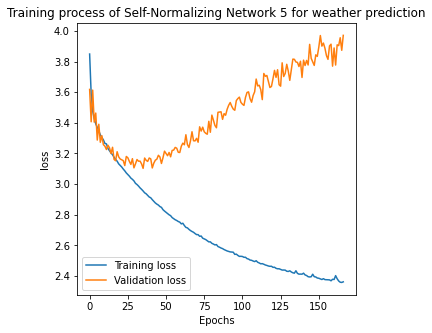

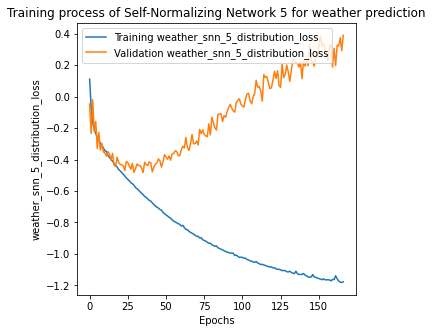

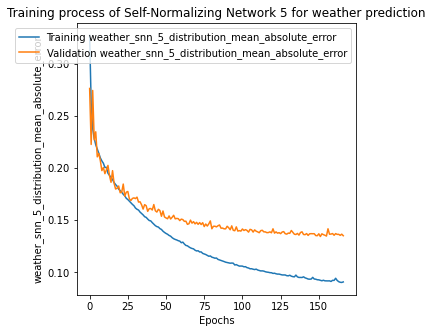


Test quality:
  mean absolute error   = 1.2111920408325967
  mean squared error    = 2.8710513963553166
  median absolute error = 0.8941026221019781
  r2 score              = 0.9729976852817267
  R-AUC MSE             = 0.9399806864775855
 Self-Normalizing Network 6 for weather prediction

Model: "weather_snn_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_6_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_6_dropout1 (AlphaDr (None, 123)          0           weather_snn_6_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_6_dense1 (Dense)    (None, 512)          63488       weather_snn_6_dropout1[0][

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.9090 - weather_snn_6_distribution_loss: 0.1610 - weather_snn_6_projection_loss: 7.4961 - weather_snn_6_distribution_mean_absolute_error: 0.3452 - val_loss: 3.6061 - val_weather_snn_6_distribution_loss: -0.0598 - val_weather_snn_6_projection_loss: 7.3319 - val_weather_snn_6_distribution_mean_absolute_error: 0.2548
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5801 - weather_snn_6_distribution_loss: -0.0807 - weather_snn_6_projection_loss: 7.3217 - weather_snn_6_distribution_mean_absolute_error: 0.2580 - val_loss: 3.4408 - val_weather_snn_6_distribution_loss: -0.2044 - val_weather_snn_6_projection_loss: 7.2906 - val_weather_snn_6_distribution_mean_absolute_error: 0.2233
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4865 - weather_snn_6_distribution_loss: -0.1572 - weather_snn_6_projection_loss: 7.2875 - weather_snn_6_distribution_mean_absolut

Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1194 - weather_snn_6_distribution_loss: -0.4736 - weather_snn_6_projection_loss: 7.1861 - weather_snn_6_distribution_mean_absolute_error: 0.1780 - val_loss: 3.1477 - val_weather_snn_6_distribution_loss: -0.4463 - val_weather_snn_6_projection_loss: 7.1882 - val_weather_snn_6_distribution_mean_absolute_error: 0.1801
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1086 - weather_snn_6_distribution_loss: -0.4833 - weather_snn_6_projection_loss: 7.1838 - weather_snn_6_distribution_mean_absolute_error: 0.1763 - val_loss: 3.1324 - val_weather_snn_6_distribution_loss: -0.4601 - val_weather_snn_6_projection_loss: 7.1849 - val_weather_snn_6_distribution_mean_absolute_error: 0.1767
Epoch 24/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0933 - weather_snn_6_distribution_loss: -0.4971 - weather_snn_6_projection_loss: 7.1808 - weather_snn_6_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8932 - weather_snn_6_distribution_loss: -0.6783 - weather_snn_6_projection_loss: 7.1430 - weather_snn_6_distribution_mean_absolute_error: 0.1470 - val_loss: 3.1389 - val_weather_snn_6_distribution_loss: -0.4462 - val_weather_snn_6_projection_loss: 7.1702 - val_weather_snn_6_distribution_mean_absolute_error: 0.1639
Epoch 44/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8848 - weather_snn_6_distribution_loss: -0.6863 - weather_snn_6_projection_loss: 7.1422 - weather_snn_6_distribution_mean_absolute_error: 0.1459 - val_loss: 3.1426 - val_weather_snn_6_distribution_loss: -0.4418 - val_weather_snn_6_projection_loss: 7.1687 - val_weather_snn_6_distribution_mean_absolute_error: 0.1596
Epoch 45/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8745 - weather_snn_6_distribution_loss: -0.6955 - weather_snn_6_projection_loss: 7.1400 - weather_snn_6_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7223 - weather_snn_6_distribution_loss: -0.8365 - weather_snn_6_projection_loss: 7.1176 - weather_snn_6_distribution_mean_absolute_error: 0.1267 - val_loss: 3.2343 - val_weather_snn_6_distribution_loss: -0.3467 - val_weather_snn_6_projection_loss: 7.1621 - val_weather_snn_6_distribution_mean_absolute_error: 0.1474
Epoch 65/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7111 - weather_snn_6_distribution_loss: -0.8473 - weather_snn_6_projection_loss: 7.1168 - weather_snn_6_distribution_mean_absolute_error: 0.1254 - val_loss: 3.2016 - val_weather_snn_6_distribution_loss: -0.3793 - val_weather_snn_6_projection_loss: 7.1618 - val_weather_snn_6_distribution_mean_absolute_error: 0.1497
Epoch 66/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7100 - weather_snn_6_distribution_loss: -0.8482 - weather_snn_6_projection_loss: 7.1163 - weather_snn_6_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6049 - weather_snn_6_distribution_loss: -0.9467 - weather_snn_6_projection_loss: 7.1033 - weather_snn_6_distribution_mean_absolute_error: 0.1140 - val_loss: 3.3887 - val_weather_snn_6_distribution_loss: -0.1928 - val_weather_snn_6_projection_loss: 7.1630 - val_weather_snn_6_distribution_mean_absolute_error: 0.1432
Epoch 86/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.5884 - weather_snn_6_distribution_loss: -0.9623 - weather_snn_6_projection_loss: 7.1015 - weather_snn_6_distribution_mean_absolute_error: 0.1121 - val_loss: 3.4167 - val_weather_snn_6_distribution_loss: -0.1645 - val_weather_snn_6_projection_loss: 7.1624 - val_weather_snn_6_distribution_mean_absolute_error: 0.1428
Epoch 87/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5867 - weather_snn_6_distribution_loss: -0.9639 - weather_snn_6_projection_loss: 7.1011 - weather_snn_6_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5049 - weather_snn_6_distribution_loss: -1.0409 - weather_snn_6_projection_loss: 7.0916 - weather_snn_6_distribution_mean_absolute_error: 0.1040 - val_loss: 3.5457 - val_weather_snn_6_distribution_loss: -0.0347 - val_weather_snn_6_projection_loss: 7.1608 - val_weather_snn_6_distribution_mean_absolute_error: 0.1390
Epoch 107/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4990 - weather_snn_6_distribution_loss: -1.0466 - weather_snn_6_projection_loss: 7.0912 - weather_snn_6_distribution_mean_absolute_error: 0.1033 - val_loss: 3.5350 - val_weather_snn_6_distribution_loss: -0.0453 - val_weather_snn_6_projection_loss: 7.1606 - val_weather_snn_6_distribution_mean_absolute_error: 0.1385
Epoch 108/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5049 - weather_snn_6_distribution_loss: -1.0408 - weather_snn_6_projection_loss: 7.0915 - weather_snn_6_distribution_mean_

Epoch 127/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.4417 - weather_snn_6_distribution_loss: -1.1004 - weather_snn_6_projection_loss: 7.0843 - weather_snn_6_distribution_mean_absolute_error: 0.0981 - val_loss: 3.7101 - val_weather_snn_6_distribution_loss: 0.1279 - val_weather_snn_6_projection_loss: 7.1645 - val_weather_snn_6_distribution_mean_absolute_error: 0.1376
Epoch 128/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.4388 - weather_snn_6_distribution_loss: -1.1028 - weather_snn_6_projection_loss: 7.0834 - weather_snn_6_distribution_mean_absolute_error: 0.0977 - val_loss: 3.7087 - val_weather_snn_6_distribution_loss: 0.1268 - val_weather_snn_6_projection_loss: 7.1639 - val_weather_snn_6_distribution_mean_absolute_error: 0.1375
Epoch 129/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4354 - weather_snn_6_distribution_loss: -1.1062 - weather_snn_6_projection_loss: 7.0831 - weather_snn_6_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3899 - weather_snn_6_distribution_loss: -1.1488 - weather_snn_6_projection_loss: 7.0774 - weather_snn_6_distribution_mean_absolute_error: 0.0933 - val_loss: 3.8121 - val_weather_snn_6_distribution_loss: 0.2309 - val_weather_snn_6_projection_loss: 7.1623 - val_weather_snn_6_distribution_mean_absolute_error: 0.1363
Epoch 149/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3867 - weather_snn_6_distribution_loss: -1.1519 - weather_snn_6_projection_loss: 7.0773 - weather_snn_6_distribution_mean_absolute_error: 0.0930 - val_loss: 3.8376 - val_weather_snn_6_distribution_loss: 0.2575 - val_weather_snn_6_projection_loss: 7.1602 - val_weather_snn_6_distribution_mean_absolute_error: 0.1355
Epoch 150/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.3858 - weather_snn_6_distribution_loss: -1.1526 - weather_snn_6_projection_loss: 7.0768 - weather_snn_6_distribution_mean_ab

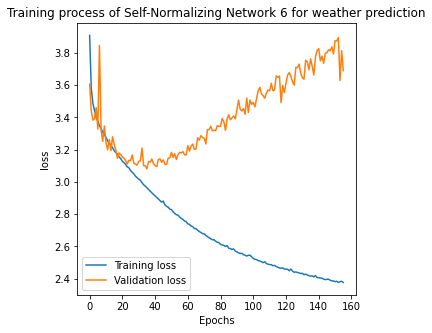

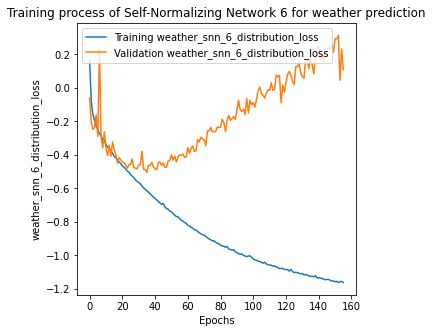

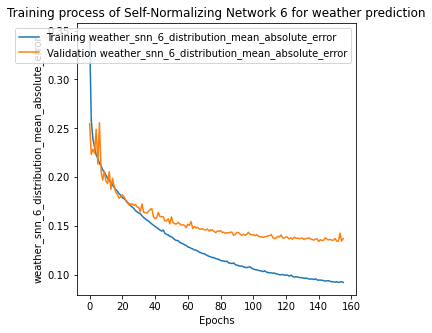


Test quality:
  mean absolute error   = 1.20273350525565
  mean squared error    = 2.7996975589573188
  median absolute error = 0.8851665573313916
  r2 score              = 0.973669301306383
  R-AUC MSE             = 0.9002251917249979
 Self-Normalizing Network 7 for weather prediction

Model: "weather_snn_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_7_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_7_dropout1 (AlphaDr (None, 123)          0           weather_snn_7_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_7_dense1 (Dense)    (None, 512)          63488       weather_snn_7_dropout1[0][0] 

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8691 - weather_snn_7_distribution_loss: 0.1259 - weather_snn_7_projection_loss: 7.4865 - weather_snn_7_distribution_mean_absolute_error: 0.3312 - val_loss: 3.8253 - val_weather_snn_7_distribution_loss: 0.1601 - val_weather_snn_7_projection_loss: 7.3304 - val_weather_snn_7_distribution_mean_absolute_error: 0.2693
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5608 - weather_snn_7_distribution_loss: -0.0988 - weather_snn_7_projection_loss: 7.3192 - weather_snn_7_distribution_mean_absolute_error: 0.2528 - val_loss: 3.4596 - val_weather_snn_7_distribution_loss: -0.1873 - val_weather_snn_7_projection_loss: 7.2938 - val_weather_snn_7_distribution_mean_absolute_error: 0.2455
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4872 - weather_snn_7_distribution_loss: -0.1556 - weather_snn_7_projection_loss: 7.2856 - weather_snn_7_distribution_mean_absolute

Epoch 22/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.1104 - weather_snn_7_distribution_loss: -0.4825 - weather_snn_7_projection_loss: 7.1858 - weather_snn_7_distribution_mean_absolute_error: 0.1765 - val_loss: 3.1580 - val_weather_snn_7_distribution_loss: -0.4354 - val_weather_snn_7_projection_loss: 7.1869 - val_weather_snn_7_distribution_mean_absolute_error: 0.1776
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0996 - weather_snn_7_distribution_loss: -0.4921 - weather_snn_7_projection_loss: 7.1833 - weather_snn_7_distribution_mean_absolute_error: 0.1751 - val_loss: 3.1524 - val_weather_snn_7_distribution_loss: -0.4395 - val_weather_snn_7_projection_loss: 7.1837 - val_weather_snn_7_distribution_mean_absolute_error: 0.1760
Epoch 24/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0903 - weather_snn_7_distribution_loss: -0.5004 - weather_snn_7_projection_loss: 7.1813 - weather_snn_7_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8887 - weather_snn_7_distribution_loss: -0.6836 - weather_snn_7_projection_loss: 7.1447 - weather_snn_7_distribution_mean_absolute_error: 0.1463 - val_loss: 3.1627 - val_weather_snn_7_distribution_loss: -0.4227 - val_weather_snn_7_projection_loss: 7.1708 - val_weather_snn_7_distribution_mean_absolute_error: 0.1574
Epoch 44/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8786 - weather_snn_7_distribution_loss: -0.6928 - weather_snn_7_projection_loss: 7.1428 - weather_snn_7_distribution_mean_absolute_error: 0.1451 - val_loss: 3.1598 - val_weather_snn_7_distribution_loss: -0.4247 - val_weather_snn_7_projection_loss: 7.1689 - val_weather_snn_7_distribution_mean_absolute_error: 0.1575
Epoch 45/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8708 - weather_snn_7_distribution_loss: -0.7000 - weather_snn_7_projection_loss: 7.1416 - weather_snn_7_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.7193 - weather_snn_7_distribution_loss: -0.8407 - weather_snn_7_projection_loss: 7.1199 - weather_snn_7_distribution_mean_absolute_error: 0.1261 - val_loss: 3.2603 - val_weather_snn_7_distribution_loss: -0.3212 - val_weather_snn_7_projection_loss: 7.1630 - val_weather_snn_7_distribution_mean_absolute_error: 0.1500
Epoch 65/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7080 - weather_snn_7_distribution_loss: -0.8516 - weather_snn_7_projection_loss: 7.1193 - weather_snn_7_distribution_mean_absolute_error: 0.1248 - val_loss: 3.2219 - val_weather_snn_7_distribution_loss: -0.3588 - val_weather_snn_7_projection_loss: 7.1614 - val_weather_snn_7_distribution_mean_absolute_error: 0.1480
Epoch 66/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7030 - weather_snn_7_distribution_loss: -0.8562 - weather_snn_7_projection_loss: 7.1183 - weather_snn_7_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5941 - weather_snn_7_distribution_loss: -0.9586 - weather_snn_7_projection_loss: 7.1054 - weather_snn_7_distribution_mean_absolute_error: 0.1126 - val_loss: 3.4133 - val_weather_snn_7_distribution_loss: -0.1689 - val_weather_snn_7_projection_loss: 7.1643 - val_weather_snn_7_distribution_mean_absolute_error: 0.1448
Epoch 86/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.5961 - weather_snn_7_distribution_loss: -0.9565 - weather_snn_7_projection_loss: 7.1051 - weather_snn_7_distribution_mean_absolute_error: 0.1131 - val_loss: 3.4105 - val_weather_snn_7_distribution_loss: -0.1713 - val_weather_snn_7_projection_loss: 7.1637 - val_weather_snn_7_distribution_mean_absolute_error: 0.1433
Epoch 87/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5852 - weather_snn_7_distribution_loss: -0.9668 - weather_snn_7_projection_loss: 7.1040 - weather_snn_7_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5232 - weather_snn_7_distribution_loss: -1.0250 - weather_snn_7_projection_loss: 7.0963 - weather_snn_7_distribution_mean_absolute_error: 0.1059 - val_loss: 3.5265 - val_weather_snn_7_distribution_loss: -0.0547 - val_weather_snn_7_projection_loss: 7.1625 - val_weather_snn_7_distribution_mean_absolute_error: 0.1399
Epoch 107/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5036 - weather_snn_7_distribution_loss: -1.0438 - weather_snn_7_projection_loss: 7.0948 - weather_snn_7_distribution_mean_absolute_error: 0.1035 - val_loss: 3.5466 - val_weather_snn_7_distribution_loss: -0.0340 - val_weather_snn_7_projection_loss: 7.1611 - val_weather_snn_7_distribution_mean_absolute_error: 0.1394
Epoch 108/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4967 - weather_snn_7_distribution_loss: -1.0502 - weather_snn_7_projection_loss: 7.0938 - weather_snn_7_distribution_mean_

Epoch 127/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4382 - weather_snn_7_distribution_loss: -1.1055 - weather_snn_7_projection_loss: 7.0875 - weather_snn_7_distribution_mean_absolute_error: 0.0975 - val_loss: 3.7652 - val_weather_snn_7_distribution_loss: 0.1830 - val_weather_snn_7_projection_loss: 7.1645 - val_weather_snn_7_distribution_mean_absolute_error: 0.1381
Epoch 128/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4377 - weather_snn_7_distribution_loss: -1.1058 - weather_snn_7_projection_loss: 7.0871 - weather_snn_7_distribution_mean_absolute_error: 0.0973 - val_loss: 3.6846 - val_weather_snn_7_distribution_loss: 0.1028 - val_weather_snn_7_projection_loss: 7.1637 - val_weather_snn_7_distribution_mean_absolute_error: 0.1385
Epoch 129/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4360 - weather_snn_7_distribution_loss: -1.1072 - weather_snn_7_projection_loss: 7.0864 - weather_snn_7_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3988 - weather_snn_7_distribution_loss: -1.1421 - weather_snn_7_projection_loss: 7.0817 - weather_snn_7_distribution_mean_absolute_error: 0.0938 - val_loss: 3.8084 - val_weather_snn_7_distribution_loss: 0.2265 - val_weather_snn_7_projection_loss: 7.1638 - val_weather_snn_7_distribution_mean_absolute_error: 0.1394
Epoch 149/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3906 - weather_snn_7_distribution_loss: -1.1499 - weather_snn_7_projection_loss: 7.0810 - weather_snn_7_distribution_mean_absolute_error: 0.0932 - val_loss: 3.8015 - val_weather_snn_7_distribution_loss: 0.2208 - val_weather_snn_7_projection_loss: 7.1614 - val_weather_snn_7_distribution_mean_absolute_error: 0.1350
Epoch 150/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3854 - weather_snn_7_distribution_loss: -1.1549 - weather_snn_7_projection_loss: 7.0806 - weather_snn_7_distribution_mean_ab

Epoch 169/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3543 - weather_snn_7_distribution_loss: -1.1838 - weather_snn_7_projection_loss: 7.0763 - weather_snn_7_distribution_mean_absolute_error: 0.0901 - val_loss: 3.9726 - val_weather_snn_7_distribution_loss: 0.3899 - val_weather_snn_7_projection_loss: 7.1655 - val_weather_snn_7_distribution_mean_absolute_error: 0.1349
Epoch 170/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3461 - weather_snn_7_distribution_loss: -1.1918 - weather_snn_7_projection_loss: 7.0758 - weather_snn_7_distribution_mean_absolute_error: 0.0893 - val_loss: 3.9514 - val_weather_snn_7_distribution_loss: 0.3698 - val_weather_snn_7_projection_loss: 7.1632 - val_weather_snn_7_distribution_mean_absolute_error: 0.1343
Epoch 171/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3488 - weather_snn_7_distribution_loss: -1.1892 - weather_snn_7_projection_loss: 7.0761 - weather_snn_7_distribution_mean_ab

Epoch 190/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3125 - weather_snn_7_distribution_loss: -1.2231 - weather_snn_7_projection_loss: 7.0713 - weather_snn_7_distribution_mean_absolute_error: 0.0866 - val_loss: 4.0109 - val_weather_snn_7_distribution_loss: 0.4291 - val_weather_snn_7_projection_loss: 7.1636 - val_weather_snn_7_distribution_mean_absolute_error: 0.1330
Epoch 191/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3146 - weather_snn_7_distribution_loss: -1.2211 - weather_snn_7_projection_loss: 7.0715 - weather_snn_7_distribution_mean_absolute_error: 0.0867 - val_loss: 4.0238 - val_weather_snn_7_distribution_loss: 0.4423 - val_weather_snn_7_projection_loss: 7.1631 - val_weather_snn_7_distribution_mean_absolute_error: 0.1331
Epoch 192/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3166 - weather_snn_7_distribution_loss: -1.2190 - weather_snn_7_projection_loss: 7.0713 - weather_snn_7_distribution_mean_ab

Epoch 211/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2915 - weather_snn_7_distribution_loss: -1.2424 - weather_snn_7_projection_loss: 7.0679 - weather_snn_7_distribution_mean_absolute_error: 0.0849 - val_loss: 4.1321 - val_weather_snn_7_distribution_loss: 0.5493 - val_weather_snn_7_projection_loss: 7.1657 - val_weather_snn_7_distribution_mean_absolute_error: 0.1336
Epoch 212/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2921 - weather_snn_7_distribution_loss: -1.2417 - weather_snn_7_projection_loss: 7.0677 - weather_snn_7_distribution_mean_absolute_error: 0.0850 - val_loss: 4.0537 - val_weather_snn_7_distribution_loss: 0.4715 - val_weather_snn_7_projection_loss: 7.1646 - val_weather_snn_7_distribution_mean_absolute_error: 0.1332
Epoch 213/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2962 - weather_snn_7_distribution_loss: -1.2379 - weather_snn_7_projection_loss: 7.0681 - weather_snn_7_distribution_mean_ab

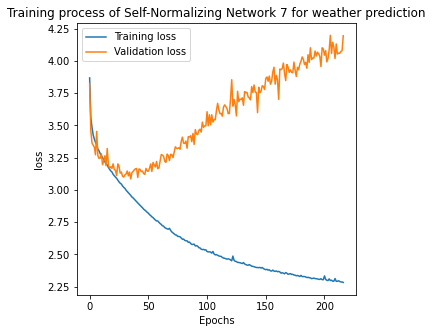

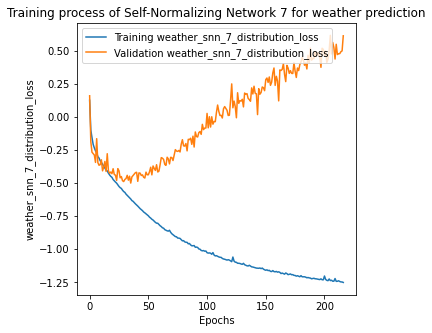

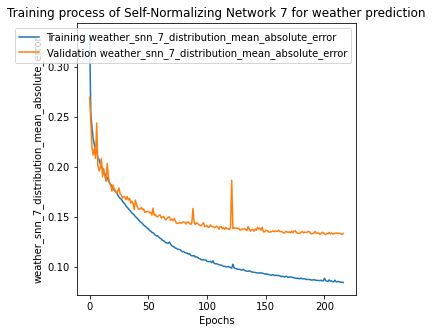


Test quality:
  mean absolute error   = 1.2037188760492405
  mean squared error    = 2.827468624469824
  median absolute error = 0.8862917043157976
  r2 score              = 0.9734080659802254
  R-AUC MSE             = 0.9074086723649252
 Self-Normalizing Network 8 for weather prediction

Model: "weather_snn_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_8_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_8_dropout1 (AlphaDr (None, 123)          0           weather_snn_8_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_8_dense1 (Dense)    (None, 512)          63488       weather_snn_8_dropout1[0][0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8856 - weather_snn_8_distribution_loss: 0.1429 - weather_snn_8_projection_loss: 7.4852 - weather_snn_8_distribution_mean_absolute_error: 0.3393 - val_loss: 3.5220 - val_weather_snn_8_distribution_loss: -0.1491 - val_weather_snn_8_projection_loss: 7.3423 - val_weather_snn_8_distribution_mean_absolute_error: 0.2407
Epoch 2/1000
725/725 [==============================] - 35s 49ms/step - loss: 3.5604 - weather_snn_8_distribution_loss: -0.1001 - weather_snn_8_projection_loss: 7.3210 - weather_snn_8_distribution_mean_absolute_error: 0.2529 - val_loss: 3.4080 - val_weather_snn_8_distribution_loss: -0.2349 - val_weather_snn_8_projection_loss: 7.2857 - val_weather_snn_8_distribution_mean_absolute_error: 0.2234
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4801 - weather_snn_8_distribution_loss: -0.1624 - weather_snn_8_projection_loss: 7.2848 - weather_snn_8_distribution_mean_absolut

Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1105 - weather_snn_8_distribution_loss: -0.4823 - weather_snn_8_projection_loss: 7.1855 - weather_snn_8_distribution_mean_absolute_error: 0.1764 - val_loss: 3.1382 - val_weather_snn_8_distribution_loss: -0.4551 - val_weather_snn_8_projection_loss: 7.1864 - val_weather_snn_8_distribution_mean_absolute_error: 0.1762
Epoch 23/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.1042 - weather_snn_8_distribution_loss: -0.4874 - weather_snn_8_projection_loss: 7.1834 - weather_snn_8_distribution_mean_absolute_error: 0.1758 - val_loss: 3.1426 - val_weather_snn_8_distribution_loss: -0.4492 - val_weather_snn_8_projection_loss: 7.1837 - val_weather_snn_8_distribution_mean_absolute_error: 0.1791
Epoch 24/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.0901 - weather_snn_8_distribution_loss: -0.5005 - weather_snn_8_projection_loss: 7.1811 - weather_snn_8_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.8898 - weather_snn_8_distribution_loss: -0.6827 - weather_snn_8_projection_loss: 7.1448 - weather_snn_8_distribution_mean_absolute_error: 0.1464 - val_loss: 3.1697 - val_weather_snn_8_distribution_loss: -0.4157 - val_weather_snn_8_projection_loss: 7.1708 - val_weather_snn_8_distribution_mean_absolute_error: 0.1612
Epoch 44/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8837 - weather_snn_8_distribution_loss: -0.6882 - weather_snn_8_projection_loss: 7.1437 - weather_snn_8_distribution_mean_absolute_error: 0.1459 - val_loss: 3.1448 - val_weather_snn_8_distribution_loss: -0.4399 - val_weather_snn_8_projection_loss: 7.1693 - val_weather_snn_8_distribution_mean_absolute_error: 0.1583
Epoch 45/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8716 - weather_snn_8_distribution_loss: -0.6992 - weather_snn_8_projection_loss: 7.1417 - weather_snn_8_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7188 - weather_snn_8_distribution_loss: -0.8412 - weather_snn_8_projection_loss: 7.1199 - weather_snn_8_distribution_mean_absolute_error: 0.1259 - val_loss: 3.2581 - val_weather_snn_8_distribution_loss: -0.3240 - val_weather_snn_8_projection_loss: 7.1642 - val_weather_snn_8_distribution_mean_absolute_error: 0.1483
Epoch 65/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7158 - weather_snn_8_distribution_loss: -0.8439 - weather_snn_8_projection_loss: 7.1193 - weather_snn_8_distribution_mean_absolute_error: 0.1256 - val_loss: 3.2150 - val_weather_snn_8_distribution_loss: -0.3660 - val_weather_snn_8_projection_loss: 7.1618 - val_weather_snn_8_distribution_mean_absolute_error: 0.1479
Epoch 66/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7062 - weather_snn_8_distribution_loss: -0.8528 - weather_snn_8_projection_loss: 7.1180 - weather_snn_8_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5977 - weather_snn_8_distribution_loss: -0.9547 - weather_snn_8_projection_loss: 7.1048 - weather_snn_8_distribution_mean_absolute_error: 0.1130 - val_loss: 3.4053 - val_weather_snn_8_distribution_loss: -0.1764 - val_weather_snn_8_projection_loss: 7.1633 - val_weather_snn_8_distribution_mean_absolute_error: 0.1455
Epoch 86/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5936 - weather_snn_8_distribution_loss: -0.9587 - weather_snn_8_projection_loss: 7.1046 - weather_snn_8_distribution_mean_absolute_error: 0.1127 - val_loss: 3.4286 - val_weather_snn_8_distribution_loss: -0.1529 - val_weather_snn_8_projection_loss: 7.1628 - val_weather_snn_8_distribution_mean_absolute_error: 0.1435
Epoch 87/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5905 - weather_snn_8_distribution_loss: -0.9617 - weather_snn_8_projection_loss: 7.1044 - weather_snn_8_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5055 - weather_snn_8_distribution_loss: -1.0418 - weather_snn_8_projection_loss: 7.0946 - weather_snn_8_distribution_mean_absolute_error: 0.1037 - val_loss: 3.6031 - val_weather_snn_8_distribution_loss: 0.0231 - val_weather_snn_8_projection_loss: 7.1599 - val_weather_snn_8_distribution_mean_absolute_error: 0.1388
Epoch 107/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5004 - weather_snn_8_distribution_loss: -1.0465 - weather_snn_8_projection_loss: 7.0938 - weather_snn_8_distribution_mean_absolute_error: 0.1032 - val_loss: 3.5448 - val_weather_snn_8_distribution_loss: -0.0357 - val_weather_snn_8_projection_loss: 7.1610 - val_weather_snn_8_distribution_mean_absolute_error: 0.1401
Epoch 108/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4972 - weather_snn_8_distribution_loss: -1.0496 - weather_snn_8_projection_loss: 7.0936 - weather_snn_8_distribution_mean_a

Epoch 127/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4392 - weather_snn_8_distribution_loss: -1.1043 - weather_snn_8_projection_loss: 7.0869 - weather_snn_8_distribution_mean_absolute_error: 0.0975 - val_loss: 3.7239 - val_weather_snn_8_distribution_loss: 0.1424 - val_weather_snn_8_projection_loss: 7.1631 - val_weather_snn_8_distribution_mean_absolute_error: 0.1396
Epoch 128/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4341 - weather_snn_8_distribution_loss: -1.1090 - weather_snn_8_projection_loss: 7.0861 - weather_snn_8_distribution_mean_absolute_error: 0.0969 - val_loss: 3.7684 - val_weather_snn_8_distribution_loss: 0.1871 - val_weather_snn_8_projection_loss: 7.1626 - val_weather_snn_8_distribution_mean_absolute_error: 0.1370
Epoch 129/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4424 - weather_snn_8_distribution_loss: -1.1008 - weather_snn_8_projection_loss: 7.0865 - weather_snn_8_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3996 - weather_snn_8_distribution_loss: -1.1409 - weather_snn_8_projection_loss: 7.0811 - weather_snn_8_distribution_mean_absolute_error: 0.0944 - val_loss: 3.7578 - val_weather_snn_8_distribution_loss: 0.1773 - val_weather_snn_8_projection_loss: 7.1609 - val_weather_snn_8_distribution_mean_absolute_error: 0.1371
Epoch 149/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3913 - weather_snn_8_distribution_loss: -1.1489 - weather_snn_8_projection_loss: 7.0803 - weather_snn_8_distribution_mean_absolute_error: 0.0933 - val_loss: 3.7959 - val_weather_snn_8_distribution_loss: 0.2153 - val_weather_snn_8_projection_loss: 7.1611 - val_weather_snn_8_distribution_mean_absolute_error: 0.1364
Epoch 150/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3849 - weather_snn_8_distribution_loss: -1.1553 - weather_snn_8_projection_loss: 7.0802 - weather_snn_8_distribution_mean_ab

Epoch 169/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3462 - weather_snn_8_distribution_loss: -1.1913 - weather_snn_8_projection_loss: 7.0751 - weather_snn_8_distribution_mean_absolute_error: 0.0893 - val_loss: 3.9501 - val_weather_snn_8_distribution_loss: 0.3686 - val_weather_snn_8_projection_loss: 7.1629 - val_weather_snn_8_distribution_mean_absolute_error: 0.1349
Epoch 170/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3471 - weather_snn_8_distribution_loss: -1.1902 - weather_snn_8_projection_loss: 7.0747 - weather_snn_8_distribution_mean_absolute_error: 0.0893 - val_loss: 3.9807 - val_weather_snn_8_distribution_loss: 0.3993 - val_weather_snn_8_projection_loss: 7.1627 - val_weather_snn_8_distribution_mean_absolute_error: 0.1352
Epoch 171/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3443 - weather_snn_8_distribution_loss: -1.1930 - weather_snn_8_projection_loss: 7.0746 - weather_snn_8_distribution_mean_ab

Epoch 190/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3198 - weather_snn_8_distribution_loss: -1.2157 - weather_snn_8_projection_loss: 7.0710 - weather_snn_8_distribution_mean_absolute_error: 0.0873 - val_loss: 4.0355 - val_weather_snn_8_distribution_loss: 0.4550 - val_weather_snn_8_projection_loss: 7.1610 - val_weather_snn_8_distribution_mean_absolute_error: 0.1333
Epoch 191/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3136 - weather_snn_8_distribution_loss: -1.2216 - weather_snn_8_projection_loss: 7.0703 - weather_snn_8_distribution_mean_absolute_error: 0.0867 - val_loss: 4.0249 - val_weather_snn_8_distribution_loss: 0.4441 - val_weather_snn_8_projection_loss: 7.1615 - val_weather_snn_8_distribution_mean_absolute_error: 0.1327
Epoch 192/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3244 - weather_snn_8_distribution_loss: -1.2110 - weather_snn_8_projection_loss: 7.0707 - weather_snn_8_distribution_mean_ab

Epoch 211/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.2894 - weather_snn_8_distribution_loss: -1.2438 - weather_snn_8_projection_loss: 7.0664 - weather_snn_8_distribution_mean_absolute_error: 0.0847 - val_loss: 4.1318 - val_weather_snn_8_distribution_loss: 0.5497 - val_weather_snn_8_projection_loss: 7.1642 - val_weather_snn_8_distribution_mean_absolute_error: 0.1341
Epoch 212/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2862 - weather_snn_8_distribution_loss: -1.2470 - weather_snn_8_projection_loss: 7.0664 - weather_snn_8_distribution_mean_absolute_error: 0.0845 - val_loss: 4.1240 - val_weather_snn_8_distribution_loss: 0.5425 - val_weather_snn_8_projection_loss: 7.1631 - val_weather_snn_8_distribution_mean_absolute_error: 0.1332
Epoch 213/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2846 - weather_snn_8_distribution_loss: -1.2483 - weather_snn_8_projection_loss: 7.0659 - weather_snn_8_distribution_mean_ab

Epoch 00231: early stopping



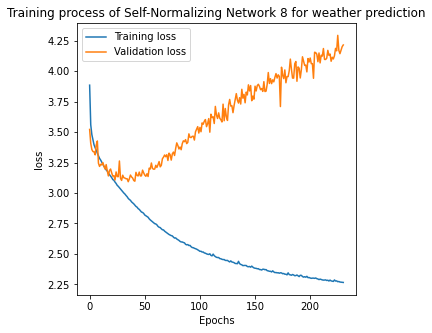

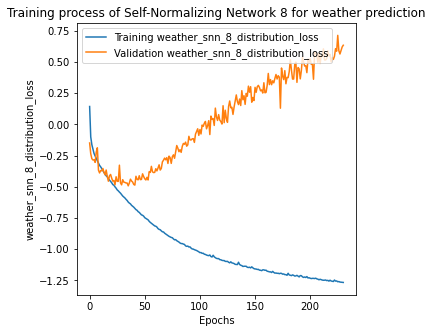

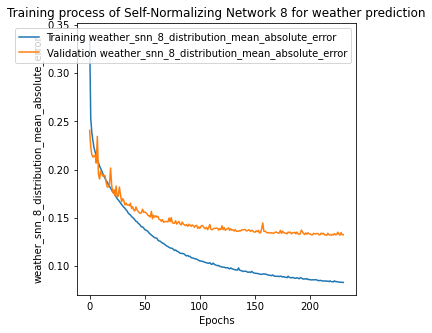


Test quality:
  mean absolute error   = 1.2015921084681682
  mean squared error    = 2.812734249464042
  median absolute error = 0.883709610441441
  r2 score              = 0.9735409730460293
  R-AUC MSE             = 0.9136882811886958
 Self-Normalizing Network 9 for weather prediction

Model: "weather_snn_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_9_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_9_dropout1 (AlphaDr (None, 123)          0           weather_snn_9_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_9_dense1 (Dense)    (None, 512)          63488       weather_snn_9_dropout1[0][0]

Epoch 1/1000
725/725 [==============================] - 34s 48ms/step - loss: 3.8842 - weather_snn_9_distribution_loss: 0.1351 - weather_snn_9_projection_loss: 7.4983 - weather_snn_9_distribution_mean_absolute_error: 0.3378 - val_loss: 3.7223 - val_weather_snn_9_distribution_loss: 0.0434 - val_weather_snn_9_projection_loss: 7.3579 - val_weather_snn_9_distribution_mean_absolute_error: 0.2929
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5607 - weather_snn_9_distribution_loss: -0.1026 - weather_snn_9_projection_loss: 7.3267 - weather_snn_9_distribution_mean_absolute_error: 0.2526 - val_loss: 3.4653 - val_weather_snn_9_distribution_loss: -0.1820 - val_weather_snn_9_projection_loss: 7.2944 - val_weather_snn_9_distribution_mean_absolute_error: 0.2406
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4736 - weather_snn_9_distribution_loss: -0.1722 - weather_snn_9_projection_loss: 7.2915 - weather_snn_9_distribution_mean_absolute

Epoch 22/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.1061 - weather_snn_9_distribution_loss: -0.4872 - weather_snn_9_projection_loss: 7.1867 - weather_snn_9_distribution_mean_absolute_error: 0.1757 - val_loss: 3.1753 - val_weather_snn_9_distribution_loss: -0.4184 - val_weather_snn_9_projection_loss: 7.1874 - val_weather_snn_9_distribution_mean_absolute_error: 0.1803
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0987 - weather_snn_9_distribution_loss: -0.4935 - weather_snn_9_projection_loss: 7.1845 - weather_snn_9_distribution_mean_absolute_error: 0.1749 - val_loss: 3.1337 - val_weather_snn_9_distribution_loss: -0.4599 - val_weather_snn_9_projection_loss: 7.1873 - val_weather_snn_9_distribution_mean_absolute_error: 0.1758
Epoch 24/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0874 - weather_snn_9_distribution_loss: -0.5037 - weather_snn_9_projection_loss: 7.1821 - weather_snn_9_distribution_mean_abs

Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8842 - weather_snn_9_distribution_loss: -0.6892 - weather_snn_9_projection_loss: 7.1469 - weather_snn_9_distribution_mean_absolute_error: 0.1456 - val_loss: 3.1756 - val_weather_snn_9_distribution_loss: -0.4105 - val_weather_snn_9_projection_loss: 7.1722 - val_weather_snn_9_distribution_mean_absolute_error: 0.1666
Epoch 44/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8756 - weather_snn_9_distribution_loss: -0.6973 - weather_snn_9_projection_loss: 7.1459 - weather_snn_9_distribution_mean_absolute_error: 0.1447 - val_loss: 3.1372 - val_weather_snn_9_distribution_loss: -0.4478 - val_weather_snn_9_projection_loss: 7.1699 - val_weather_snn_9_distribution_mean_absolute_error: 0.1591
Epoch 45/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8668 - weather_snn_9_distribution_loss: -0.7055 - weather_snn_9_projection_loss: 7.1446 - weather_snn_9_distribution_mean_abs

Epoch 64/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7138 - weather_snn_9_distribution_loss: -0.8485 - weather_snn_9_projection_loss: 7.1247 - weather_snn_9_distribution_mean_absolute_error: 0.1254 - val_loss: 3.2541 - val_weather_snn_9_distribution_loss: -0.3287 - val_weather_snn_9_projection_loss: 7.1655 - val_weather_snn_9_distribution_mean_absolute_error: 0.1472
Epoch 65/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.7100 - weather_snn_9_distribution_loss: -0.8521 - weather_snn_9_projection_loss: 7.1243 - weather_snn_9_distribution_mean_absolute_error: 0.1249 - val_loss: 3.2275 - val_weather_snn_9_distribution_loss: -0.3552 - val_weather_snn_9_projection_loss: 7.1654 - val_weather_snn_9_distribution_mean_absolute_error: 0.1482
Epoch 66/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7008 - weather_snn_9_distribution_loss: -0.8608 - weather_snn_9_projection_loss: 7.1230 - weather_snn_9_distribution_mean_abs

Epoch 85/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5932 - weather_snn_9_distribution_loss: -0.9617 - weather_snn_9_projection_loss: 7.1098 - weather_snn_9_distribution_mean_absolute_error: 0.1125 - val_loss: 3.4357 - val_weather_snn_9_distribution_loss: -0.1468 - val_weather_snn_9_projection_loss: 7.1650 - val_weather_snn_9_distribution_mean_absolute_error: 0.1426
Epoch 86/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5851 - weather_snn_9_distribution_loss: -0.9694 - weather_snn_9_projection_loss: 7.1090 - weather_snn_9_distribution_mean_absolute_error: 0.1115 - val_loss: 3.4585 - val_weather_snn_9_distribution_loss: -0.1240 - val_weather_snn_9_projection_loss: 7.1650 - val_weather_snn_9_distribution_mean_absolute_error: 0.1439
Epoch 87/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5850 - weather_snn_9_distribution_loss: -0.9695 - weather_snn_9_projection_loss: 7.1091 - weather_snn_9_distribution_mean_abs

Epoch 106/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5116 - weather_snn_9_distribution_loss: -1.0382 - weather_snn_9_projection_loss: 7.0996 - weather_snn_9_distribution_mean_absolute_error: 0.1046 - val_loss: 3.5251 - val_weather_snn_9_distribution_loss: -0.0565 - val_weather_snn_9_projection_loss: 7.1633 - val_weather_snn_9_distribution_mean_absolute_error: 0.1404
Epoch 107/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5026 - weather_snn_9_distribution_loss: -1.0467 - weather_snn_9_projection_loss: 7.0986 - weather_snn_9_distribution_mean_absolute_error: 0.1035 - val_loss: 3.5514 - val_weather_snn_9_distribution_loss: -0.0291 - val_weather_snn_9_projection_loss: 7.1609 - val_weather_snn_9_distribution_mean_absolute_error: 0.1384
Epoch 108/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4958 - weather_snn_9_distribution_loss: -1.0532 - weather_snn_9_projection_loss: 7.0980 - weather_snn_9_distribution_mean_

Epoch 127/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4471 - weather_snn_9_distribution_loss: -1.0987 - weather_snn_9_projection_loss: 7.0916 - weather_snn_9_distribution_mean_absolute_error: 0.0983 - val_loss: 3.7421 - val_weather_snn_9_distribution_loss: 0.1608 - val_weather_snn_9_projection_loss: 7.1626 - val_weather_snn_9_distribution_mean_absolute_error: 0.1380
Epoch 128/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4440 - weather_snn_9_distribution_loss: -1.1017 - weather_snn_9_projection_loss: 7.0914 - weather_snn_9_distribution_mean_absolute_error: 0.0980 - val_loss: 3.7339 - val_weather_snn_9_distribution_loss: 0.1519 - val_weather_snn_9_projection_loss: 7.1640 - val_weather_snn_9_distribution_mean_absolute_error: 0.1392
Epoch 129/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4359 - weather_snn_9_distribution_loss: -1.1093 - weather_snn_9_projection_loss: 7.0905 - weather_snn_9_distribution_mean_ab

Epoch 148/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3918 - weather_snn_9_distribution_loss: -1.1507 - weather_snn_9_projection_loss: 7.0850 - weather_snn_9_distribution_mean_absolute_error: 0.0933 - val_loss: 3.8842 - val_weather_snn_9_distribution_loss: 0.3031 - val_weather_snn_9_projection_loss: 7.1622 - val_weather_snn_9_distribution_mean_absolute_error: 0.1373
Epoch 149/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3884 - weather_snn_9_distribution_loss: -1.1542 - weather_snn_9_projection_loss: 7.0851 - weather_snn_9_distribution_mean_absolute_error: 0.0929 - val_loss: 3.8420 - val_weather_snn_9_distribution_loss: 0.2610 - val_weather_snn_9_projection_loss: 7.1621 - val_weather_snn_9_distribution_mean_absolute_error: 0.1370
Epoch 150/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3836 - weather_snn_9_distribution_loss: -1.1587 - weather_snn_9_projection_loss: 7.0845 - weather_snn_9_distribution_mean_ab

Epoch 169/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3514 - weather_snn_9_distribution_loss: -1.1887 - weather_snn_9_projection_loss: 7.0801 - weather_snn_9_distribution_mean_absolute_error: 0.0899 - val_loss: 4.0012 - val_weather_snn_9_distribution_loss: 0.4192 - val_weather_snn_9_projection_loss: 7.1640 - val_weather_snn_9_distribution_mean_absolute_error: 0.1342
Epoch 170/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3467 - weather_snn_9_distribution_loss: -1.1932 - weather_snn_9_projection_loss: 7.0798 - weather_snn_9_distribution_mean_absolute_error: 0.0893 - val_loss: 3.9390 - val_weather_snn_9_distribution_loss: 0.3574 - val_weather_snn_9_projection_loss: 7.1632 - val_weather_snn_9_distribution_mean_absolute_error: 0.1347
Epoch 171/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3477 - weather_snn_9_distribution_loss: -1.1922 - weather_snn_9_projection_loss: 7.0796 - weather_snn_9_distribution_mean_ab

Epoch 00188: early stopping



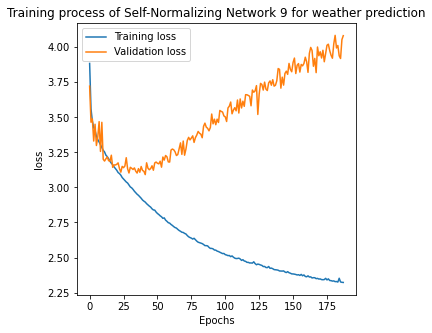

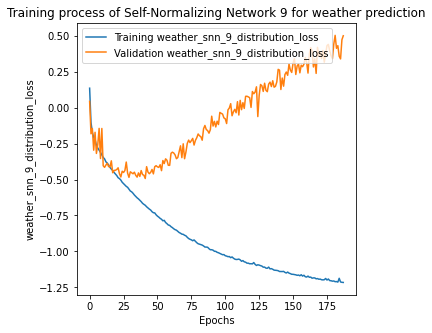

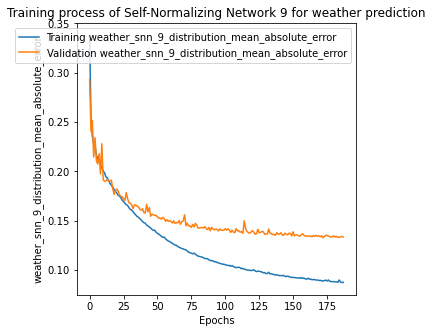


Test quality:
  mean absolute error   = 1.202689380008687
  mean squared error    = 2.7929744545974726
  median absolute error = 0.8860228500722567
  r2 score              = 0.9737324090903711
  R-AUC MSE             = 0.9121944073499548
 Self-Normalizing Network 10 for weather prediction

Model: "weather_snn_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_10_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_10_dropout1 (AlphaD (None, 123)          0           weather_snn_10_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_10_dense1 (Dense)   (None, 512)          63488       weather_snn_10_dropout1[0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.9065 - weather_snn_10_distribution_loss: 0.1540 - weather_snn_10_projection_loss: 7.5051 - weather_snn_10_distribution_mean_absolute_error: 0.3450 - val_loss: 3.6043 - val_weather_snn_10_distribution_loss: -0.0681 - val_weather_snn_10_projection_loss: 7.3450 - val_weather_snn_10_distribution_mean_absolute_error: 0.2567
Epoch 2/1000
725/725 [==============================] - 35s 49ms/step - loss: 3.5633 - weather_snn_10_distribution_loss: -0.0989 - weather_snn_10_projection_loss: 7.3243 - weather_snn_10_distribution_mean_absolute_error: 0.2535 - val_loss: 3.5221 - val_weather_snn_10_distribution_loss: -0.1250 - val_weather_snn_10_projection_loss: 7.2941 - val_weather_snn_10_distribution_mean_absolute_error: 0.2408
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4833 - weather_snn_10_distribution_loss: -0.1629 - weather_snn_10_projection_loss: 7.2923 - weather_snn_10_distributi

725/725 [==============================] - 36s 50ms/step - loss: 3.1210 - weather_snn_10_distribution_loss: -0.4732 - weather_snn_10_projection_loss: 7.1884 - weather_snn_10_distribution_mean_absolute_error: 0.1782 - val_loss: 3.1478 - val_weather_snn_10_distribution_loss: -0.4475 - val_weather_snn_10_projection_loss: 7.1906 - val_weather_snn_10_distribution_mean_absolute_error: 0.1784
Epoch 22/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1127 - weather_snn_10_distribution_loss: -0.4805 - weather_snn_10_projection_loss: 7.1864 - weather_snn_10_distribution_mean_absolute_error: 0.1771 - val_loss: 3.1750 - val_weather_snn_10_distribution_loss: -0.4207 - val_weather_snn_10_projection_loss: 7.1914 - val_weather_snn_10_distribution_mean_absolute_error: 0.1823
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0984 - weather_snn_10_distribution_loss: -0.4935 - weather_snn_10_projection_loss: 7.1837 - weather_snn_10_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.9057 - weather_snn_10_distribution_loss: -0.6685 - weather_snn_10_projection_loss: 7.1483 - weather_snn_10_distribution_mean_absolute_error: 0.1488 - val_loss: 3.1230 - val_weather_snn_10_distribution_loss: -0.4636 - val_weather_snn_10_projection_loss: 7.1732 - val_weather_snn_10_distribution_mean_absolute_error: 0.1594
Epoch 42/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8980 - weather_snn_10_distribution_loss: -0.6756 - weather_snn_10_projection_loss: 7.1471 - weather_snn_10_distribution_mean_absolute_error: 0.1478 - val_loss: 3.0932 - val_weather_snn_10_distribution_loss: -0.4914 - val_weather_snn_10_projection_loss: 7.1693 - val_weather_snn_10_distribution_mean_absolute_error: 0.1598
Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8906 - weather_snn_10_distribution_loss: -0.6823 - weather_snn_10_projection_loss: 7.1459 - weather_snn_10_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.7427 - weather_snn_10_distribution_loss: -0.8201 - weather_snn_10_projection_loss: 7.1255 - weather_snn_10_distribution_mean_absolute_error: 0.1290 - val_loss: 3.2537 - val_weather_snn_10_distribution_loss: -0.3313 - val_weather_snn_10_projection_loss: 7.1700 - val_weather_snn_10_distribution_mean_absolute_error: 0.1491
Epoch 62/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7292 - weather_snn_10_distribution_loss: -0.8329 - weather_snn_10_projection_loss: 7.1241 - weather_snn_10_distribution_mean_absolute_error: 0.1272 - val_loss: 3.2611 - val_weather_snn_10_distribution_loss: -0.3234 - val_weather_snn_10_projection_loss: 7.1690 - val_weather_snn_10_distribution_mean_absolute_error: 0.1500
Epoch 63/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7218 - weather_snn_10_distribution_loss: -0.8399 - weather_snn_10_projection_loss: 7.1234 - weather_snn_10_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.6153 - weather_snn_10_distribution_loss: -0.9402 - weather_snn_10_projection_loss: 7.1110 - weather_snn_10_distribution_mean_absolute_error: 0.1148 - val_loss: 3.3991 - val_weather_snn_10_distribution_loss: -0.1841 - val_weather_snn_10_projection_loss: 7.1665 - val_weather_snn_10_distribution_mean_absolute_error: 0.1448
Epoch 82/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6084 - weather_snn_10_distribution_loss: -0.9468 - weather_snn_10_projection_loss: 7.1104 - weather_snn_10_distribution_mean_absolute_error: 0.1141 - val_loss: 3.3912 - val_weather_snn_10_distribution_loss: -0.1920 - val_weather_snn_10_projection_loss: 7.1663 - val_weather_snn_10_distribution_mean_absolute_error: 0.1435
Epoch 83/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5998 - weather_snn_10_distribution_loss: -0.9550 - weather_snn_10_projection_loss: 7.1096 - weather_snn_10_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.5270 - weather_snn_10_distribution_loss: -1.0241 - weather_snn_10_projection_loss: 7.1022 - weather_snn_10_distribution_mean_absolute_error: 0.1060 - val_loss: 3.5031 - val_weather_snn_10_distribution_loss: -0.0797 - val_weather_snn_10_projection_loss: 7.1657 - val_weather_snn_10_distribution_mean_absolute_error: 0.1408
Epoch 102/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5187 - weather_snn_10_distribution_loss: -1.0317 - weather_snn_10_projection_loss: 7.1007 - weather_snn_10_distribution_mean_absolute_error: 0.1051 - val_loss: 3.4695 - val_weather_snn_10_distribution_loss: -0.1126 - val_weather_snn_10_projection_loss: 7.1642 - val_weather_snn_10_distribution_mean_absolute_error: 0.1400
Epoch 103/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5190 - weather_snn_10_distribution_loss: -1.0314 - weather_snn_10_projection_loss: 7.1008 - weather_snn_10_distribution_mean_

725/725 [==============================] - 36s 50ms/step - loss: 2.4547 - weather_snn_10_distribution_loss: -1.0924 - weather_snn_10_projection_loss: 7.0942 - weather_snn_10_distribution_mean_absolute_error: 0.0990 - val_loss: 3.6948 - val_weather_snn_10_distribution_loss: 0.1098 - val_weather_snn_10_projection_loss: 7.1699 - val_weather_snn_10_distribution_mean_absolute_error: 0.1415
Epoch 122/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4585 - weather_snn_10_distribution_loss: -1.0886 - weather_snn_10_projection_loss: 7.0942 - weather_snn_10_distribution_mean_absolute_error: 0.0995 - val_loss: 3.6650 - val_weather_snn_10_distribution_loss: 0.0813 - val_weather_snn_10_projection_loss: 7.1674 - val_weather_snn_10_distribution_mean_absolute_error: 0.1394
Epoch 123/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4560 - weather_snn_10_distribution_loss: -1.0912 - weather_snn_10_projection_loss: 7.0943 - weather_snn_10_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.4479 - weather_snn_10_distribution_loss: -1.0983 - weather_snn_10_projection_loss: 7.0924 - weather_snn_10_distribution_mean_absolute_error: 0.0990 - val_loss: 3.7004 - val_weather_snn_10_distribution_loss: 0.1168 - val_weather_snn_10_projection_loss: 7.1671 - val_weather_snn_10_distribution_mean_absolute_error: 0.1392
Epoch 142/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4181 - weather_snn_10_distribution_loss: -1.1265 - weather_snn_10_projection_loss: 7.0891 - weather_snn_10_distribution_mean_absolute_error: 0.0957 - val_loss: 3.7822 - val_weather_snn_10_distribution_loss: 0.2000 - val_weather_snn_10_projection_loss: 7.1644 - val_weather_snn_10_distribution_mean_absolute_error: 0.1365
Epoch 143/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4205 - weather_snn_10_distribution_loss: -1.1241 - weather_snn_10_projection_loss: 7.0893 - weather_snn_10_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3656 - weather_snn_10_distribution_loss: -1.1763 - weather_snn_10_projection_loss: 7.0838 - weather_snn_10_distribution_mean_absolute_error: 0.0910 - val_loss: 3.9267 - val_weather_snn_10_distribution_loss: 0.3440 - val_weather_snn_10_projection_loss: 7.1653 - val_weather_snn_10_distribution_mean_absolute_error: 0.1348
Epoch 162/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3708 - weather_snn_10_distribution_loss: -1.1714 - weather_snn_10_projection_loss: 7.0845 - weather_snn_10_distribution_mean_absolute_error: 0.0915 - val_loss: 3.8827 - val_weather_snn_10_distribution_loss: 0.2999 - val_weather_snn_10_projection_loss: 7.1654 - val_weather_snn_10_distribution_mean_absolute_error: 0.1346
Epoch 163/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3845 - weather_snn_10_distribution_loss: -1.1582 - weather_snn_10_projection_loss: 7.0854 - weather_snn_10_distribution_mean_ab

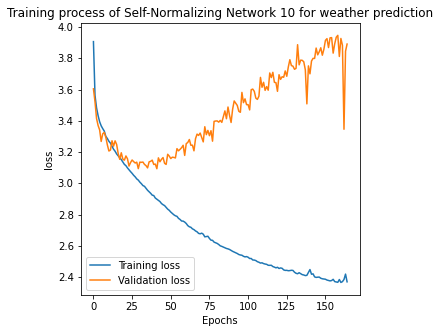

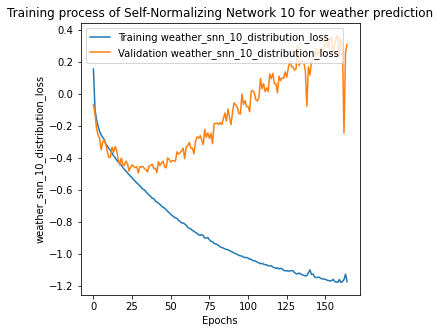

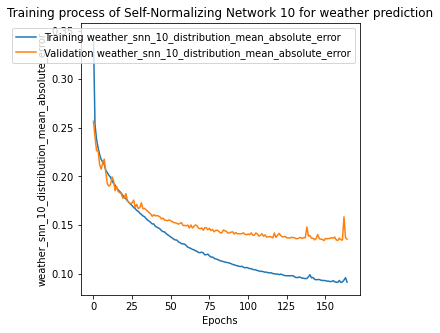


Test quality:
  mean absolute error   = 1.1982097558677507
  mean squared error    = 2.7850903136987886
  median absolute error = 0.8802840183558729
  r2 score              = 0.9738022364851813
  R-AUC MSE             = 0.910266552642439
 Self-Normalizing Network 11 for weather prediction

Model: "weather_snn_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_11_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_11_dropout1 (AlphaD (None, 123)          0           weather_snn_11_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_11_dense1 (Dense)   (None, 512)          63488       weather_snn_11_dropout1[0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8918 - weather_snn_11_distribution_loss: 0.1449 - weather_snn_11_projection_loss: 7.4938 - weather_snn_11_distribution_mean_absolute_error: 0.3416 - val_loss: 3.5447 - val_weather_snn_11_distribution_loss: -0.1297 - val_weather_snn_11_projection_loss: 7.3490 - val_weather_snn_11_distribution_mean_absolute_error: 0.2536
Epoch 2/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.5667 - weather_snn_11_distribution_loss: -0.0959 - weather_snn_11_projection_loss: 7.3252 - weather_snn_11_distribution_mean_absolute_error: 0.2540 - val_loss: 3.4896 - val_weather_snn_11_distribution_loss: -0.1568 - val_weather_snn_11_projection_loss: 7.2927 - val_weather_snn_11_distribution_mean_absolute_error: 0.2498
Epoch 3/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.4864 - weather_snn_11_distribution_loss: -0.1578 - weather_snn_11_projection_loss: 7.2883 - weather_snn_11_distributi

725/725 [==============================] - 37s 50ms/step - loss: 3.1305 - weather_snn_11_distribution_loss: -0.4638 - weather_snn_11_projection_loss: 7.1888 - weather_snn_11_distribution_mean_absolute_error: 0.1796 - val_loss: 3.1443 - val_weather_snn_11_distribution_loss: -0.4483 - val_weather_snn_11_projection_loss: 7.1854 - val_weather_snn_11_distribution_mean_absolute_error: 0.1777
Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1178 - weather_snn_11_distribution_loss: -0.4751 - weather_snn_11_projection_loss: 7.1858 - weather_snn_11_distribution_mean_absolute_error: 0.1779 - val_loss: 3.1984 - val_weather_snn_11_distribution_loss: -0.3937 - val_weather_snn_11_projection_loss: 7.1843 - val_weather_snn_11_distribution_mean_absolute_error: 0.1808
Epoch 23/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1046 - weather_snn_11_distribution_loss: -0.4869 - weather_snn_11_projection_loss: 7.1831 - weather_snn_11_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.9126 - weather_snn_11_distribution_loss: -0.6613 - weather_snn_11_projection_loss: 7.1480 - weather_snn_11_distribution_mean_absolute_error: 0.1495 - val_loss: 3.1078 - val_weather_snn_11_distribution_loss: -0.4753 - val_weather_snn_11_projection_loss: 7.1662 - val_weather_snn_11_distribution_mean_absolute_error: 0.1622
Epoch 42/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.9044 - weather_snn_11_distribution_loss: -0.6686 - weather_snn_11_projection_loss: 7.1461 - weather_snn_11_distribution_mean_absolute_error: 0.1488 - val_loss: 3.0912 - val_weather_snn_11_distribution_loss: -0.4911 - val_weather_snn_11_projection_loss: 7.1646 - val_weather_snn_11_distribution_mean_absolute_error: 0.1573
Epoch 43/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.8930 - weather_snn_11_distribution_loss: -0.6792 - weather_snn_11_projection_loss: 7.1445 - weather_snn_11_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.7410 - weather_snn_11_distribution_loss: -0.8197 - weather_snn_11_projection_loss: 7.1215 - weather_snn_11_distribution_mean_absolute_error: 0.1287 - val_loss: 3.2176 - val_weather_snn_11_distribution_loss: -0.3642 - val_weather_snn_11_projection_loss: 7.1636 - val_weather_snn_11_distribution_mean_absolute_error: 0.1506
Epoch 62/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7342 - weather_snn_11_distribution_loss: -0.8263 - weather_snn_11_projection_loss: 7.1210 - weather_snn_11_distribution_mean_absolute_error: 0.1279 - val_loss: 3.2560 - val_weather_snn_11_distribution_loss: -0.3259 - val_weather_snn_11_projection_loss: 7.1638 - val_weather_snn_11_distribution_mean_absolute_error: 0.1527
Epoch 63/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7237 - weather_snn_11_distribution_loss: -0.8359 - weather_snn_11_projection_loss: 7.1193 - weather_snn_11_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.6128 - weather_snn_11_distribution_loss: -0.9401 - weather_snn_11_projection_loss: 7.1058 - weather_snn_11_distribution_mean_absolute_error: 0.1146 - val_loss: 3.3625 - val_weather_snn_11_distribution_loss: -0.2173 - val_weather_snn_11_projection_loss: 7.1596 - val_weather_snn_11_distribution_mean_absolute_error: 0.1440
Epoch 82/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6091 - weather_snn_11_distribution_loss: -0.9436 - weather_snn_11_projection_loss: 7.1055 - weather_snn_11_distribution_mean_absolute_error: 0.1143 - val_loss: 3.3506 - val_weather_snn_11_distribution_loss: -0.2296 - val_weather_snn_11_projection_loss: 7.1603 - val_weather_snn_11_distribution_mean_absolute_error: 0.1440
Epoch 83/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6075 - weather_snn_11_distribution_loss: -0.9451 - weather_snn_11_projection_loss: 7.1052 - weather_snn_11_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.5180 - weather_snn_11_distribution_loss: -1.0297 - weather_snn_11_projection_loss: 7.0954 - weather_snn_11_distribution_mean_absolute_error: 0.1051 - val_loss: 3.5027 - val_weather_snn_11_distribution_loss: -0.0760 - val_weather_snn_11_projection_loss: 7.1574 - val_weather_snn_11_distribution_mean_absolute_error: 0.1385
Epoch 102/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5167 - weather_snn_11_distribution_loss: -1.0309 - weather_snn_11_projection_loss: 7.0950 - weather_snn_11_distribution_mean_absolute_error: 0.1049 - val_loss: 3.5004 - val_weather_snn_11_distribution_loss: -0.0784 - val_weather_snn_11_projection_loss: 7.1575 - val_weather_snn_11_distribution_mean_absolute_error: 0.1382
Epoch 103/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5115 - weather_snn_11_distribution_loss: -1.0358 - weather_snn_11_projection_loss: 7.0946 - weather_snn_11_distribution_mean_

725/725 [==============================] - 37s 51ms/step - loss: 2.4548 - weather_snn_11_distribution_loss: -1.0889 - weather_snn_11_projection_loss: 7.0874 - weather_snn_11_distribution_mean_absolute_error: 0.0991 - val_loss: 3.7318 - val_weather_snn_11_distribution_loss: 0.1518 - val_weather_snn_11_projection_loss: 7.1601 - val_weather_snn_11_distribution_mean_absolute_error: 0.1393
Epoch 122/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4501 - weather_snn_11_distribution_loss: -1.0937 - weather_snn_11_projection_loss: 7.0876 - weather_snn_11_distribution_mean_absolute_error: 0.0987 - val_loss: 3.6445 - val_weather_snn_11_distribution_loss: 0.0649 - val_weather_snn_11_projection_loss: 7.1592 - val_weather_snn_11_distribution_mean_absolute_error: 0.1372
Epoch 123/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.4503 - weather_snn_11_distribution_loss: -1.0933 - weather_snn_11_projection_loss: 7.0872 - weather_snn_11_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.4116 - weather_snn_11_distribution_loss: -1.1295 - weather_snn_11_projection_loss: 7.0822 - weather_snn_11_distribution_mean_absolute_error: 0.0954 - val_loss: 3.8110 - val_weather_snn_11_distribution_loss: 0.2312 - val_weather_snn_11_projection_loss: 7.1597 - val_weather_snn_11_distribution_mean_absolute_error: 0.1356
Epoch 142/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4161 - weather_snn_11_distribution_loss: -1.1249 - weather_snn_11_projection_loss: 7.0820 - weather_snn_11_distribution_mean_absolute_error: 0.0958 - val_loss: 3.7829 - val_weather_snn_11_distribution_loss: 0.2033 - val_weather_snn_11_projection_loss: 7.1592 - val_weather_snn_11_distribution_mean_absolute_error: 0.1345
Epoch 143/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4024 - weather_snn_11_distribution_loss: -1.1381 - weather_snn_11_projection_loss: 7.0810 - weather_snn_11_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.3617 - weather_snn_11_distribution_loss: -1.1764 - weather_snn_11_projection_loss: 7.0763 - weather_snn_11_distribution_mean_absolute_error: 0.0909 - val_loss: 3.8973 - val_weather_snn_11_distribution_loss: 0.3176 - val_weather_snn_11_projection_loss: 7.1593 - val_weather_snn_11_distribution_mean_absolute_error: 0.1338
Epoch 162/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3591 - weather_snn_11_distribution_loss: -1.1789 - weather_snn_11_projection_loss: 7.0759 - weather_snn_11_distribution_mean_absolute_error: 0.0908 - val_loss: 3.8277 - val_weather_snn_11_distribution_loss: 0.2488 - val_weather_snn_11_projection_loss: 7.1578 - val_weather_snn_11_distribution_mean_absolute_error: 0.1348
Epoch 163/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3568 - weather_snn_11_distribution_loss: -1.1813 - weather_snn_11_projection_loss: 7.0761 - weather_snn_11_distribution_mean_ab

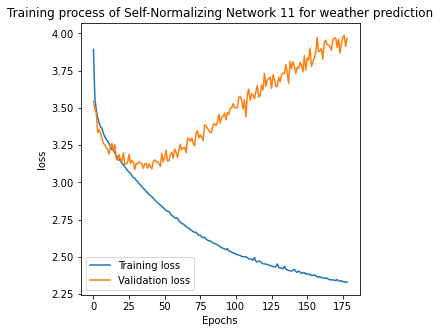

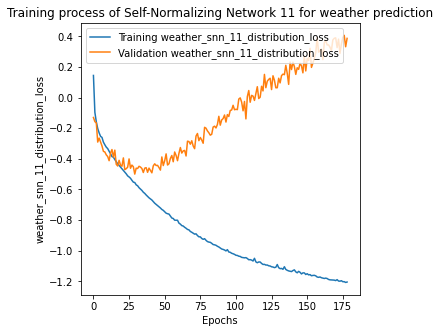

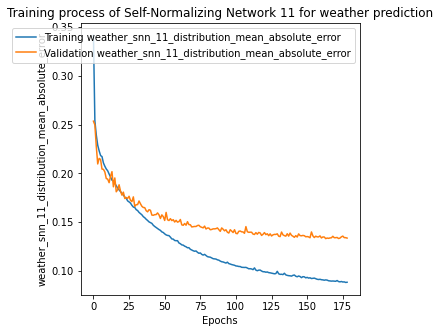


Test quality:
  mean absolute error   = 1.2023736515301928
  mean squared error    = 2.8058236998270423
  median absolute error = 0.888427273493642
  r2 score              = 0.9736073694780502
  R-AUC MSE             = 0.9124718412453057
 Self-Normalizing Network 12 for weather prediction

Model: "weather_snn_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_12_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_12_dropout1 (AlphaD (None, 123)          0           weather_snn_12_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_12_dense1 (Dense)   (None, 512)          63488       weather_snn_12_dropout1[0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.9364 - weather_snn_12_distribution_loss: 0.1793 - weather_snn_12_projection_loss: 7.5141 - weather_snn_12_distribution_mean_absolute_error: 0.3552 - val_loss: 3.5186 - val_weather_snn_12_distribution_loss: -0.1566 - val_weather_snn_12_projection_loss: 7.3505 - val_weather_snn_12_distribution_mean_absolute_error: 0.2438
Epoch 2/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.5865 - weather_snn_12_distribution_loss: -0.0770 - weather_snn_12_projection_loss: 7.3270 - weather_snn_12_distribution_mean_absolute_error: 0.2586 - val_loss: 3.9394 - val_weather_snn_12_distribution_loss: 0.2809 - val_weather_snn_12_projection_loss: 7.3171 - val_weather_snn_12_distribution_mean_absolute_error: 0.3981
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.9085 - weather_snn_12_distribution_loss: 0.2331 - weather_snn_12_projection_loss: 7.3507 - weather_snn_12_distribution

725/725 [==============================] - 37s 51ms/step - loss: 3.2348 - weather_snn_12_distribution_loss: -0.3652 - weather_snn_12_projection_loss: 7.2001 - weather_snn_12_distribution_mean_absolute_error: 0.1968 - val_loss: 3.2517 - val_weather_snn_12_distribution_loss: -0.3452 - val_weather_snn_12_projection_loss: 7.1939 - val_weather_snn_12_distribution_mean_absolute_error: 0.1965
Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.2148 - weather_snn_12_distribution_loss: -0.3833 - weather_snn_12_projection_loss: 7.1962 - weather_snn_12_distribution_mean_absolute_error: 0.1938 - val_loss: 3.2049 - val_weather_snn_12_distribution_loss: -0.3899 - val_weather_snn_12_projection_loss: 7.1897 - val_weather_snn_12_distribution_mean_absolute_error: 0.1859
Epoch 23/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.2080 - weather_snn_12_distribution_loss: -0.3884 - weather_snn_12_projection_loss: 7.1928 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 3.0203 - weather_snn_12_distribution_loss: -0.5474 - weather_snn_12_projection_loss: 7.1354 - weather_snn_12_distribution_mean_absolute_error: 0.1666 - val_loss: 3.0972 - val_weather_snn_12_distribution_loss: -0.4814 - val_weather_snn_12_projection_loss: 7.1572 - val_weather_snn_12_distribution_mean_absolute_error: 0.1693
Epoch 42/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0117 - weather_snn_12_distribution_loss: -0.5547 - weather_snn_12_projection_loss: 7.1329 - weather_snn_12_distribution_mean_absolute_error: 0.1655 - val_loss: 3.0785 - val_weather_snn_12_distribution_loss: -0.4982 - val_weather_snn_12_projection_loss: 7.1535 - val_weather_snn_12_distribution_mean_absolute_error: 0.1674
Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.0038 - weather_snn_12_distribution_loss: -0.5612 - weather_snn_12_projection_loss: 7.1301 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.8513 - weather_snn_12_distribution_loss: -0.6891 - weather_snn_12_projection_loss: 7.0809 - weather_snn_12_distribution_mean_absolute_error: 0.1457 - val_loss: 3.1291 - val_weather_snn_12_distribution_loss: -0.4486 - val_weather_snn_12_projection_loss: 7.1554 - val_weather_snn_12_distribution_mean_absolute_error: 0.1618
Epoch 62/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8476 - weather_snn_12_distribution_loss: -0.6920 - weather_snn_12_projection_loss: 7.0793 - weather_snn_12_distribution_mean_absolute_error: 0.1454 - val_loss: 3.1162 - val_weather_snn_12_distribution_loss: -0.4604 - val_weather_snn_12_projection_loss: 7.1533 - val_weather_snn_12_distribution_mean_absolute_error: 0.1563
Epoch 63/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.8378 - weather_snn_12_distribution_loss: -0.7002 - weather_snn_12_projection_loss: 7.0761 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.7006 - weather_snn_12_distribution_loss: -0.8172 - weather_snn_12_projection_loss: 7.0357 - weather_snn_12_distribution_mean_absolute_error: 0.1289 - val_loss: 3.2609 - val_weather_snn_12_distribution_loss: -0.3172 - val_weather_snn_12_projection_loss: 7.1561 - val_weather_snn_12_distribution_mean_absolute_error: 0.1479
Epoch 82/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6933 - weather_snn_12_distribution_loss: -0.8240 - weather_snn_12_projection_loss: 7.0347 - weather_snn_12_distribution_mean_absolute_error: 0.1282 - val_loss: 3.2564 - val_weather_snn_12_distribution_loss: -0.3215 - val_weather_snn_12_projection_loss: 7.1556 - val_weather_snn_12_distribution_mean_absolute_error: 0.1479
Epoch 83/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6986 - weather_snn_12_distribution_loss: -0.8188 - weather_snn_12_projection_loss: 7.0349 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.5758 - weather_snn_12_distribution_loss: -0.9271 - weather_snn_12_projection_loss: 7.0058 - weather_snn_12_distribution_mean_absolute_error: 0.1160 - val_loss: 3.3797 - val_weather_snn_12_distribution_loss: -0.2023 - val_weather_snn_12_projection_loss: 7.1641 - val_weather_snn_12_distribution_mean_absolute_error: 0.1443
Epoch 102/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5694 - weather_snn_12_distribution_loss: -0.9327 - weather_snn_12_projection_loss: 7.0043 - weather_snn_12_distribution_mean_absolute_error: 0.1154 - val_loss: 3.3901 - val_weather_snn_12_distribution_loss: -0.1916 - val_weather_snn_12_projection_loss: 7.1633 - val_weather_snn_12_distribution_mean_absolute_error: 0.1431
Epoch 103/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5655 - weather_snn_12_distribution_loss: -0.9362 - weather_snn_12_projection_loss: 7.0034 - weather_snn_12_distribution_mean_

725/725 [==============================] - 37s 50ms/step - loss: 2.4737 - weather_snn_12_distribution_loss: -1.0191 - weather_snn_12_projection_loss: 6.9856 - weather_snn_12_distribution_mean_absolute_error: 0.1062 - val_loss: 3.6846 - val_weather_snn_12_distribution_loss: 0.0974 - val_weather_snn_12_projection_loss: 7.1743 - val_weather_snn_12_distribution_mean_absolute_error: 0.1429
Epoch 122/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4691 - weather_snn_12_distribution_loss: -1.0232 - weather_snn_12_projection_loss: 6.9846 - weather_snn_12_distribution_mean_absolute_error: 0.1058 - val_loss: 3.5363 - val_weather_snn_12_distribution_loss: -0.0515 - val_weather_snn_12_projection_loss: 7.1756 - val_weather_snn_12_distribution_mean_absolute_error: 0.1465
Epoch 123/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4679 - weather_snn_12_distribution_loss: -1.0245 - weather_snn_12_projection_loss: 6.9849 - weather_snn_12_distribution_mean_a

725/725 [==============================] - 36s 50ms/step - loss: 2.3971 - weather_snn_12_distribution_loss: -1.0894 - weather_snn_12_projection_loss: 6.9731 - weather_snn_12_distribution_mean_absolute_error: 0.0992 - val_loss: 3.7552 - val_weather_snn_12_distribution_loss: 0.1638 - val_weather_snn_12_projection_loss: 7.1830 - val_weather_snn_12_distribution_mean_absolute_error: 0.1424
Epoch 142/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3904 - weather_snn_12_distribution_loss: -1.0957 - weather_snn_12_projection_loss: 6.9721 - weather_snn_12_distribution_mean_absolute_error: 0.0986 - val_loss: 3.7739 - val_weather_snn_12_distribution_loss: 0.1837 - val_weather_snn_12_projection_loss: 7.1804 - val_weather_snn_12_distribution_mean_absolute_error: 0.1403
Epoch 143/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3854 - weather_snn_12_distribution_loss: -1.1005 - weather_snn_12_projection_loss: 6.9716 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3364 - weather_snn_12_distribution_loss: -1.1457 - weather_snn_12_projection_loss: 6.9641 - weather_snn_12_distribution_mean_absolute_error: 0.0941 - val_loss: 3.8883 - val_weather_snn_12_distribution_loss: 0.2974 - val_weather_snn_12_projection_loss: 7.1817 - val_weather_snn_12_distribution_mean_absolute_error: 0.1374
Epoch 162/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.3330 - weather_snn_12_distribution_loss: -1.1490 - weather_snn_12_projection_loss: 6.9641 - weather_snn_12_distribution_mean_absolute_error: 0.0938 - val_loss: 3.9082 - val_weather_snn_12_distribution_loss: 0.3171 - val_weather_snn_12_projection_loss: 7.1822 - val_weather_snn_12_distribution_mean_absolute_error: 0.1366
Epoch 163/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3243 - weather_snn_12_distribution_loss: -1.1568 - weather_snn_12_projection_loss: 6.9621 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.2838 - weather_snn_12_distribution_loss: -1.1946 - weather_snn_12_projection_loss: 6.9567 - weather_snn_12_distribution_mean_absolute_error: 0.0896 - val_loss: 4.2479 - val_weather_snn_12_distribution_loss: 0.6521 - val_weather_snn_12_projection_loss: 7.1916 - val_weather_snn_12_distribution_mean_absolute_error: 0.1372
Epoch 182/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2846 - weather_snn_12_distribution_loss: -1.1941 - weather_snn_12_projection_loss: 6.9574 - weather_snn_12_distribution_mean_absolute_error: 0.0897 - val_loss: 4.1176 - val_weather_snn_12_distribution_loss: 0.5205 - val_weather_snn_12_projection_loss: 7.1943 - val_weather_snn_12_distribution_mean_absolute_error: 0.1369
Epoch 183/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2761 - weather_snn_12_distribution_loss: -1.2019 - weather_snn_12_projection_loss: 6.9559 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.2499 - weather_snn_12_distribution_loss: -1.2264 - weather_snn_12_projection_loss: 6.9526 - weather_snn_12_distribution_mean_absolute_error: 0.0870 - val_loss: 4.1961 - val_weather_snn_12_distribution_loss: 0.6004 - val_weather_snn_12_projection_loss: 7.1914 - val_weather_snn_12_distribution_mean_absolute_error: 0.1358
Epoch 202/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2433 - weather_snn_12_distribution_loss: -1.2324 - weather_snn_12_projection_loss: 6.9513 - weather_snn_12_distribution_mean_absolute_error: 0.0864 - val_loss: 4.2397 - val_weather_snn_12_distribution_loss: 0.6435 - val_weather_snn_12_projection_loss: 7.1925 - val_weather_snn_12_distribution_mean_absolute_error: 0.1378
Epoch 203/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2402 - weather_snn_12_distribution_loss: -1.2355 - weather_snn_12_projection_loss: 6.9513 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.2115 - weather_snn_12_distribution_loss: -1.2621 - weather_snn_12_projection_loss: 6.9471 - weather_snn_12_distribution_mean_absolute_error: 0.0838 - val_loss: 4.3286 - val_weather_snn_12_distribution_loss: 0.7315 - val_weather_snn_12_projection_loss: 7.1943 - val_weather_snn_12_distribution_mean_absolute_error: 0.1362
Epoch 222/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2137 - weather_snn_12_distribution_loss: -1.2604 - weather_snn_12_projection_loss: 6.9481 - weather_snn_12_distribution_mean_absolute_error: 0.0841 - val_loss: 4.2757 - val_weather_snn_12_distribution_loss: 0.6797 - val_weather_snn_12_projection_loss: 7.1919 - val_weather_snn_12_distribution_mean_absolute_error: 0.1344
Epoch 223/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2079 - weather_snn_12_distribution_loss: -1.2656 - weather_snn_12_projection_loss: 6.9470 - weather_snn_12_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.1963 - weather_snn_12_distribution_loss: -1.2764 - weather_snn_12_projection_loss: 6.9453 - weather_snn_12_distribution_mean_absolute_error: 0.0828 - val_loss: 4.5359 - val_weather_snn_12_distribution_loss: 0.9375 - val_weather_snn_12_projection_loss: 7.1968 - val_weather_snn_12_distribution_mean_absolute_error: 0.1335
Epoch 242/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.1838 - weather_snn_12_distribution_loss: -1.2882 - weather_snn_12_projection_loss: 6.9439 - weather_snn_12_distribution_mean_absolute_error: 0.0820 - val_loss: 4.6513 - val_weather_snn_12_distribution_loss: 1.0532 - val_weather_snn_12_projection_loss: 7.1961 - val_weather_snn_12_distribution_mean_absolute_error: 0.1329
Epoch 243/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.1843 - weather_snn_12_distribution_loss: -1.2879 - weather_snn_12_projection_loss: 6.9444 - weather_snn_12_distribution_mean_ab

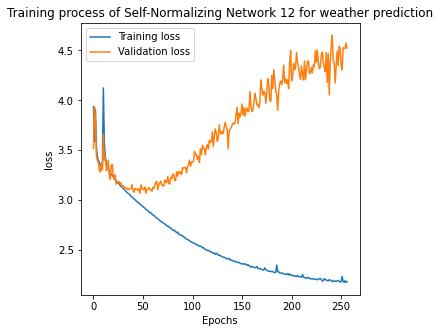

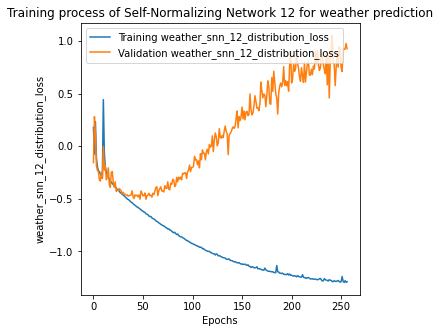

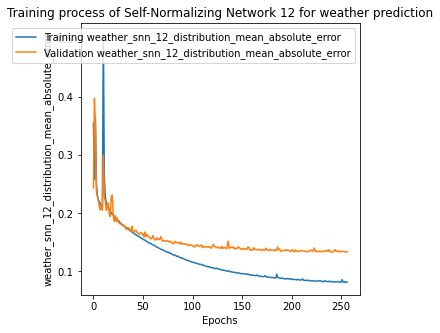


Test quality:
  mean absolute error   = 1.219397425954362
  mean squared error    = 2.9569288419942867
  median absolute error = 0.8941441110952262
  r2 score              = 0.972210011903476
  R-AUC MSE             = 1.0025662451597164
 Self-Normalizing Network 13 for weather prediction

Model: "weather_snn_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_13_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_13_dropout1 (AlphaD (None, 123)          0           weather_snn_13_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_13_dense1 (Dense)   (None, 512)          63488       weather_snn_13_dropout1[0]

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8697 - weather_snn_13_distribution_loss: 0.1271 - weather_snn_13_projection_loss: 7.4850 - weather_snn_13_distribution_mean_absolute_error: 0.3342 - val_loss: 3.5777 - val_weather_snn_13_distribution_loss: -0.0900 - val_weather_snn_13_projection_loss: 7.3353 - val_weather_snn_13_distribution_mean_absolute_error: 0.2475
Epoch 2/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.5568 - weather_snn_13_distribution_loss: -0.1044 - weather_snn_13_projection_loss: 7.3224 - weather_snn_13_distribution_mean_absolute_error: 0.2520 - val_loss: 3.6233 - val_weather_snn_13_distribution_loss: -0.0220 - val_weather_snn_13_projection_loss: 7.2907 - val_weather_snn_13_distribution_mean_absolute_error: 0.2711
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4864 - weather_snn_13_distribution_loss: -0.1571 - weather_snn_13_projection_loss: 7.2871 - weather_snn_13_distributi

725/725 [==============================] - 36s 50ms/step - loss: 3.1257 - weather_snn_13_distribution_loss: -0.4681 - weather_snn_13_projection_loss: 7.1875 - weather_snn_13_distribution_mean_absolute_error: 0.1789 - val_loss: 3.1605 - val_weather_snn_13_distribution_loss: -0.4335 - val_weather_snn_13_projection_loss: 7.1882 - val_weather_snn_13_distribution_mean_absolute_error: 0.1808
Epoch 22/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1162 - weather_snn_13_distribution_loss: -0.4763 - weather_snn_13_projection_loss: 7.1850 - weather_snn_13_distribution_mean_absolute_error: 0.1775 - val_loss: 3.1656 - val_weather_snn_13_distribution_loss: -0.4274 - val_weather_snn_13_projection_loss: 7.1861 - val_weather_snn_13_distribution_mean_absolute_error: 0.1812
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1010 - weather_snn_13_distribution_loss: -0.4901 - weather_snn_13_projection_loss: 7.1823 - weather_snn_13_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.9084 - weather_snn_13_distribution_loss: -0.6652 - weather_snn_13_projection_loss: 7.1472 - weather_snn_13_distribution_mean_absolute_error: 0.1489 - val_loss: 3.1303 - val_weather_snn_13_distribution_loss: -0.4536 - val_weather_snn_13_projection_loss: 7.1679 - val_weather_snn_13_distribution_mean_absolute_error: 0.1591
Epoch 42/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8984 - weather_snn_13_distribution_loss: -0.6741 - weather_snn_13_projection_loss: 7.1451 - weather_snn_13_distribution_mean_absolute_error: 0.1477 - val_loss: 3.0859 - val_weather_snn_13_distribution_loss: -0.4970 - val_weather_snn_13_projection_loss: 7.1659 - val_weather_snn_13_distribution_mean_absolute_error: 0.1590
Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8909 - weather_snn_13_distribution_loss: -0.6811 - weather_snn_13_projection_loss: 7.1439 - weather_snn_13_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.7434 - weather_snn_13_distribution_loss: -0.8179 - weather_snn_13_projection_loss: 7.1226 - weather_snn_13_distribution_mean_absolute_error: 0.1291 - val_loss: 3.2082 - val_weather_snn_13_distribution_loss: -0.3747 - val_weather_snn_13_projection_loss: 7.1658 - val_weather_snn_13_distribution_mean_absolute_error: 0.1548
Epoch 62/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.7294 - weather_snn_13_distribution_loss: -0.8309 - weather_snn_13_projection_loss: 7.1205 - weather_snn_13_distribution_mean_absolute_error: 0.1273 - val_loss: 3.2194 - val_weather_snn_13_distribution_loss: -0.3624 - val_weather_snn_13_projection_loss: 7.1635 - val_weather_snn_13_distribution_mean_absolute_error: 0.1507
Epoch 63/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7213 - weather_snn_13_distribution_loss: -0.8385 - weather_snn_13_projection_loss: 7.1196 - weather_snn_13_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.6103 - weather_snn_13_distribution_loss: -0.9423 - weather_snn_13_projection_loss: 7.1054 - weather_snn_13_distribution_mean_absolute_error: 0.1143 - val_loss: 3.3831 - val_weather_snn_13_distribution_loss: -0.1977 - val_weather_snn_13_projection_loss: 7.1616 - val_weather_snn_13_distribution_mean_absolute_error: 0.1422
Epoch 82/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6032 - weather_snn_13_distribution_loss: -0.9491 - weather_snn_13_projection_loss: 7.1048 - weather_snn_13_distribution_mean_absolute_error: 0.1137 - val_loss: 3.3673 - val_weather_snn_13_distribution_loss: -0.2134 - val_weather_snn_13_projection_loss: 7.1614 - val_weather_snn_13_distribution_mean_absolute_error: 0.1443
Epoch 83/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5970 - weather_snn_13_distribution_loss: -0.9550 - weather_snn_13_projection_loss: 7.1039 - weather_snn_13_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.5200 - weather_snn_13_distribution_loss: -1.0275 - weather_snn_13_projection_loss: 7.0949 - weather_snn_13_distribution_mean_absolute_error: 0.1052 - val_loss: 3.4834 - val_weather_snn_13_distribution_loss: -0.0965 - val_weather_snn_13_projection_loss: 7.1599 - val_weather_snn_13_distribution_mean_absolute_error: 0.1397
Epoch 102/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5138 - weather_snn_13_distribution_loss: -1.0333 - weather_snn_13_projection_loss: 7.0943 - weather_snn_13_distribution_mean_absolute_error: 0.1048 - val_loss: 3.4812 - val_weather_snn_13_distribution_loss: -0.0986 - val_weather_snn_13_projection_loss: 7.1596 - val_weather_snn_13_distribution_mean_absolute_error: 0.1395
Epoch 103/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5151 - weather_snn_13_distribution_loss: -1.0322 - weather_snn_13_projection_loss: 7.0945 - weather_snn_13_distribution_mean_

725/725 [==============================] - 36s 50ms/step - loss: 2.4499 - weather_snn_13_distribution_loss: -1.0937 - weather_snn_13_projection_loss: 7.0872 - weather_snn_13_distribution_mean_absolute_error: 0.0985 - val_loss: 3.7280 - val_weather_snn_13_distribution_loss: 0.1468 - val_weather_snn_13_projection_loss: 7.1625 - val_weather_snn_13_distribution_mean_absolute_error: 0.1373
Epoch 122/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4491 - weather_snn_13_distribution_loss: -1.0943 - weather_snn_13_projection_loss: 7.0866 - weather_snn_13_distribution_mean_absolute_error: 0.0986 - val_loss: 3.6448 - val_weather_snn_13_distribution_loss: 0.0626 - val_weather_snn_13_projection_loss: 7.1644 - val_weather_snn_13_distribution_mean_absolute_error: 0.1410
Epoch 123/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4411 - weather_snn_13_distribution_loss: -1.1020 - weather_snn_13_projection_loss: 7.0861 - weather_snn_13_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3992 - weather_snn_13_distribution_loss: -1.1413 - weather_snn_13_projection_loss: 7.0809 - weather_snn_13_distribution_mean_absolute_error: 0.0940 - val_loss: 3.7782 - val_weather_snn_13_distribution_loss: 0.1975 - val_weather_snn_13_projection_loss: 7.1613 - val_weather_snn_13_distribution_mean_absolute_error: 0.1356
Epoch 142/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3963 - weather_snn_13_distribution_loss: -1.1440 - weather_snn_13_projection_loss: 7.0807 - weather_snn_13_distribution_mean_absolute_error: 0.0938 - val_loss: 3.7777 - val_weather_snn_13_distribution_loss: 0.1966 - val_weather_snn_13_projection_loss: 7.1621 - val_weather_snn_13_distribution_mean_absolute_error: 0.1368
Epoch 143/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3911 - weather_snn_13_distribution_loss: -1.1489 - weather_snn_13_projection_loss: 7.0800 - weather_snn_13_distribution_mean_ab

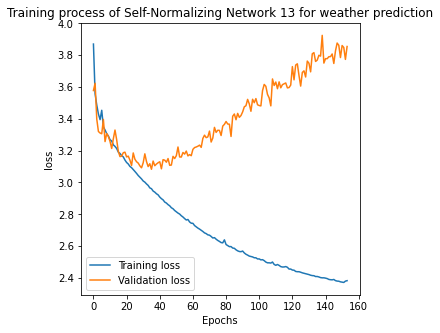

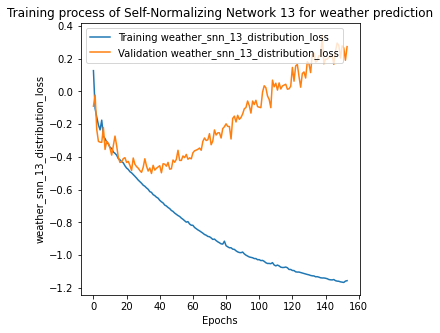

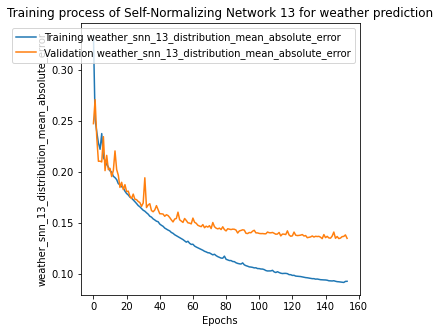


Test quality:
  mean absolute error   = 1.214450814287927
  mean squared error    = 2.8382955602038566
  median absolute error = 0.8956272635109599
  r2 score              = 0.9732989433769883
  R-AUC MSE             = 0.9226052050248134
 Self-Normalizing Network 14 for weather prediction

Model: "weather_snn_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_14_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_14_dropout1 (AlphaD (None, 123)          0           weather_snn_14_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_14_dense1 (Dense)   (None, 512)          63488       weather_snn_14_dropout1[0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8937 - weather_snn_14_distribution_loss: 0.1452 - weather_snn_14_projection_loss: 7.4969 - weather_snn_14_distribution_mean_absolute_error: 0.3410 - val_loss: 3.5634 - val_weather_snn_14_distribution_loss: -0.1109 - val_weather_snn_14_projection_loss: 7.3485 - val_weather_snn_14_distribution_mean_absolute_error: 0.2505
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5584 - weather_snn_14_distribution_loss: -0.1039 - weather_snn_14_projection_loss: 7.3246 - weather_snn_14_distribution_mean_absolute_error: 0.2519 - val_loss: 3.4782 - val_weather_snn_14_distribution_loss: -0.1696 - val_weather_snn_14_projection_loss: 7.2955 - val_weather_snn_14_distribution_mean_absolute_error: 0.2359
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4791 - weather_snn_14_distribution_loss: -0.1653 - weather_snn_14_projection_loss: 7.2888 - weather_snn_14_distributi

725/725 [==============================] - 36s 50ms/step - loss: 3.1255 - weather_snn_14_distribution_loss: -0.4692 - weather_snn_14_projection_loss: 7.1895 - weather_snn_14_distribution_mean_absolute_error: 0.1786 - val_loss: 3.1581 - val_weather_snn_14_distribution_loss: -0.4379 - val_weather_snn_14_projection_loss: 7.1921 - val_weather_snn_14_distribution_mean_absolute_error: 0.1800
Epoch 22/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.1151 - weather_snn_14_distribution_loss: -0.4782 - weather_snn_14_projection_loss: 7.1866 - weather_snn_14_distribution_mean_absolute_error: 0.1771 - val_loss: 3.1737 - val_weather_snn_14_distribution_loss: -0.4211 - val_weather_snn_14_projection_loss: 7.1897 - val_weather_snn_14_distribution_mean_absolute_error: 0.1822
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1003 - weather_snn_14_distribution_loss: -0.4917 - weather_snn_14_projection_loss: 7.1840 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 49ms/step - loss: 2.9089 - weather_snn_14_distribution_loss: -0.6654 - weather_snn_14_projection_loss: 7.1486 - weather_snn_14_distribution_mean_absolute_error: 0.1488 - val_loss: 3.1262 - val_weather_snn_14_distribution_loss: -0.4603 - val_weather_snn_14_projection_loss: 7.1730 - val_weather_snn_14_distribution_mean_absolute_error: 0.1597
Epoch 42/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.8997 - weather_snn_14_distribution_loss: -0.6743 - weather_snn_14_projection_loss: 7.1478 - weather_snn_14_distribution_mean_absolute_error: 0.1475 - val_loss: 3.1206 - val_weather_snn_14_distribution_loss: -0.4646 - val_weather_snn_14_projection_loss: 7.1704 - val_weather_snn_14_distribution_mean_absolute_error: 0.1568
Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8906 - weather_snn_14_distribution_loss: -0.6825 - weather_snn_14_projection_loss: 7.1462 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 49ms/step - loss: 2.7404 - weather_snn_14_distribution_loss: -0.8227 - weather_snn_14_projection_loss: 7.1262 - weather_snn_14_distribution_mean_absolute_error: 0.1283 - val_loss: 3.2304 - val_weather_snn_14_distribution_loss: -0.3552 - val_weather_snn_14_projection_loss: 7.1712 - val_weather_snn_14_distribution_mean_absolute_error: 0.1514
Epoch 62/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7313 - weather_snn_14_distribution_loss: -0.8310 - weather_snn_14_projection_loss: 7.1246 - weather_snn_14_distribution_mean_absolute_error: 0.1272 - val_loss: 3.2882 - val_weather_snn_14_distribution_loss: -0.2972 - val_weather_snn_14_projection_loss: 7.1709 - val_weather_snn_14_distribution_mean_absolute_error: 0.1502
Epoch 63/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7298 - weather_snn_14_distribution_loss: -0.8325 - weather_snn_14_projection_loss: 7.1245 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.6174 - weather_snn_14_distribution_loss: -0.9384 - weather_snn_14_projection_loss: 7.1115 - weather_snn_14_distribution_mean_absolute_error: 0.1148 - val_loss: 3.3846 - val_weather_snn_14_distribution_loss: -0.1989 - val_weather_snn_14_projection_loss: 7.1671 - val_weather_snn_14_distribution_mean_absolute_error: 0.1451
Epoch 82/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6091 - weather_snn_14_distribution_loss: -0.9463 - weather_snn_14_projection_loss: 7.1107 - weather_snn_14_distribution_mean_absolute_error: 0.1139 - val_loss: 3.4309 - val_weather_snn_14_distribution_loss: -0.1528 - val_weather_snn_14_projection_loss: 7.1674 - val_weather_snn_14_distribution_mean_absolute_error: 0.1431
Epoch 83/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6031 - weather_snn_14_distribution_loss: -0.9519 - weather_snn_14_projection_loss: 7.1101 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.5286 - weather_snn_14_distribution_loss: -1.0224 - weather_snn_14_projection_loss: 7.1020 - weather_snn_14_distribution_mean_absolute_error: 0.1059 - val_loss: 3.5081 - val_weather_snn_14_distribution_loss: -0.0750 - val_weather_snn_14_projection_loss: 7.1662 - val_weather_snn_14_distribution_mean_absolute_error: 0.1432
Epoch 102/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5233 - weather_snn_14_distribution_loss: -1.0274 - weather_snn_14_projection_loss: 7.1014 - weather_snn_14_distribution_mean_absolute_error: 0.1053 - val_loss: 3.5145 - val_weather_snn_14_distribution_loss: -0.0677 - val_weather_snn_14_projection_loss: 7.1643 - val_weather_snn_14_distribution_mean_absolute_error: 0.1396
Epoch 103/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5195 - weather_snn_14_distribution_loss: -1.0309 - weather_snn_14_projection_loss: 7.1007 - weather_snn_14_distribution_mean_

725/725 [==============================] - 36s 49ms/step - loss: 2.4579 - weather_snn_14_distribution_loss: -1.0885 - weather_snn_14_projection_loss: 7.0929 - weather_snn_14_distribution_mean_absolute_error: 0.0992 - val_loss: 3.7011 - val_weather_snn_14_distribution_loss: 0.1165 - val_weather_snn_14_projection_loss: 7.1692 - val_weather_snn_14_distribution_mean_absolute_error: 0.1391
Epoch 122/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4564 - weather_snn_14_distribution_loss: -1.0901 - weather_snn_14_projection_loss: 7.0931 - weather_snn_14_distribution_mean_absolute_error: 0.0989 - val_loss: 3.7365 - val_weather_snn_14_distribution_loss: 0.1535 - val_weather_snn_14_projection_loss: 7.1659 - val_weather_snn_14_distribution_mean_absolute_error: 0.1387
Epoch 123/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4498 - weather_snn_14_distribution_loss: -1.0962 - weather_snn_14_projection_loss: 7.0919 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.4047 - weather_snn_14_distribution_loss: -1.1381 - weather_snn_14_projection_loss: 7.0857 - weather_snn_14_distribution_mean_absolute_error: 0.0944 - val_loss: 3.8898 - val_weather_snn_14_distribution_loss: 0.3069 - val_weather_snn_14_projection_loss: 7.1658 - val_weather_snn_14_distribution_mean_absolute_error: 0.1362
Epoch 142/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4031 - weather_snn_14_distribution_loss: -1.1396 - weather_snn_14_projection_loss: 7.0854 - weather_snn_14_distribution_mean_absolute_error: 0.0942 - val_loss: 3.8280 - val_weather_snn_14_distribution_loss: 0.2450 - val_weather_snn_14_projection_loss: 7.1660 - val_weather_snn_14_distribution_mean_absolute_error: 0.1357
Epoch 143/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.4102 - weather_snn_14_distribution_loss: -1.1325 - weather_snn_14_projection_loss: 7.0854 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3687 - weather_snn_14_distribution_loss: -1.1714 - weather_snn_14_projection_loss: 7.0801 - weather_snn_14_distribution_mean_absolute_error: 0.0913 - val_loss: 3.8682 - val_weather_snn_14_distribution_loss: 0.2855 - val_weather_snn_14_projection_loss: 7.1654 - val_weather_snn_14_distribution_mean_absolute_error: 0.1350
Epoch 162/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3624 - weather_snn_14_distribution_loss: -1.1775 - weather_snn_14_projection_loss: 7.0798 - weather_snn_14_distribution_mean_absolute_error: 0.0907 - val_loss: 3.9146 - val_weather_snn_14_distribution_loss: 0.3325 - val_weather_snn_14_projection_loss: 7.1641 - val_weather_snn_14_distribution_mean_absolute_error: 0.1344
Epoch 163/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3648 - weather_snn_14_distribution_loss: -1.1748 - weather_snn_14_projection_loss: 7.0794 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3312 - weather_snn_14_distribution_loss: -1.2065 - weather_snn_14_projection_loss: 7.0753 - weather_snn_14_distribution_mean_absolute_error: 0.0881 - val_loss: 4.1191 - val_weather_snn_14_distribution_loss: 0.5358 - val_weather_snn_14_projection_loss: 7.1667 - val_weather_snn_14_distribution_mean_absolute_error: 0.1339
Epoch 182/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3328 - weather_snn_14_distribution_loss: -1.2049 - weather_snn_14_projection_loss: 7.0753 - weather_snn_14_distribution_mean_absolute_error: 0.0884 - val_loss: 4.0854 - val_weather_snn_14_distribution_loss: 0.5014 - val_weather_snn_14_projection_loss: 7.1681 - val_weather_snn_14_distribution_mean_absolute_error: 0.1351
Epoch 183/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3272 - weather_snn_14_distribution_loss: -1.2102 - weather_snn_14_projection_loss: 7.0747 - weather_snn_14_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3005 - weather_snn_14_distribution_loss: -1.2351 - weather_snn_14_projection_loss: 7.0712 - weather_snn_14_distribution_mean_absolute_error: 0.0856 - val_loss: 4.1742 - val_weather_snn_14_distribution_loss: 0.5909 - val_weather_snn_14_projection_loss: 7.1665 - val_weather_snn_14_distribution_mean_absolute_error: 0.1327
Epoch 00201: early stopping



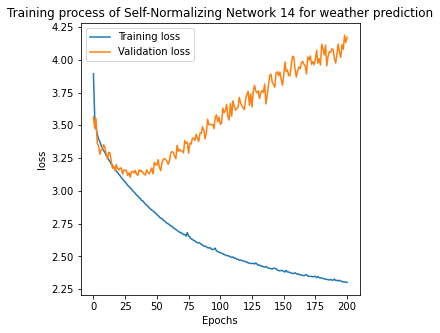

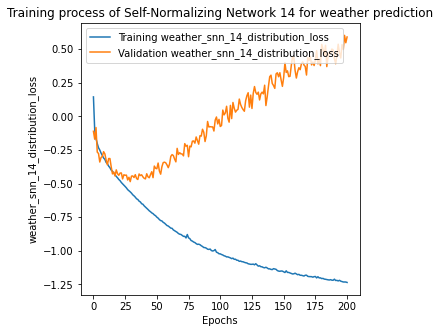

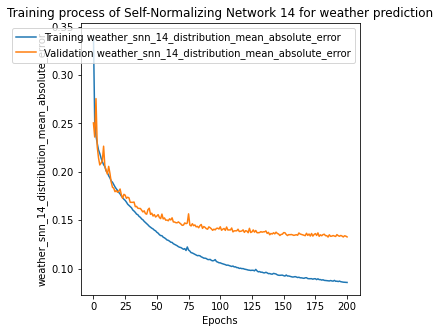


Test quality:
  mean absolute error   = 1.1992619247247192
  mean squared error    = 2.845472314853163
  median absolute error = 0.8799532256634066
  r2 score              = 0.9732344857060913
  R-AUC MSE             = 0.9148314819619517
 Self-Normalizing Network 15 for weather prediction

Model: "weather_snn_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_15_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_15_dropout1 (AlphaD (None, 123)          0           weather_snn_15_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_15_dense1 (Dense)   (None, 512)          63488       weather_snn_15_dropout1[0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8677 - weather_snn_15_distribution_loss: 0.1189 - weather_snn_15_projection_loss: 7.4975 - weather_snn_15_distribution_mean_absolute_error: 0.3321 - val_loss: 3.5546 - val_weather_snn_15_distribution_loss: -0.1245 - val_weather_snn_15_projection_loss: 7.3583 - val_weather_snn_15_distribution_mean_absolute_error: 0.2542
Epoch 2/1000
725/725 [==============================] - 35s 49ms/step - loss: 3.5450 - weather_snn_15_distribution_loss: -0.1187 - weather_snn_15_projection_loss: 7.3275 - weather_snn_15_distribution_mean_absolute_error: 0.2483 - val_loss: 3.5598 - val_weather_snn_15_distribution_loss: -0.0861 - val_weather_snn_15_projection_loss: 7.2917 - val_weather_snn_15_distribution_mean_absolute_error: 0.2630
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4690 - weather_snn_15_distribution_loss: -0.1745 - weather_snn_15_projection_loss: 7.2870 - weather_snn_15_distributi

725/725 [==============================] - 37s 51ms/step - loss: 3.1140 - weather_snn_15_distribution_loss: -0.4804 - weather_snn_15_projection_loss: 7.1888 - weather_snn_15_distribution_mean_absolute_error: 0.1770 - val_loss: 3.1739 - val_weather_snn_15_distribution_loss: -0.4204 - val_weather_snn_15_projection_loss: 7.1885 - val_weather_snn_15_distribution_mean_absolute_error: 0.1808
Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1041 - weather_snn_15_distribution_loss: -0.4891 - weather_snn_15_projection_loss: 7.1864 - weather_snn_15_distribution_mean_absolute_error: 0.1757 - val_loss: 3.1997 - val_weather_snn_15_distribution_loss: -0.3940 - val_weather_snn_15_projection_loss: 7.1874 - val_weather_snn_15_distribution_mean_absolute_error: 0.1849
Epoch 23/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.0910 - weather_snn_15_distribution_loss: -0.5009 - weather_snn_15_projection_loss: 7.1839 - weather_snn_15_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.9031 - weather_snn_15_distribution_loss: -0.6718 - weather_snn_15_projection_loss: 7.1499 - weather_snn_15_distribution_mean_absolute_error: 0.1480 - val_loss: 3.1531 - val_weather_snn_15_distribution_loss: -0.4320 - val_weather_snn_15_projection_loss: 7.1701 - val_weather_snn_15_distribution_mean_absolute_error: 0.1651
Epoch 42/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.8898 - weather_snn_15_distribution_loss: -0.6845 - weather_snn_15_projection_loss: 7.1484 - weather_snn_15_distribution_mean_absolute_error: 0.1463 - val_loss: 3.1061 - val_weather_snn_15_distribution_loss: -0.4782 - val_weather_snn_15_projection_loss: 7.1687 - val_weather_snn_15_distribution_mean_absolute_error: 0.1569
Epoch 43/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.8842 - weather_snn_15_distribution_loss: -0.6897 - weather_snn_15_projection_loss: 7.1477 - weather_snn_15_distribution_mean_ab

725/725 [==============================] - 37s 50ms/step - loss: 2.7383 - weather_snn_15_distribution_loss: -0.8258 - weather_snn_15_projection_loss: 7.1282 - weather_snn_15_distribution_mean_absolute_error: 0.1280 - val_loss: 3.2593 - val_weather_snn_15_distribution_loss: -0.3248 - val_weather_snn_15_projection_loss: 7.1681 - val_weather_snn_15_distribution_mean_absolute_error: 0.1509
Epoch 62/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.7290 - weather_snn_15_distribution_loss: -0.8346 - weather_snn_15_projection_loss: 7.1271 - weather_snn_15_distribution_mean_absolute_error: 0.1271 - val_loss: 3.2574 - val_weather_snn_15_distribution_loss: -0.3269 - val_weather_snn_15_projection_loss: 7.1687 - val_weather_snn_15_distribution_mean_absolute_error: 0.1501
Epoch 63/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.7241 - weather_snn_15_distribution_loss: -0.8393 - weather_snn_15_projection_loss: 7.1268 - weather_snn_15_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.6124 - weather_snn_15_distribution_loss: -0.9447 - weather_snn_15_projection_loss: 7.1142 - weather_snn_15_distribution_mean_absolute_error: 0.1142 - val_loss: 3.4075 - val_weather_snn_15_distribution_loss: -0.1750 - val_weather_snn_15_projection_loss: 7.1650 - val_weather_snn_15_distribution_mean_absolute_error: 0.1430
Epoch 82/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.6195 - weather_snn_15_distribution_loss: -0.9380 - weather_snn_15_projection_loss: 7.1150 - weather_snn_15_distribution_mean_absolute_error: 0.1151 - val_loss: 3.3806 - val_weather_snn_15_distribution_loss: -0.2015 - val_weather_snn_15_projection_loss: 7.1643 - val_weather_snn_15_distribution_mean_absolute_error: 0.1435
Epoch 83/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6070 - weather_snn_15_distribution_loss: -0.9498 - weather_snn_15_projection_loss: 7.1136 - weather_snn_15_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.5274 - weather_snn_15_distribution_loss: -1.0252 - weather_snn_15_projection_loss: 7.1052 - weather_snn_15_distribution_mean_absolute_error: 0.1056 - val_loss: 3.5108 - val_weather_snn_15_distribution_loss: -0.0710 - val_weather_snn_15_projection_loss: 7.1636 - val_weather_snn_15_distribution_mean_absolute_error: 0.1402
Epoch 102/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5231 - weather_snn_15_distribution_loss: -1.0292 - weather_snn_15_projection_loss: 7.1047 - weather_snn_15_distribution_mean_absolute_error: 0.1051 - val_loss: 3.5281 - val_weather_snn_15_distribution_loss: -0.0533 - val_weather_snn_15_projection_loss: 7.1630 - val_weather_snn_15_distribution_mean_absolute_error: 0.1390
Epoch 103/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5153 - weather_snn_15_distribution_loss: -1.0369 - weather_snn_15_projection_loss: 7.1044 - weather_snn_15_distribution_mean_

725/725 [==============================] - 37s 50ms/step - loss: 2.4572 - weather_snn_15_distribution_loss: -1.0919 - weather_snn_15_projection_loss: 7.0982 - weather_snn_15_distribution_mean_absolute_error: 0.0989 - val_loss: 3.7192 - val_weather_snn_15_distribution_loss: 0.1360 - val_weather_snn_15_projection_loss: 7.1664 - val_weather_snn_15_distribution_mean_absolute_error: 0.1399
Epoch 122/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4552 - weather_snn_15_distribution_loss: -1.0938 - weather_snn_15_projection_loss: 7.0979 - weather_snn_15_distribution_mean_absolute_error: 0.0987 - val_loss: 3.7053 - val_weather_snn_15_distribution_loss: 0.1225 - val_weather_snn_15_projection_loss: 7.1657 - val_weather_snn_15_distribution_mean_absolute_error: 0.1385
Epoch 123/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4528 - weather_snn_15_distribution_loss: -1.0960 - weather_snn_15_projection_loss: 7.0977 - weather_snn_15_distribution_mean_ab

725/725 [==============================] - 37s 50ms/step - loss: 2.4126 - weather_snn_15_distribution_loss: -1.1338 - weather_snn_15_projection_loss: 7.0929 - weather_snn_15_distribution_mean_absolute_error: 0.0950 - val_loss: 3.8272 - val_weather_snn_15_distribution_loss: 0.2449 - val_weather_snn_15_projection_loss: 7.1645 - val_weather_snn_15_distribution_mean_absolute_error: 0.1359
Epoch 142/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.4040 - weather_snn_15_distribution_loss: -1.1423 - weather_snn_15_projection_loss: 7.0925 - weather_snn_15_distribution_mean_absolute_error: 0.0941 - val_loss: 3.8364 - val_weather_snn_15_distribution_loss: 0.2547 - val_weather_snn_15_projection_loss: 7.1635 - val_weather_snn_15_distribution_mean_absolute_error: 0.1348
Epoch 143/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4060 - weather_snn_15_distribution_loss: -1.1401 - weather_snn_15_projection_loss: 7.0921 - weather_snn_15_distribution_mean_ab

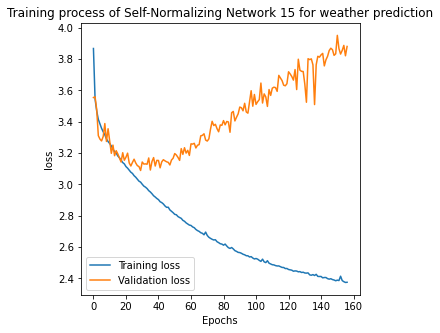

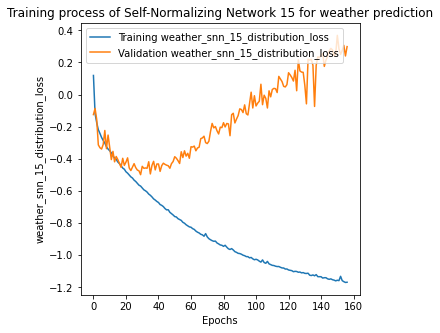

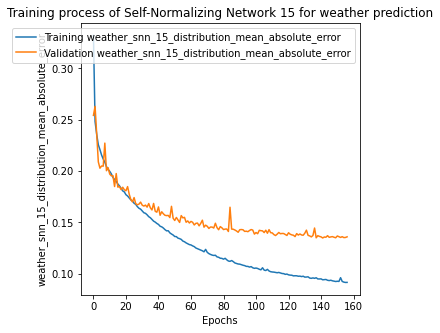


Test quality:
  mean absolute error   = 1.2056848879059363
  mean squared error    = 2.8128470957012155
  median absolute error = 0.8872279737191668
  r2 score              = 0.9735491505209404
  R-AUC MSE             = 0.9213390251041049
 Self-Normalizing Network 16 for weather prediction

Model: "weather_snn_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_16_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_16_dropout1 (AlphaD (None, 123)          0           weather_snn_16_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_16_dense1 (Dense)   (None, 512)          63488       weather_snn_16_dropout1[

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8736 - weather_snn_16_distribution_loss: 0.1350 - weather_snn_16_projection_loss: 7.4772 - weather_snn_16_distribution_mean_absolute_error: 0.3350 - val_loss: 3.5672 - val_weather_snn_16_distribution_loss: -0.1030 - val_weather_snn_16_projection_loss: 7.3404 - val_weather_snn_16_distribution_mean_absolute_error: 0.2686
Epoch 2/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.5886 - weather_snn_16_distribution_loss: -0.0733 - weather_snn_16_projection_loss: 7.3238 - weather_snn_16_distribution_mean_absolute_error: 0.2613 - val_loss: 3.4398 - val_weather_snn_16_distribution_loss: -0.2069 - val_weather_snn_16_projection_loss: 7.2934 - val_weather_snn_16_distribution_mean_absolute_error: 0.2259
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4862 - weather_snn_16_distribution_loss: -0.1580 - weather_snn_16_projection_loss: 7.2884 - weather_snn_16_distributi

725/725 [==============================] - 37s 50ms/step - loss: 3.1197 - weather_snn_16_distribution_loss: -0.4744 - weather_snn_16_projection_loss: 7.1882 - weather_snn_16_distribution_mean_absolute_error: 0.1777 - val_loss: 3.1715 - val_weather_snn_16_distribution_loss: -0.4235 - val_weather_snn_16_projection_loss: 7.1899 - val_weather_snn_16_distribution_mean_absolute_error: 0.1791
Epoch 22/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1119 - weather_snn_16_distribution_loss: -0.4809 - weather_snn_16_projection_loss: 7.1857 - weather_snn_16_distribution_mean_absolute_error: 0.1769 - val_loss: 3.1491 - val_weather_snn_16_distribution_loss: -0.4456 - val_weather_snn_16_projection_loss: 7.1894 - val_weather_snn_16_distribution_mean_absolute_error: 0.1795
Epoch 23/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.0955 - weather_snn_16_distribution_loss: -0.4960 - weather_snn_16_projection_loss: 7.1830 - weather_snn_16_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.9066 - weather_snn_16_distribution_loss: -0.6669 - weather_snn_16_projection_loss: 7.1470 - weather_snn_16_distribution_mean_absolute_error: 0.1489 - val_loss: 3.1078 - val_weather_snn_16_distribution_loss: -0.4761 - val_weather_snn_16_projection_loss: 7.1678 - val_weather_snn_16_distribution_mean_absolute_error: 0.1599
Epoch 42/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.9027 - weather_snn_16_distribution_loss: -0.6703 - weather_snn_16_projection_loss: 7.1460 - weather_snn_16_distribution_mean_absolute_error: 0.1488 - val_loss: 3.1070 - val_weather_snn_16_distribution_loss: -0.4765 - val_weather_snn_16_projection_loss: 7.1670 - val_weather_snn_16_distribution_mean_absolute_error: 0.1603
Epoch 43/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.8919 - weather_snn_16_distribution_loss: -0.6802 - weather_snn_16_projection_loss: 7.1442 - weather_snn_16_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.7405 - weather_snn_16_distribution_loss: -0.8207 - weather_snn_16_projection_loss: 7.1225 - weather_snn_16_distribution_mean_absolute_error: 0.1287 - val_loss: 3.2546 - val_weather_snn_16_distribution_loss: -0.3282 - val_weather_snn_16_projection_loss: 7.1655 - val_weather_snn_16_distribution_mean_absolute_error: 0.1488
Epoch 62/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7332 - weather_snn_16_distribution_loss: -0.8276 - weather_snn_16_projection_loss: 7.1216 - weather_snn_16_distribution_mean_absolute_error: 0.1278 - val_loss: 3.2343 - val_weather_snn_16_distribution_loss: -0.3487 - val_weather_snn_16_projection_loss: 7.1660 - val_weather_snn_16_distribution_mean_absolute_error: 0.1493
Epoch 63/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7256 - weather_snn_16_distribution_loss: -0.8348 - weather_snn_16_projection_loss: 7.1207 - weather_snn_16_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.6168 - weather_snn_16_distribution_loss: -0.9369 - weather_snn_16_projection_loss: 7.1074 - weather_snn_16_distribution_mean_absolute_error: 0.1151 - val_loss: 3.3448 - val_weather_snn_16_distribution_loss: -0.2365 - val_weather_snn_16_projection_loss: 7.1626 - val_weather_snn_16_distribution_mean_absolute_error: 0.1439
Epoch 82/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6098 - weather_snn_16_distribution_loss: -0.9436 - weather_snn_16_projection_loss: 7.1069 - weather_snn_16_distribution_mean_absolute_error: 0.1144 - val_loss: 3.3907 - val_weather_snn_16_distribution_loss: -0.1913 - val_weather_snn_16_projection_loss: 7.1640 - val_weather_snn_16_distribution_mean_absolute_error: 0.1442
Epoch 83/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6028 - weather_snn_16_distribution_loss: -0.9502 - weather_snn_16_projection_loss: 7.1059 - weather_snn_16_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.5214 - weather_snn_16_distribution_loss: -1.0269 - weather_snn_16_projection_loss: 7.0966 - weather_snn_16_distribution_mean_absolute_error: 0.1054 - val_loss: 3.4988 - val_weather_snn_16_distribution_loss: -0.0825 - val_weather_snn_16_projection_loss: 7.1625 - val_weather_snn_16_distribution_mean_absolute_error: 0.1408
Epoch 102/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5188 - weather_snn_16_distribution_loss: -1.0294 - weather_snn_16_projection_loss: 7.0965 - weather_snn_16_distribution_mean_absolute_error: 0.1051 - val_loss: 3.4755 - val_weather_snn_16_distribution_loss: -0.1050 - val_weather_snn_16_projection_loss: 7.1609 - val_weather_snn_16_distribution_mean_absolute_error: 0.1402
Epoch 103/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5150 - weather_snn_16_distribution_loss: -1.0330 - weather_snn_16_projection_loss: 7.0959 - weather_snn_16_distribution_mean_

725/725 [==============================] - 36s 49ms/step - loss: 2.4549 - weather_snn_16_distribution_loss: -1.0897 - weather_snn_16_projection_loss: 7.0893 - weather_snn_16_distribution_mean_absolute_error: 0.0991 - val_loss: 3.6798 - val_weather_snn_16_distribution_loss: 0.0984 - val_weather_snn_16_projection_loss: 7.1629 - val_weather_snn_16_distribution_mean_absolute_error: 0.1399
Epoch 122/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4661 - weather_snn_16_distribution_loss: -1.0790 - weather_snn_16_projection_loss: 7.0901 - weather_snn_16_distribution_mean_absolute_error: 0.1000 - val_loss: 3.4713 - val_weather_snn_16_distribution_loss: -0.1119 - val_weather_snn_16_projection_loss: 7.1664 - val_weather_snn_16_distribution_mean_absolute_error: 0.1427
Epoch 123/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4724 - weather_snn_16_distribution_loss: -1.0725 - weather_snn_16_projection_loss: 7.0899 - weather_snn_16_distribution_mean_a

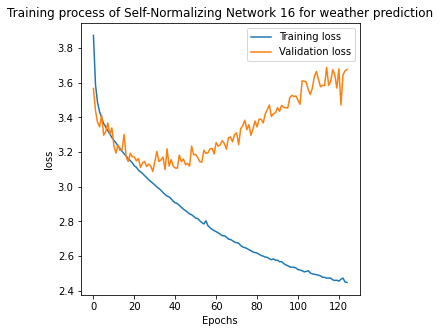

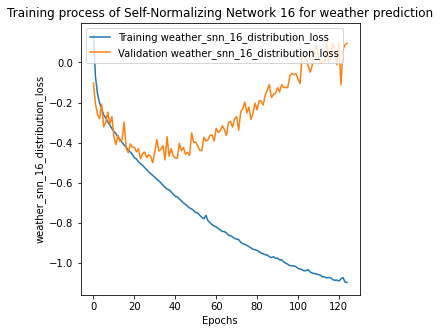

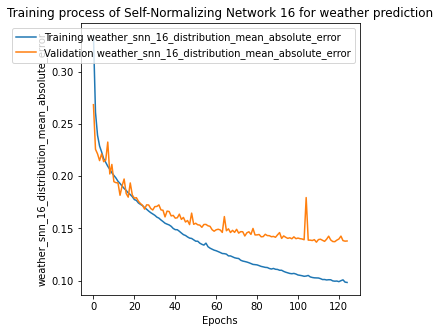


Test quality:
  mean absolute error   = 1.2061961539681676
  mean squared error    = 2.811833699382243
  median absolute error = 0.8954767038702869
  r2 score              = 0.9735472626615576
  R-AUC MSE             = 0.9165899887544265
 Self-Normalizing Network 17 for weather prediction

Model: "weather_snn_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_17_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_17_dropout1 (AlphaD (None, 123)          0           weather_snn_17_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_17_dense1 (Dense)   (None, 512)          63488       weather_snn_17_dropout1[0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8988 - weather_snn_17_distribution_loss: 0.1504 - weather_snn_17_projection_loss: 7.4967 - weather_snn_17_distribution_mean_absolute_error: 0.3440 - val_loss: 3.5071 - val_weather_snn_17_distribution_loss: -0.1599 - val_weather_snn_17_projection_loss: 7.3340 - val_weather_snn_17_distribution_mean_absolute_error: 0.2425
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5976 - weather_snn_17_distribution_loss: -0.0652 - weather_snn_17_projection_loss: 7.3255 - weather_snn_17_distribution_mean_absolute_error: 0.2635 - val_loss: 3.4867 - val_weather_snn_17_distribution_loss: -0.1603 - val_weather_snn_17_projection_loss: 7.2940 - val_weather_snn_17_distribution_mean_absolute_error: 0.2425
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4864 - weather_snn_17_distribution_loss: -0.1585 - weather_snn_17_projection_loss: 7.2899 - weather_snn_17_distributi

725/725 [==============================] - 37s 51ms/step - loss: 3.2320 - weather_snn_17_distribution_loss: -0.3670 - weather_snn_17_projection_loss: 7.1979 - weather_snn_17_distribution_mean_absolute_error: 0.1967 - val_loss: 3.2715 - val_weather_snn_17_distribution_loss: -0.3247 - val_weather_snn_17_projection_loss: 7.1923 - val_weather_snn_17_distribution_mean_absolute_error: 0.1996
Epoch 22/1000
725/725 [==============================] - 37s 50ms/step - loss: 3.2125 - weather_snn_17_distribution_loss: -0.3847 - weather_snn_17_projection_loss: 7.1944 - weather_snn_17_distribution_mean_absolute_error: 0.1937 - val_loss: 3.1758 - val_weather_snn_17_distribution_loss: -0.4179 - val_weather_snn_17_projection_loss: 7.1874 - val_weather_snn_17_distribution_mean_absolute_error: 0.1886
Epoch 23/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1957 - weather_snn_17_distribution_loss: -0.3995 - weather_snn_17_projection_loss: 7.1904 - weather_snn_17_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 3.0019 - weather_snn_17_distribution_loss: -0.5637 - weather_snn_17_projection_loss: 7.1313 - weather_snn_17_distribution_mean_absolute_error: 0.1641 - val_loss: 3.1014 - val_weather_snn_17_distribution_loss: -0.4778 - val_weather_snn_17_projection_loss: 7.1585 - val_weather_snn_17_distribution_mean_absolute_error: 0.1673
Epoch 42/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.9953 - weather_snn_17_distribution_loss: -0.5694 - weather_snn_17_projection_loss: 7.1295 - weather_snn_17_distribution_mean_absolute_error: 0.1631 - val_loss: 3.0758 - val_weather_snn_17_distribution_loss: -0.5014 - val_weather_snn_17_projection_loss: 7.1543 - val_weather_snn_17_distribution_mean_absolute_error: 0.1689
Epoch 43/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.9805 - weather_snn_17_distribution_loss: -0.5820 - weather_snn_17_projection_loss: 7.1250 - weather_snn_17_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.8171 - weather_snn_17_distribution_loss: -0.7207 - weather_snn_17_projection_loss: 7.0757 - weather_snn_17_distribution_mean_absolute_error: 0.1414 - val_loss: 3.1525 - val_weather_snn_17_distribution_loss: -0.4257 - val_weather_snn_17_projection_loss: 7.1563 - val_weather_snn_17_distribution_mean_absolute_error: 0.1575
Epoch 62/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8082 - weather_snn_17_distribution_loss: -0.7286 - weather_snn_17_projection_loss: 7.0736 - weather_snn_17_distribution_mean_absolute_error: 0.1403 - val_loss: 3.1459 - val_weather_snn_17_distribution_loss: -0.4317 - val_weather_snn_17_projection_loss: 7.1552 - val_weather_snn_17_distribution_mean_absolute_error: 0.1551
Epoch 63/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.7993 - weather_snn_17_distribution_loss: -0.7363 - weather_snn_17_projection_loss: 7.0712 - weather_snn_17_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.6567 - weather_snn_17_distribution_loss: -0.8614 - weather_snn_17_projection_loss: 7.0362 - weather_snn_17_distribution_mean_absolute_error: 0.1237 - val_loss: 3.2724 - val_weather_snn_17_distribution_loss: -0.3088 - val_weather_snn_17_projection_loss: 7.1625 - val_weather_snn_17_distribution_mean_absolute_error: 0.1498
Epoch 82/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6562 - weather_snn_17_distribution_loss: -0.8616 - weather_snn_17_projection_loss: 7.0356 - weather_snn_17_distribution_mean_absolute_error: 0.1236 - val_loss: 3.2981 - val_weather_snn_17_distribution_loss: -0.2812 - val_weather_snn_17_projection_loss: 7.1585 - val_weather_snn_17_distribution_mean_absolute_error: 0.1481
Epoch 83/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6452 - weather_snn_17_distribution_loss: -0.8718 - weather_snn_17_projection_loss: 7.0339 - weather_snn_17_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.5321 - weather_snn_17_distribution_loss: -0.9738 - weather_snn_17_projection_loss: 7.0118 - weather_snn_17_distribution_mean_absolute_error: 0.1111 - val_loss: 3.4496 - val_weather_snn_17_distribution_loss: -0.1307 - val_weather_snn_17_projection_loss: 7.1607 - val_weather_snn_17_distribution_mean_absolute_error: 0.1422
Epoch 102/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5289 - weather_snn_17_distribution_loss: -0.9768 - weather_snn_17_projection_loss: 7.0113 - weather_snn_17_distribution_mean_absolute_error: 0.1107 - val_loss: 3.4418 - val_weather_snn_17_distribution_loss: -0.1393 - val_weather_snn_17_projection_loss: 7.1623 - val_weather_snn_17_distribution_mean_absolute_error: 0.1423
Epoch 103/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.5211 - weather_snn_17_distribution_loss: -0.9839 - weather_snn_17_projection_loss: 7.0100 - weather_snn_17_distribution_mean_

725/725 [==============================] - 37s 51ms/step - loss: 2.4419 - weather_snn_17_distribution_loss: -1.0574 - weather_snn_17_projection_loss: 6.9986 - weather_snn_17_distribution_mean_absolute_error: 0.1027 - val_loss: 3.7169 - val_weather_snn_17_distribution_loss: 0.1318 - val_weather_snn_17_projection_loss: 7.1703 - val_weather_snn_17_distribution_mean_absolute_error: 0.1436
Epoch 122/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4440 - weather_snn_17_distribution_loss: -1.0551 - weather_snn_17_projection_loss: 6.9982 - weather_snn_17_distribution_mean_absolute_error: 0.1028 - val_loss: 3.7050 - val_weather_snn_17_distribution_loss: 0.1198 - val_weather_snn_17_projection_loss: 7.1706 - val_weather_snn_17_distribution_mean_absolute_error: 0.1409
Epoch 123/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4307 - weather_snn_17_distribution_loss: -1.0674 - weather_snn_17_projection_loss: 6.9962 - weather_snn_17_distribution_mean_ab

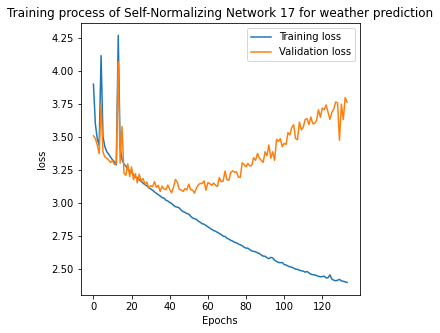

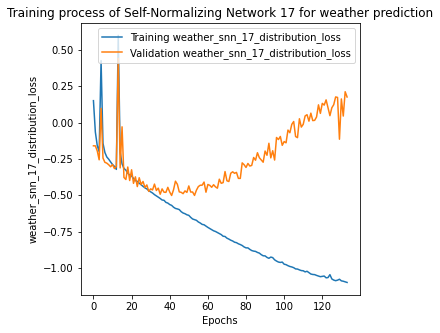

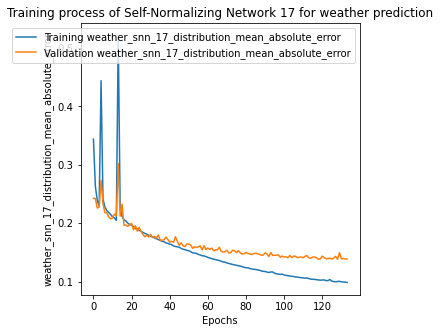


Test quality:
  mean absolute error   = 1.2061171151999541
  mean squared error    = 2.8489104133989027
  median absolute error = 0.884266434770284
  r2 score              = 0.9731994447488641
  R-AUC MSE             = 0.9478540087409058
 Self-Normalizing Network 18 for weather prediction

Model: "weather_snn_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_18_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_18_dropout1 (AlphaD (None, 123)          0           weather_snn_18_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_18_dense1 (Dense)   (None, 512)          63488       weather_snn_18_dropout1[0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8894 - weather_snn_18_distribution_loss: 0.1434 - weather_snn_18_projection_loss: 7.4921 - weather_snn_18_distribution_mean_absolute_error: 0.3392 - val_loss: 3.6836 - val_weather_snn_18_distribution_loss: 0.0082 - val_weather_snn_18_projection_loss: 7.3508 - val_weather_snn_18_distribution_mean_absolute_error: 0.2746
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5664 - weather_snn_18_distribution_loss: -0.0963 - weather_snn_18_projection_loss: 7.3254 - weather_snn_18_distribution_mean_absolute_error: 0.2540 - val_loss: 3.5419 - val_weather_snn_18_distribution_loss: -0.1059 - val_weather_snn_18_projection_loss: 7.2957 - val_weather_snn_18_distribution_mean_absolute_error: 0.2452
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4863 - weather_snn_18_distribution_loss: -0.1583 - weather_snn_18_projection_loss: 7.2892 - weather_snn_18_distributio

725/725 [==============================] - 37s 50ms/step - loss: 3.1275 - weather_snn_18_distribution_loss: -0.4673 - weather_snn_18_projection_loss: 7.1897 - weather_snn_18_distribution_mean_absolute_error: 0.1791 - val_loss: 3.1485 - val_weather_snn_18_distribution_loss: -0.4469 - val_weather_snn_18_projection_loss: 7.1908 - val_weather_snn_18_distribution_mean_absolute_error: 0.1798
Epoch 22/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.1124 - weather_snn_18_distribution_loss: -0.4810 - weather_snn_18_projection_loss: 7.1869 - weather_snn_18_distribution_mean_absolute_error: 0.1770 - val_loss: 3.1748 - val_weather_snn_18_distribution_loss: -0.4202 - val_weather_snn_18_projection_loss: 7.1900 - val_weather_snn_18_distribution_mean_absolute_error: 0.1792
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1015 - weather_snn_18_distribution_loss: -0.4908 - weather_snn_18_projection_loss: 7.1845 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.9086 - weather_snn_18_distribution_loss: -0.6657 - weather_snn_18_projection_loss: 7.1487 - weather_snn_18_distribution_mean_absolute_error: 0.1488 - val_loss: 3.1114 - val_weather_snn_18_distribution_loss: -0.4748 - val_weather_snn_18_projection_loss: 7.1724 - val_weather_snn_18_distribution_mean_absolute_error: 0.1608
Epoch 42/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.9011 - weather_snn_18_distribution_loss: -0.6727 - weather_snn_18_projection_loss: 7.1477 - weather_snn_18_distribution_mean_absolute_error: 0.1482 - val_loss: 3.0980 - val_weather_snn_18_distribution_loss: -0.4866 - val_weather_snn_18_projection_loss: 7.1693 - val_weather_snn_18_distribution_mean_absolute_error: 0.1572
Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8916 - weather_snn_18_distribution_loss: -0.6815 - weather_snn_18_projection_loss: 7.1462 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.7381 - weather_snn_18_distribution_loss: -0.8245 - weather_snn_18_projection_loss: 7.1251 - weather_snn_18_distribution_mean_absolute_error: 0.1281 - val_loss: 3.2612 - val_weather_snn_18_distribution_loss: -0.3221 - val_weather_snn_18_projection_loss: 7.1667 - val_weather_snn_18_distribution_mean_absolute_error: 0.1490
Epoch 62/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7326 - weather_snn_18_distribution_loss: -0.8296 - weather_snn_18_projection_loss: 7.1245 - weather_snn_18_distribution_mean_absolute_error: 0.1275 - val_loss: 3.2673 - val_weather_snn_18_distribution_loss: -0.3173 - val_weather_snn_18_projection_loss: 7.1692 - val_weather_snn_18_distribution_mean_absolute_error: 0.1494
Epoch 63/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7286 - weather_snn_18_distribution_loss: -0.8331 - weather_snn_18_projection_loss: 7.1235 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 37s 50ms/step - loss: 2.6140 - weather_snn_18_distribution_loss: -0.9406 - weather_snn_18_projection_loss: 7.1093 - weather_snn_18_distribution_mean_absolute_error: 0.1145 - val_loss: 3.3664 - val_weather_snn_18_distribution_loss: -0.2166 - val_weather_snn_18_projection_loss: 7.1659 - val_weather_snn_18_distribution_mean_absolute_error: 0.1470
Epoch 82/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6092 - weather_snn_18_distribution_loss: -0.9452 - weather_snn_18_projection_loss: 7.1088 - weather_snn_18_distribution_mean_absolute_error: 0.1140 - val_loss: 3.3924 - val_weather_snn_18_distribution_loss: -0.1899 - val_weather_snn_18_projection_loss: 7.1646 - val_weather_snn_18_distribution_mean_absolute_error: 0.1472
Epoch 83/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6054 - weather_snn_18_distribution_loss: -0.9489 - weather_snn_18_projection_loss: 7.1086 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.5237 - weather_snn_18_distribution_loss: -1.0253 - weather_snn_18_projection_loss: 7.0980 - weather_snn_18_distribution_mean_absolute_error: 0.1056 - val_loss: 3.4993 - val_weather_snn_18_distribution_loss: -0.0819 - val_weather_snn_18_projection_loss: 7.1623 - val_weather_snn_18_distribution_mean_absolute_error: 0.1403
Epoch 102/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5162 - weather_snn_18_distribution_loss: -1.0326 - weather_snn_18_projection_loss: 7.0976 - weather_snn_18_distribution_mean_absolute_error: 0.1046 - val_loss: 3.4550 - val_weather_snn_18_distribution_loss: -0.1264 - val_weather_snn_18_projection_loss: 7.1627 - val_weather_snn_18_distribution_mean_absolute_error: 0.1422
Epoch 103/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.5194 - weather_snn_18_distribution_loss: -1.0293 - weather_snn_18_projection_loss: 7.0975 - weather_snn_18_distribution_mean_

725/725 [==============================] - 36s 50ms/step - loss: 2.4570 - weather_snn_18_distribution_loss: -1.0880 - weather_snn_18_projection_loss: 7.0899 - weather_snn_18_distribution_mean_absolute_error: 0.0992 - val_loss: 3.7080 - val_weather_snn_18_distribution_loss: 0.1262 - val_weather_snn_18_projection_loss: 7.1636 - val_weather_snn_18_distribution_mean_absolute_error: 0.1384
Epoch 122/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4537 - weather_snn_18_distribution_loss: -1.0911 - weather_snn_18_projection_loss: 7.0896 - weather_snn_18_distribution_mean_absolute_error: 0.0988 - val_loss: 3.6771 - val_weather_snn_18_distribution_loss: 0.0952 - val_weather_snn_18_projection_loss: 7.1639 - val_weather_snn_18_distribution_mean_absolute_error: 0.1399
Epoch 123/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4548 - weather_snn_18_distribution_loss: -1.0900 - weather_snn_18_projection_loss: 7.0896 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.4034 - weather_snn_18_distribution_loss: -1.1383 - weather_snn_18_projection_loss: 7.0834 - weather_snn_18_distribution_mean_absolute_error: 0.0942 - val_loss: 3.7875 - val_weather_snn_18_distribution_loss: 0.2054 - val_weather_snn_18_projection_loss: 7.1642 - val_weather_snn_18_distribution_mean_absolute_error: 0.1364
Epoch 142/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4027 - weather_snn_18_distribution_loss: -1.1389 - weather_snn_18_projection_loss: 7.0832 - weather_snn_18_distribution_mean_absolute_error: 0.0943 - val_loss: 3.7611 - val_weather_snn_18_distribution_loss: 0.1795 - val_weather_snn_18_projection_loss: 7.1634 - val_weather_snn_18_distribution_mean_absolute_error: 0.1372
Epoch 143/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4091 - weather_snn_18_distribution_loss: -1.1325 - weather_snn_18_projection_loss: 7.0832 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3648 - weather_snn_18_distribution_loss: -1.1742 - weather_snn_18_projection_loss: 7.0779 - weather_snn_18_distribution_mean_absolute_error: 0.0909 - val_loss: 3.8453 - val_weather_snn_18_distribution_loss: 0.2638 - val_weather_snn_18_projection_loss: 7.1629 - val_weather_snn_18_distribution_mean_absolute_error: 0.1354
Epoch 162/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3642 - weather_snn_18_distribution_loss: -1.1749 - weather_snn_18_projection_loss: 7.0781 - weather_snn_18_distribution_mean_absolute_error: 0.0910 - val_loss: 3.7914 - val_weather_snn_18_distribution_loss: 0.2102 - val_weather_snn_18_projection_loss: 7.1623 - val_weather_snn_18_distribution_mean_absolute_error: 0.1353
Epoch 163/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3601 - weather_snn_18_distribution_loss: -1.1788 - weather_snn_18_projection_loss: 7.0776 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.3297 - weather_snn_18_distribution_loss: -1.2072 - weather_snn_18_projection_loss: 7.0737 - weather_snn_18_distribution_mean_absolute_error: 0.0880 - val_loss: 4.1161 - val_weather_snn_18_distribution_loss: 0.5330 - val_weather_snn_18_projection_loss: 7.1662 - val_weather_snn_18_distribution_mean_absolute_error: 0.1340
Epoch 182/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3327 - weather_snn_18_distribution_loss: -1.2041 - weather_snn_18_projection_loss: 7.0736 - weather_snn_18_distribution_mean_absolute_error: 0.0882 - val_loss: 4.0212 - val_weather_snn_18_distribution_loss: 0.4383 - val_weather_snn_18_projection_loss: 7.1657 - val_weather_snn_18_distribution_mean_absolute_error: 0.1349
Epoch 183/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3246 - weather_snn_18_distribution_loss: -1.2118 - weather_snn_18_projection_loss: 7.0727 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.3032 - weather_snn_18_distribution_loss: -1.2317 - weather_snn_18_projection_loss: 7.0697 - weather_snn_18_distribution_mean_absolute_error: 0.0859 - val_loss: 4.0652 - val_weather_snn_18_distribution_loss: 0.4826 - val_weather_snn_18_projection_loss: 7.1651 - val_weather_snn_18_distribution_mean_absolute_error: 0.1340
Epoch 202/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.3076 - weather_snn_18_distribution_loss: -1.2271 - weather_snn_18_projection_loss: 7.0694 - weather_snn_18_distribution_mean_absolute_error: 0.0863 - val_loss: 4.0214 - val_weather_snn_18_distribution_loss: 0.4391 - val_weather_snn_18_projection_loss: 7.1646 - val_weather_snn_18_distribution_mean_absolute_error: 0.1330
Epoch 203/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3190 - weather_snn_18_distribution_loss: -1.2163 - weather_snn_18_projection_loss: 7.0706 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.2825 - weather_snn_18_distribution_loss: -1.2507 - weather_snn_18_projection_loss: 7.0663 - weather_snn_18_distribution_mean_absolute_error: 0.0842 - val_loss: 4.1267 - val_weather_snn_18_distribution_loss: 0.5444 - val_weather_snn_18_projection_loss: 7.1647 - val_weather_snn_18_distribution_mean_absolute_error: 0.1324
Epoch 222/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2779 - weather_snn_18_distribution_loss: -1.2550 - weather_snn_18_projection_loss: 7.0658 - weather_snn_18_distribution_mean_absolute_error: 0.0839 - val_loss: 4.1590 - val_weather_snn_18_distribution_loss: 0.5769 - val_weather_snn_18_projection_loss: 7.1642 - val_weather_snn_18_distribution_mean_absolute_error: 0.1315
Epoch 223/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2757 - weather_snn_18_distribution_loss: -1.2572 - weather_snn_18_projection_loss: 7.0659 - weather_snn_18_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.2558 - weather_snn_18_distribution_loss: -1.2756 - weather_snn_18_projection_loss: 7.0629 - weather_snn_18_distribution_mean_absolute_error: 0.0821 - val_loss: 4.2287 - val_weather_snn_18_distribution_loss: 0.6454 - val_weather_snn_18_projection_loss: 7.1668 - val_weather_snn_18_distribution_mean_absolute_error: 0.1327
Epoch 242/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2555 - weather_snn_18_distribution_loss: -1.2757 - weather_snn_18_projection_loss: 7.0624 - weather_snn_18_distribution_mean_absolute_error: 0.0822 - val_loss: 4.3421 - val_weather_snn_18_distribution_loss: 0.7582 - val_weather_snn_18_projection_loss: 7.1678 - val_weather_snn_18_distribution_mean_absolute_error: 0.1316
Epoch 00242: early stopping



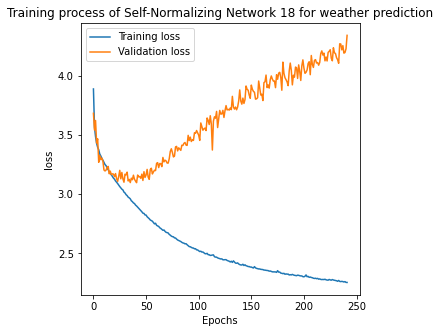

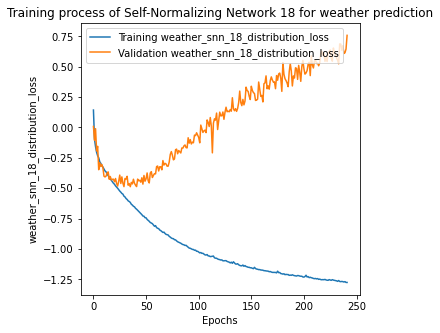

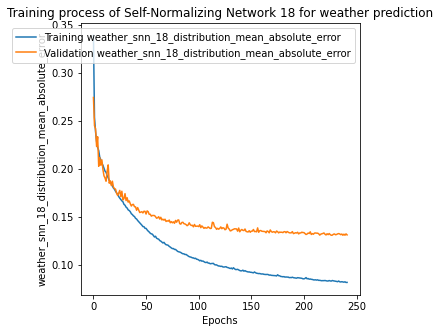


Test quality:
  mean absolute error   = 1.1996140862981055
  mean squared error    = 2.778726505427718
  median absolute error = 0.88088972971385
  r2 score              = 0.973859204339682
  R-AUC MSE             = 0.9083171539327136
 Self-Normalizing Network 19 for weather prediction

Model: "weather_snn_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_19_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_19_dropout1 (AlphaD (None, 123)          0           weather_snn_19_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_19_dense1 (Dense)   (None, 512)          63488       weather_snn_19_dropout1[0][0

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.8863 - weather_snn_19_distribution_loss: 0.1374 - weather_snn_19_projection_loss: 7.4978 - weather_snn_19_distribution_mean_absolute_error: 0.3375 - val_loss: 3.9059 - val_weather_snn_19_distribution_loss: 0.2286 - val_weather_snn_19_projection_loss: 7.3546 - val_weather_snn_19_distribution_mean_absolute_error: 0.3141
Epoch 2/1000
725/725 [==============================] - 36s 49ms/step - loss: 3.5656 - weather_snn_19_distribution_loss: -0.0972 - weather_snn_19_projection_loss: 7.3255 - weather_snn_19_distribution_mean_absolute_error: 0.2536 - val_loss: 3.5630 - val_weather_snn_19_distribution_loss: -0.0839 - val_weather_snn_19_projection_loss: 7.2937 - val_weather_snn_19_distribution_mean_absolute_error: 0.2577
Epoch 3/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.4793 - weather_snn_19_distribution_loss: -0.1641 - weather_snn_19_projection_loss: 7.2866 - weather_snn_19_distributio

725/725 [==============================] - 36s 50ms/step - loss: 3.1229 - weather_snn_19_distribution_loss: -0.4711 - weather_snn_19_projection_loss: 7.1880 - weather_snn_19_distribution_mean_absolute_error: 0.1785 - val_loss: 3.1561 - val_weather_snn_19_distribution_loss: -0.4383 - val_weather_snn_19_projection_loss: 7.1889 - val_weather_snn_19_distribution_mean_absolute_error: 0.1793
Epoch 22/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1114 - weather_snn_19_distribution_loss: -0.4816 - weather_snn_19_projection_loss: 7.1860 - weather_snn_19_distribution_mean_absolute_error: 0.1769 - val_loss: 3.1914 - val_weather_snn_19_distribution_loss: -0.4035 - val_weather_snn_19_projection_loss: 7.1899 - val_weather_snn_19_distribution_mean_absolute_error: 0.1837
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1016 - weather_snn_19_distribution_loss: -0.4899 - weather_snn_19_projection_loss: 7.1832 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.9126 - weather_snn_19_distribution_loss: -0.6614 - weather_snn_19_projection_loss: 7.1479 - weather_snn_19_distribution_mean_absolute_error: 0.1496 - val_loss: 3.0975 - val_weather_snn_19_distribution_loss: -0.4869 - val_weather_snn_19_projection_loss: 7.1689 - val_weather_snn_19_distribution_mean_absolute_error: 0.1586
Epoch 42/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8988 - weather_snn_19_distribution_loss: -0.6740 - weather_snn_19_projection_loss: 7.1454 - weather_snn_19_distribution_mean_absolute_error: 0.1480 - val_loss: 3.0973 - val_weather_snn_19_distribution_loss: -0.4861 - val_weather_snn_19_projection_loss: 7.1668 - val_weather_snn_19_distribution_mean_absolute_error: 0.1574
Epoch 43/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.8866 - weather_snn_19_distribution_loss: -0.6854 - weather_snn_19_projection_loss: 7.1440 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.7383 - weather_snn_19_distribution_loss: -0.8234 - weather_snn_19_projection_loss: 7.1234 - weather_snn_19_distribution_mean_absolute_error: 0.1286 - val_loss: 3.2140 - val_weather_snn_19_distribution_loss: -0.3696 - val_weather_snn_19_projection_loss: 7.1671 - val_weather_snn_19_distribution_mean_absolute_error: 0.1516
Epoch 62/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7316 - weather_snn_19_distribution_loss: -0.8296 - weather_snn_19_projection_loss: 7.1223 - weather_snn_19_distribution_mean_absolute_error: 0.1280 - val_loss: 3.2461 - val_weather_snn_19_distribution_loss: -0.3370 - val_weather_snn_19_projection_loss: 7.1663 - val_weather_snn_19_distribution_mean_absolute_error: 0.1479
Epoch 63/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.7291 - weather_snn_19_distribution_loss: -0.8317 - weather_snn_19_projection_loss: 7.1216 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.6134 - weather_snn_19_distribution_loss: -0.9401 - weather_snn_19_projection_loss: 7.1072 - weather_snn_19_distribution_mean_absolute_error: 0.1148 - val_loss: 3.3663 - val_weather_snn_19_distribution_loss: -0.2149 - val_weather_snn_19_projection_loss: 7.1624 - val_weather_snn_19_distribution_mean_absolute_error: 0.1433
Epoch 82/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.6044 - weather_snn_19_distribution_loss: -0.9487 - weather_snn_19_projection_loss: 7.1061 - weather_snn_19_distribution_mean_absolute_error: 0.1138 - val_loss: 3.3793 - val_weather_snn_19_distribution_loss: -0.2015 - val_weather_snn_19_projection_loss: 7.1617 - val_weather_snn_19_distribution_mean_absolute_error: 0.1422
Epoch 83/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.5966 - weather_snn_19_distribution_loss: -0.9560 - weather_snn_19_projection_loss: 7.1053 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.5219 - weather_snn_19_distribution_loss: -1.0262 - weather_snn_19_projection_loss: 7.0961 - weather_snn_19_distribution_mean_absolute_error: 0.1056 - val_loss: 3.5152 - val_weather_snn_19_distribution_loss: -0.0653 - val_weather_snn_19_projection_loss: 7.1609 - val_weather_snn_19_distribution_mean_absolute_error: 0.1397
Epoch 102/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.5194 - weather_snn_19_distribution_loss: -1.0285 - weather_snn_19_projection_loss: 7.0958 - weather_snn_19_distribution_mean_absolute_error: 0.1054 - val_loss: 3.4949 - val_weather_snn_19_distribution_loss: -0.0854 - val_weather_snn_19_projection_loss: 7.1605 - val_weather_snn_19_distribution_mean_absolute_error: 0.1394
Epoch 103/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5180 - weather_snn_19_distribution_loss: -1.0298 - weather_snn_19_projection_loss: 7.0956 - weather_snn_19_distribution_mean_

725/725 [==============================] - 36s 50ms/step - loss: 2.4549 - weather_snn_19_distribution_loss: -1.0891 - weather_snn_19_projection_loss: 7.0880 - weather_snn_19_distribution_mean_absolute_error: 0.0994 - val_loss: 3.6833 - val_weather_snn_19_distribution_loss: 0.1013 - val_weather_snn_19_projection_loss: 7.1641 - val_weather_snn_19_distribution_mean_absolute_error: 0.1393
Epoch 122/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4494 - weather_snn_19_distribution_loss: -1.0944 - weather_snn_19_projection_loss: 7.0875 - weather_snn_19_distribution_mean_absolute_error: 0.0987 - val_loss: 3.6217 - val_weather_snn_19_distribution_loss: 0.0399 - val_weather_snn_19_projection_loss: 7.1637 - val_weather_snn_19_distribution_mean_absolute_error: 0.1398
Epoch 123/1000
725/725 [==============================] - 36s 49ms/step - loss: 2.4445 - weather_snn_19_distribution_loss: -1.0989 - weather_snn_19_projection_loss: 7.0870 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.4015 - weather_snn_19_distribution_loss: -1.1393 - weather_snn_19_projection_loss: 7.0815 - weather_snn_19_distribution_mean_absolute_error: 0.0945 - val_loss: 3.8245 - val_weather_snn_19_distribution_loss: 0.2427 - val_weather_snn_19_projection_loss: 7.1635 - val_weather_snn_19_distribution_mean_absolute_error: 0.1360
Epoch 142/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3986 - weather_snn_19_distribution_loss: -1.1419 - weather_snn_19_projection_loss: 7.0809 - weather_snn_19_distribution_mean_absolute_error: 0.0943 - val_loss: 3.8222 - val_weather_snn_19_distribution_loss: 0.2412 - val_weather_snn_19_projection_loss: 7.1621 - val_weather_snn_19_distribution_mean_absolute_error: 0.1355
Epoch 143/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3948 - weather_snn_19_distribution_loss: -1.1459 - weather_snn_19_projection_loss: 7.0814 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3593 - weather_snn_19_distribution_loss: -1.1787 - weather_snn_19_projection_loss: 7.0759 - weather_snn_19_distribution_mean_absolute_error: 0.0907 - val_loss: 3.8861 - val_weather_snn_19_distribution_loss: 0.3054 - val_weather_snn_19_projection_loss: 7.1614 - val_weather_snn_19_distribution_mean_absolute_error: 0.1342
Epoch 162/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3604 - weather_snn_19_distribution_loss: -1.1777 - weather_snn_19_projection_loss: 7.0761 - weather_snn_19_distribution_mean_absolute_error: 0.0909 - val_loss: 3.6881 - val_weather_snn_19_distribution_loss: 0.1067 - val_weather_snn_19_projection_loss: 7.1627 - val_weather_snn_19_distribution_mean_absolute_error: 0.1369
Epoch 163/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3579 - weather_snn_19_distribution_loss: -1.1799 - weather_snn_19_projection_loss: 7.0756 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3392 - weather_snn_19_distribution_loss: -1.1969 - weather_snn_19_projection_loss: 7.0723 - weather_snn_19_distribution_mean_absolute_error: 0.0891 - val_loss: 3.9819 - val_weather_snn_19_distribution_loss: 0.3996 - val_weather_snn_19_projection_loss: 7.1645 - val_weather_snn_19_distribution_mean_absolute_error: 0.1349
Epoch 182/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.3271 - weather_snn_19_distribution_loss: -1.2088 - weather_snn_19_projection_loss: 7.0719 - weather_snn_19_distribution_mean_absolute_error: 0.0880 - val_loss: 4.0056 - val_weather_snn_19_distribution_loss: 0.4234 - val_weather_snn_19_projection_loss: 7.1645 - val_weather_snn_19_distribution_mean_absolute_error: 0.1342
Epoch 183/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3259 - weather_snn_19_distribution_loss: -1.2097 - weather_snn_19_projection_loss: 7.0712 - weather_snn_19_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.2963 - weather_snn_19_distribution_loss: -1.2375 - weather_snn_19_projection_loss: 7.0676 - weather_snn_19_distribution_mean_absolute_error: 0.0855 - val_loss: 4.1411 - val_weather_snn_19_distribution_loss: 0.5587 - val_weather_snn_19_projection_loss: 7.1648 - val_weather_snn_19_distribution_mean_absolute_error: 0.1328
Epoch 202/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3020 - weather_snn_19_distribution_loss: -1.2319 - weather_snn_19_projection_loss: 7.0678 - weather_snn_19_distribution_mean_absolute_error: 0.0860 - val_loss: 4.1237 - val_weather_snn_19_distribution_loss: 0.5419 - val_weather_snn_19_projection_loss: 7.1637 - val_weather_snn_19_distribution_mean_absolute_error: 0.1328
Epoch 203/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2974 - weather_snn_19_distribution_loss: -1.2363 - weather_snn_19_projection_loss: 7.0674 - weather_snn_19_distribution_mean_ab

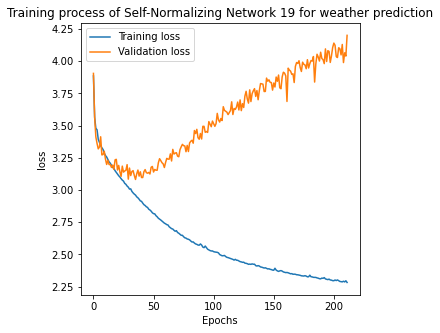

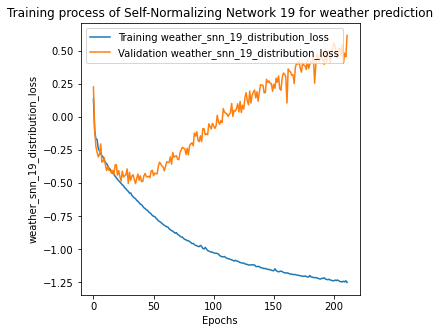

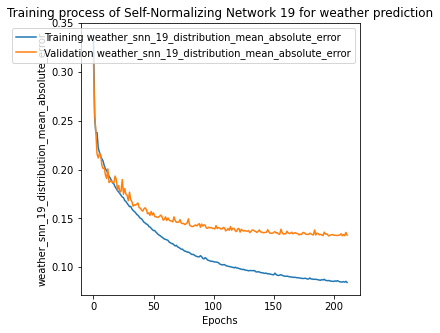


Test quality:
  mean absolute error   = 1.203657003905173
  mean squared error    = 2.802439428789536
  median absolute error = 0.8836660727582064
  r2 score              = 0.9736340148467522
  R-AUC MSE             = 0.9054717753756075
 Self-Normalizing Network 20 for weather prediction

Model: "weather_snn_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_20_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_20_dropout1 (AlphaD (None, 123)          0           weather_snn_20_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_20_dense1 (Dense)   (None, 512)          63488       weather_snn_20_dropout1[0]

Epoch 1/1000
725/725 [==============================] - 35s 48ms/step - loss: 3.9071 - weather_snn_20_distribution_loss: 0.1573 - weather_snn_20_projection_loss: 7.4998 - weather_snn_20_distribution_mean_absolute_error: 0.3458 - val_loss: 3.5584 - val_weather_snn_20_distribution_loss: -0.1128 - val_weather_snn_20_projection_loss: 7.3424 - val_weather_snn_20_distribution_mean_absolute_error: 0.2486
Epoch 2/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.5655 - weather_snn_20_distribution_loss: -0.0975 - weather_snn_20_projection_loss: 7.3259 - weather_snn_20_distribution_mean_absolute_error: 0.2537 - val_loss: 3.6862 - val_weather_snn_20_distribution_loss: 0.0358 - val_weather_snn_20_projection_loss: 7.3006 - val_weather_snn_20_distribution_mean_absolute_error: 0.2733
Epoch 3/1000
725/725 [==============================] - 37s 51ms/step - loss: 3.4976 - weather_snn_20_distribution_loss: -0.1483 - weather_snn_20_projection_loss: 7.2918 - weather_snn_20_distributio

725/725 [==============================] - 36s 50ms/step - loss: 3.1285 - weather_snn_20_distribution_loss: -0.4659 - weather_snn_20_projection_loss: 7.1887 - weather_snn_20_distribution_mean_absolute_error: 0.1792 - val_loss: 3.1784 - val_weather_snn_20_distribution_loss: -0.4181 - val_weather_snn_20_projection_loss: 7.1931 - val_weather_snn_20_distribution_mean_absolute_error: 0.1837
Epoch 22/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1140 - weather_snn_20_distribution_loss: -0.4791 - weather_snn_20_projection_loss: 7.1862 - weather_snn_20_distribution_mean_absolute_error: 0.1772 - val_loss: 3.2152 - val_weather_snn_20_distribution_loss: -0.3793 - val_weather_snn_20_projection_loss: 7.1890 - val_weather_snn_20_distribution_mean_absolute_error: 0.1876
Epoch 23/1000
725/725 [==============================] - 36s 50ms/step - loss: 3.1075 - weather_snn_20_distribution_loss: -0.4846 - weather_snn_20_projection_loss: 7.1842 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.9147 - weather_snn_20_distribution_loss: -0.6597 - weather_snn_20_projection_loss: 7.1489 - weather_snn_20_distribution_mean_absolute_error: 0.1498 - val_loss: 3.1446 - val_weather_snn_20_distribution_loss: -0.4415 - val_weather_snn_20_projection_loss: 7.1723 - val_weather_snn_20_distribution_mean_absolute_error: 0.1604
Epoch 42/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.9031 - weather_snn_20_distribution_loss: -0.6706 - weather_snn_20_projection_loss: 7.1475 - weather_snn_20_distribution_mean_absolute_error: 0.1481 - val_loss: 3.1163 - val_weather_snn_20_distribution_loss: -0.4679 - val_weather_snn_20_projection_loss: 7.1684 - val_weather_snn_20_distribution_mean_absolute_error: 0.1593
Epoch 43/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.8940 - weather_snn_20_distribution_loss: -0.6789 - weather_snn_20_projection_loss: 7.1458 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.7407 - weather_snn_20_distribution_loss: -0.8219 - weather_snn_20_projection_loss: 7.1252 - weather_snn_20_distribution_mean_absolute_error: 0.1284 - val_loss: 3.2655 - val_weather_snn_20_distribution_loss: -0.3185 - val_weather_snn_20_projection_loss: 7.1681 - val_weather_snn_20_distribution_mean_absolute_error: 0.1523
Epoch 62/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.7351 - weather_snn_20_distribution_loss: -0.8271 - weather_snn_20_projection_loss: 7.1245 - weather_snn_20_distribution_mean_absolute_error: 0.1278 - val_loss: 3.2785 - val_weather_snn_20_distribution_loss: -0.3058 - val_weather_snn_20_projection_loss: 7.1685 - val_weather_snn_20_distribution_mean_absolute_error: 0.1488
Epoch 63/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.7315 - weather_snn_20_distribution_loss: -0.8305 - weather_snn_20_projection_loss: 7.1240 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 50ms/step - loss: 2.6129 - weather_snn_20_distribution_loss: -0.9418 - weather_snn_20_projection_loss: 7.1094 - weather_snn_20_distribution_mean_absolute_error: 0.1145 - val_loss: 3.4394 - val_weather_snn_20_distribution_loss: -0.1425 - val_weather_snn_20_projection_loss: 7.1637 - val_weather_snn_20_distribution_mean_absolute_error: 0.1444
Epoch 82/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6086 - weather_snn_20_distribution_loss: -0.9457 - weather_snn_20_projection_loss: 7.1085 - weather_snn_20_distribution_mean_absolute_error: 0.1140 - val_loss: 3.4237 - val_weather_snn_20_distribution_loss: -0.1583 - val_weather_snn_20_projection_loss: 7.1639 - val_weather_snn_20_distribution_mean_absolute_error: 0.1432
Epoch 83/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.6040 - weather_snn_20_distribution_loss: -0.9501 - weather_snn_20_projection_loss: 7.1083 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.5274 - weather_snn_20_distribution_loss: -1.0218 - weather_snn_20_projection_loss: 7.0985 - weather_snn_20_distribution_mean_absolute_error: 0.1061 - val_loss: 3.5344 - val_weather_snn_20_distribution_loss: -0.0468 - val_weather_snn_20_projection_loss: 7.1623 - val_weather_snn_20_distribution_mean_absolute_error: 0.1397
Epoch 102/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5223 - weather_snn_20_distribution_loss: -1.0268 - weather_snn_20_projection_loss: 7.0981 - weather_snn_20_distribution_mean_absolute_error: 0.1054 - val_loss: 3.5250 - val_weather_snn_20_distribution_loss: -0.0562 - val_weather_snn_20_projection_loss: 7.1623 - val_weather_snn_20_distribution_mean_absolute_error: 0.1402
Epoch 103/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.5147 - weather_snn_20_distribution_loss: -1.0340 - weather_snn_20_projection_loss: 7.0975 - weather_snn_20_distribution_mean_

725/725 [==============================] - 36s 50ms/step - loss: 2.4598 - weather_snn_20_distribution_loss: -1.0855 - weather_snn_20_projection_loss: 7.0906 - weather_snn_20_distribution_mean_absolute_error: 0.0994 - val_loss: 3.7143 - val_weather_snn_20_distribution_loss: 0.1313 - val_weather_snn_20_projection_loss: 7.1661 - val_weather_snn_20_distribution_mean_absolute_error: 0.1398
Epoch 122/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4554 - weather_snn_20_distribution_loss: -1.0896 - weather_snn_20_projection_loss: 7.0900 - weather_snn_20_distribution_mean_absolute_error: 0.0989 - val_loss: 3.7076 - val_weather_snn_20_distribution_loss: 0.1255 - val_weather_snn_20_projection_loss: 7.1643 - val_weather_snn_20_distribution_mean_absolute_error: 0.1389
Epoch 123/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.4509 - weather_snn_20_distribution_loss: -1.0939 - weather_snn_20_projection_loss: 7.0895 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 52ms/step - loss: 2.4050 - weather_snn_20_distribution_loss: -1.1369 - weather_snn_20_projection_loss: 7.0838 - weather_snn_20_distribution_mean_absolute_error: 0.0944 - val_loss: 3.8019 - val_weather_snn_20_distribution_loss: 0.2198 - val_weather_snn_20_projection_loss: 7.1642 - val_weather_snn_20_distribution_mean_absolute_error: 0.1367
Epoch 142/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.4013 - weather_snn_20_distribution_loss: -1.1404 - weather_snn_20_projection_loss: 7.0835 - weather_snn_20_distribution_mean_absolute_error: 0.0941 - val_loss: 3.8412 - val_weather_snn_20_distribution_loss: 0.2588 - val_weather_snn_20_projection_loss: 7.1647 - val_weather_snn_20_distribution_mean_absolute_error: 0.1355
Epoch 143/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.4015 - weather_snn_20_distribution_loss: -1.1402 - weather_snn_20_projection_loss: 7.0834 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.3675 - weather_snn_20_distribution_loss: -1.1718 - weather_snn_20_projection_loss: 7.0786 - weather_snn_20_distribution_mean_absolute_error: 0.0913 - val_loss: 3.9222 - val_weather_snn_20_distribution_loss: 0.3406 - val_weather_snn_20_projection_loss: 7.1631 - val_weather_snn_20_distribution_mean_absolute_error: 0.1342
Epoch 162/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3631 - weather_snn_20_distribution_loss: -1.1760 - weather_snn_20_projection_loss: 7.0783 - weather_snn_20_distribution_mean_absolute_error: 0.0909 - val_loss: 3.9269 - val_weather_snn_20_distribution_loss: 0.3456 - val_weather_snn_20_projection_loss: 7.1626 - val_weather_snn_20_distribution_mean_absolute_error: 0.1345
Epoch 163/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3610 - weather_snn_20_distribution_loss: -1.1780 - weather_snn_20_projection_loss: 7.0781 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 50ms/step - loss: 2.3361 - weather_snn_20_distribution_loss: -1.2009 - weather_snn_20_projection_loss: 7.0740 - weather_snn_20_distribution_mean_absolute_error: 0.0886 - val_loss: 3.9635 - val_weather_snn_20_distribution_loss: 0.3805 - val_weather_snn_20_projection_loss: 7.1660 - val_weather_snn_20_distribution_mean_absolute_error: 0.1376
Epoch 182/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3332 - weather_snn_20_distribution_loss: -1.2037 - weather_snn_20_projection_loss: 7.0738 - weather_snn_20_distribution_mean_absolute_error: 0.0884 - val_loss: 4.0124 - val_weather_snn_20_distribution_loss: 0.4299 - val_weather_snn_20_projection_loss: 7.1650 - val_weather_snn_20_distribution_mean_absolute_error: 0.1346
Epoch 183/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3392 - weather_snn_20_distribution_loss: -1.1980 - weather_snn_20_projection_loss: 7.0744 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.3036 - weather_snn_20_distribution_loss: -1.2313 - weather_snn_20_projection_loss: 7.0700 - weather_snn_20_distribution_mean_absolute_error: 0.0860 - val_loss: 4.1264 - val_weather_snn_20_distribution_loss: 0.5438 - val_weather_snn_20_projection_loss: 7.1653 - val_weather_snn_20_distribution_mean_absolute_error: 0.1348
Epoch 202/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.3011 - weather_snn_20_distribution_loss: -1.2336 - weather_snn_20_projection_loss: 7.0694 - weather_snn_20_distribution_mean_absolute_error: 0.0857 - val_loss: 4.1691 - val_weather_snn_20_distribution_loss: 0.5872 - val_weather_snn_20_projection_loss: 7.1639 - val_weather_snn_20_distribution_mean_absolute_error: 0.1325
Epoch 203/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.3002 - weather_snn_20_distribution_loss: -1.2345 - weather_snn_20_projection_loss: 7.0695 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 36s 50ms/step - loss: 2.2823 - weather_snn_20_distribution_loss: -1.2510 - weather_snn_20_projection_loss: 7.0666 - weather_snn_20_distribution_mean_absolute_error: 0.0842 - val_loss: 4.0900 - val_weather_snn_20_distribution_loss: 0.5081 - val_weather_snn_20_projection_loss: 7.1639 - val_weather_snn_20_distribution_mean_absolute_error: 0.1335
Epoch 222/1000
725/725 [==============================] - 36s 50ms/step - loss: 2.2777 - weather_snn_20_distribution_loss: -1.2553 - weather_snn_20_projection_loss: 7.0660 - weather_snn_20_distribution_mean_absolute_error: 0.0838 - val_loss: 4.1171 - val_weather_snn_20_distribution_loss: 0.5350 - val_weather_snn_20_projection_loss: 7.1643 - val_weather_snn_20_distribution_mean_absolute_error: 0.1325
Epoch 223/1000
725/725 [==============================] - 37s 50ms/step - loss: 2.3021 - weather_snn_20_distribution_loss: -1.2319 - weather_snn_20_projection_loss: 7.0680 - weather_snn_20_distribution_mean_ab

725/725 [==============================] - 37s 51ms/step - loss: 2.2608 - weather_snn_20_distribution_loss: -1.2709 - weather_snn_20_projection_loss: 7.0633 - weather_snn_20_distribution_mean_absolute_error: 0.0825 - val_loss: 4.2284 - val_weather_snn_20_distribution_loss: 0.6444 - val_weather_snn_20_projection_loss: 7.1679 - val_weather_snn_20_distribution_mean_absolute_error: 0.1330
Epoch 242/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.2579 - weather_snn_20_distribution_loss: -1.2736 - weather_snn_20_projection_loss: 7.0631 - weather_snn_20_distribution_mean_absolute_error: 0.0823 - val_loss: 4.2350 - val_weather_snn_20_distribution_loss: 0.6522 - val_weather_snn_20_projection_loss: 7.1656 - val_weather_snn_20_distribution_mean_absolute_error: 0.1317
Epoch 243/1000
725/725 [==============================] - 37s 51ms/step - loss: 2.2546 - weather_snn_20_distribution_loss: -1.2767 - weather_snn_20_projection_loss: 7.0626 - weather_snn_20_distribution_mean_ab

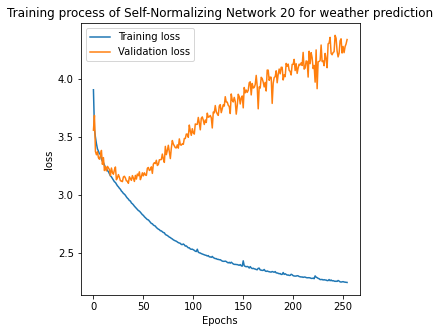

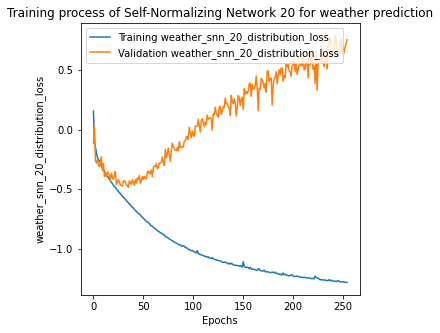

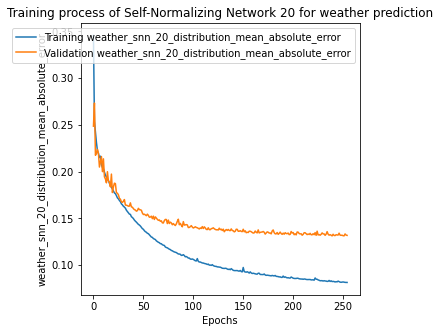


Test quality:
  mean absolute error   = 1.2009692387749162
  mean squared error    = 2.8042929586912164
  median absolute error = 0.8807481941573965
  r2 score              = 0.9736209812031926
  R-AUC MSE             = 0.9222826933786749


In [42]:
for train_index, test_index in splits:
    model_name = f'weather_snn_{len(deep_ensemble) + 1}'
    serialization_name = os.path.join(model_dir, model_name + '.h5')
    regression_output_name = f'{model_name}_distribution'
    projection_output_name = f'{model_name}_projection'
    printable_name = f'Self-Normalizing Network ' \
                     f'{len(deep_ensemble) + 1} for weather prediction'
    print('========================================')
    print(' ' + printable_name)
    print('========================================')
    print('')
    new_postprocessing_scaler = StandardScaler().fit(
        y_train[train_index].reshape((len(train_index), 1))
    )
    X_train_ = X_train[train_index].astype(np.float32)
    y_train_ = new_postprocessing_scaler.transform(
        y_train[train_index].reshape((len(train_index), 1))
    ).flatten().astype(np.float32)
    y_train_class_ = y_train_class[train_index]
    X_val_ = X_train[test_index].astype(np.float32)
    y_val_ = y_train[test_index]
    y_val_class_ = y_train_class[test_index]
    y_val_scaled_ = new_postprocessing_scaler.transform(
        y_val_.reshape((len(test_index), 1))
    ).flatten().astype(np.float32)
    steps_per_epoch = X_train_.shape[0] // BATCH_SIZE
    postprocessing_scalers.append(new_postprocessing_scaler)
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (
            X_train_,
            (
                y_train_,
                y_train_class_
            )
        )
    ).repeat().shuffle(1000000).batch(BATCH_SIZE)
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (
            X_val_,
            (
                y_val_scaled_,
                y_val_class_
            )
        )
    ).batch(BATCH_SIZE)
    del X_train_, y_train_, y_val_scaled_, y_train_class_, y_val_class_
    new_model = build_neural_network(
        input_size=num_features,
        layer_size=BEST_LAYER_SIZE,
        n_layers=best_hyperparams[0],
        dropout_rate=best_hyperparams[1],
        scale_coeff=new_postprocessing_scaler.scale_[0],
        nn_name=model_name
    )
    new_model.summary()
    print('')
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor=f'val_{regression_output_name}_mean_absolute_error',
            restore_best_weights=True,
            patience=PATIENCE, verbose=True
        )
    ]
    model_history = new_model.fit(
        train_dataset, epochs=MAX_EPOCHS, steps_per_epoch=steps_per_epoch,
        callbacks=callbacks, validation_data=val_dataset, verbose=1
    )
    new_model.save_weights(serialization_name, overwrite=True, save_format='h5')
    del train_dataset, val_dataset
    print('')
    show_training_process(history=model_history, metric_name='loss',
                          figure_id=new_figure_id, comment=printable_name)
    new_figure_id += 1
    show_training_process(history=model_history,
                          metric_name=f'{regression_output_name}_loss',
                          figure_id=new_figure_id, comment=printable_name)
    new_figure_id += 1
    show_training_process(history=model_history,
                          metric_name=f'{regression_output_name}_mean_absolute_error',
                          figure_id=new_figure_id, comment=printable_name)
    new_figure_id += 1
    del model_history, callbacks
    print('')
    deep_ensemble.append(new_model)
    instant_res = predict_with_single_nn(X_val_, new_model, BATCH_SIZE,
                                         output_scaler=new_postprocessing_scaler)
    y_pred_mean = instant_res[0]
    y_pred_var = instant_res[1]
    rauc_mse_score = evaluate_single_nn(y_pred_mean, y_pred_var, y_val_)
    print('Test quality:')
    print(f'  mean absolute error   = {mean_absolute_error(y_val_, y_pred_mean)}')
    print(f'  mean squared error    = {mean_squared_error(y_val_, y_pred_mean)}')
    print(f'  median absolute error = {median_absolute_error(y_val_, y_pred_mean)}')
    print(f'  r2 score              = {r2_score(y_val_, y_pred_mean)}')
    print(f'  R-AUC MSE             = {rauc_mse_score}')
    del X_val_, y_val_
    del new_model

In [43]:
config_name = os.path.join(model_dir, 'weather_snn_config.json')
best_hyperparams_for_saving = {
    'input_size': num_features,
    'ensemble_size': len(splits),
    'layer_size': BEST_LAYER_SIZE,
    'n_layers': best_hyperparams[0],
    'alpha_dropout_rate': best_hyperparams[1]
}
with codecs.open(config_name, mode='w', encoding='utf-8') as fp:
    json.dump(best_hyperparams_for_saving, fp, ensure_ascii=False, indent=4)

In [44]:
preprocessing_name = os.path.join(model_dir, 'preprocessing_pipeline.pkl')
with open(preprocessing_name, 'wb') as fp:
    pickle.dump(common_preprocessor, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
postprocessing_name = os.path.join(model_dir, 'postprocessing_scalers.pkl')
with open(postprocessing_name, 'wb') as fp:
    pickle.dump(postprocessing_scalers, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
df_in = pd.read_csv(dev_in_name)
print(f'Row number is {df_in.shape[0]}.')
print(f'Column number is {df_in.shape[1]}.')

Row number is 50000.
Column number is 129.


In [47]:
df_in.head()

fact_time  fact_latitude  fact_longitude  fact_temperature  \
0  1539162000     -40.350000       -9.880000              11.0   
1  1545006600      53.421299       -6.270070               4.0   
2  1540094400     -19.757700       63.361000              26.0   
3  1552611600      35.245899       47.009201               5.0   
4  1545631200      26.633333      118.150000              14.0   

   fact_cwsm_class         climate  topography_bathymetry  sun_elevation  \
0               10        tropical                 -843.0      31.782490   
1               10  mild temperate                   67.0     -59.691521   
2               10             dry                    6.0      35.250889   
3               10  mild temperate                 1390.0     -23.755615   
4               20  mild temperate                  210.0      33.040438   

   climate_temperature  climate_pressure  ...  cmc_0_1_66_0_grad  \
0            10.070714        765.631228  ...            0.00000   
1             7.005000        752.897615  ...            0.00000   
2            23.327143        763.115016  ...            0.00000   
3             3.109286        609.419333  ...            1.69672   
4            12.172143        734.678037  ...            0.00000   

   cmc_0_1_66_0_next  cmc_0_1_67_0_grad  cmc_0_1_67_0_next  cmc_0_1_68_0_grad  \
0             0.0000                0.0           0.000000                0.0   
1             0.0000                0.0           0.000000                0.0   
2             0.0000                0.0           0.000000                0.0   
3             5.1653                0.0           0.000049                0.0   
4             0.0000                0.0           0.000000                0.0   

   cmc_0_1_68_0_next  gfs_2m_dewpoint_grad  gfs_2m_dewpoint_next  \
0                0.0              0.505035              2.647577   
1                0.0             -0.400024              1.249994   
2                0.0              0.100006             21.050012   
3                0.0             -1.500000             -0.349982   
4                0.0              0.102081             11.513879   

   gfs_total_clouds_cover_low_grad  gfs_total_clouds_cover_low_next  
0                              2.0                              2.0  
1                              0.0                              0.0  
2                             -1.0                              1.0  
3                            -12.0                             81.0  
4                            -15.0                             83.0  

[5 rows x 129 columns]

In [48]:
df_out = pd.read_csv(dev_out_name)
print(f'Row number is {df_out.shape[0]}.')
print(f'Column number is {df_out.shape[1]}.')

Row number is 50000.
Column number is 129.


In [49]:
df_out.head()

fact_time  fact_latitude  fact_longitude  fact_temperature  \
0  1563124500      42.614899      -89.590401              28.0   
1  1565951400      61.885201       34.154701              18.0   
2  1563850200      38.468201       43.332298              17.0   
3  1562806380      38.791000      -97.652199              28.0   
4  1564509600      58.767200     -111.116997              20.0   

   fact_cwsm_class climate  topography_bathymetry  sun_elevation  \
0                0    snow                  313.0      65.438862   
1               10    snow                   34.0      40.277528   
2               10    snow                 1652.0      -0.237116   
3                0    snow                  383.0      19.207866   
4               20    snow                  235.0      46.174496   

   climate_temperature  climate_pressure  ...  cmc_0_1_66_0_grad  \
0            19.171429        737.750555  ...                0.0   
1            15.127857        751.846067  ...                0.0   
2            20.117857        609.203551  ...                0.0   
3            33.193571        724.725255  ...                0.0   
4            19.481429        740.954837  ...                0.0   

   cmc_0_1_66_0_next  cmc_0_1_67_0_grad  cmc_0_1_67_0_next  cmc_0_1_68_0_grad  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   cmc_0_1_68_0_next  gfs_2m_dewpoint_grad  gfs_2m_dewpoint_next  \
0                0.0              2.399994             23.450006   
1                0.0             -0.300018              9.449976   
2                0.0              1.849335              3.365320   
3                0.0             -2.486816             16.263177   
4                0.0             -1.200012              7.050012   

   gfs_total_clouds_cover_low_grad  gfs_total_clouds_cover_low_next  
0                             26.0                             71.0  
1                             21.0                             40.0  
2                              0.0                              0.0  
3                              0.0                              0.0  
4                             -1.0                              5.0  

[5 rows x 129 columns]

In [50]:
inputs = np.vstack([
    df_in.iloc[:, 6:].to_numpy().astype(np.float64),
    df_out.iloc[:, 6:].to_numpy().astype(np.float64)
])
targets = np.concatenate([
    df_in['fact_temperature'].to_numpy().astype(np.float64),
    df_out['fact_temperature'].to_numpy().astype(np.float64)
])

In [51]:
all_preds = predict_by_ensemble(
    input_data=inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)

In [52]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [53]:
all_preds_mean = all_preds[:,:,0]
avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))
errors = (avg_preds - targets) ** 2

In [54]:
rejection_mse = calc_uncertainty_regection_curve(errors, uncertainties)
retention_mse = rejection_mse[::-1]
retention_fractions = np.linspace(0, 1, len(retention_mse))

In [55]:
print(f'R-AUC MSE = {np.mean(retention_mse)}.')

R-AUC MSE = 1.0145583822655773.


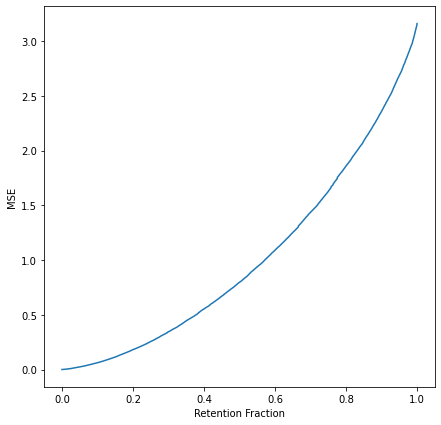

<Figure size 432x288 with 0 Axes>

In [56]:
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
plt.plot(retention_fractions, retention_mse)
plt.ylabel('MSE')
plt.xlabel('Retention Fraction')
plt.show()
plt.clf()

In [57]:
thresh = 1.0
f_auc, f95, retention_f1 = f_beta_metrics(errors, uncertainties, thresh, beta=1.0)
print(f'F1 score at 95% retention: {f95}')
retention_fractions = np.linspace(0, 1, len(retention_f1))

F1 score at 95% retention: 0.6937173838917867


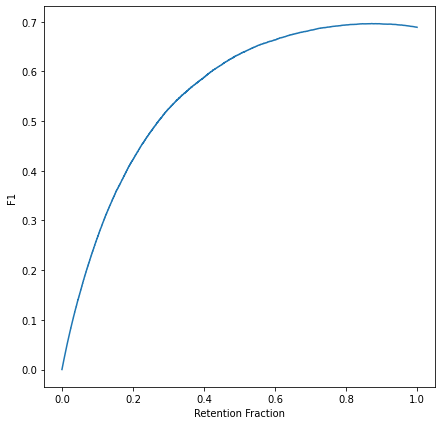

<Figure size 432x288 with 0 Axes>

In [58]:
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
plt.plot(retention_fractions, retention_f1)
plt.ylabel('F1')
plt.xlabel('Retention Fraction')
plt.show()
plt.clf()

In [59]:
ids = np.arange(1, inputs.shape[0] + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})

In [60]:
df_submission.head()

ID       PRED  UNCERTAINTY
0   1  10.438510     0.616079
1   2   4.866150     0.528756
2   3  26.137645     0.645759
3   4   4.418600     2.852260
4   5  13.519255     1.341938

In [61]:
out_file = os.path.join(model_dir, 'df_submission_dev.csv')
df_submission.to_csv(out_file, index=False)

In [62]:
df_eval = pd.read_csv(eval_name)
df_eval.head()

topography_bathymetry  sun_elevation  climate_temperature  \
0                  298.0     -16.337754             7.780000   
1                  376.0      30.120293            22.282143   
2                   83.0       1.232164            14.190000   
3                    5.0     -13.621620             7.946429   
4                  257.0     -20.644158             6.874286   

   climate_pressure  cmc_0_0_0_1000  cmc_0_0_0_2_grad  \
0        742.524856      277.912061         -2.039062   
1        723.331713      292.545093         -0.317285   
2        761.034372      274.791968         -4.542041   
3        764.253037      276.940283         -1.329907   
4        653.700954      285.847852         -0.947852   

   cmc_0_0_0_2_interpolated  cmc_0_0_0_2_next  cmc_0_0_0_2  cmc_0_0_0_500  \
0                275.247046        273.207983   275.247046     256.772266   
1                291.059949        290.954187   291.271472     250.076855   
2                273.794141        272.280127   276.822168     257.556323   
3                277.582633        277.139331   278.469238     257.171875   
4                277.626253        277.310303   278.258154     252.567334   

   ...  cmc_0_1_66_0_grad  cmc_0_1_66_0_next  cmc_0_1_67_0_grad  \
0  ...                0.0                0.0           0.000000   
1  ...                0.0                0.0           0.000000   
2  ...                0.0                0.0           0.000000   
3  ...                0.0                0.0           0.000000   
4  ...                0.0                0.0           0.002677   

   cmc_0_1_67_0_next  cmc_0_1_68_0_grad  cmc_0_1_68_0_next  \
0            0.00000                0.0                0.0   
1            0.00000                0.0                0.0   
2            0.00000                0.0                0.0   
3            0.00000                0.0                0.0   
4            0.00358                0.0                0.0   

   gfs_2m_dewpoint_grad  gfs_2m_dewpoint_next  \
0             -0.558990            -10.608984   
1              2.099976              8.749994   
2              0.100006            -10.349982   
3              0.125946             -2.341925   
4              0.199982              2.350000   

   gfs_total_clouds_cover_low_grad  gfs_total_clouds_cover_low_next  
0                              0.0                              0.0  
1                              0.0                              0.0  
2                              0.0                              0.0  
3                              0.0                              0.0  
4                             26.0                             91.0  

[5 rows x 123 columns]

In [63]:
eval_inputs = df_eval.to_numpy().astype(np.float64)

In [64]:
all_preds = predict_by_ensemble(
    input_data=eval_inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)

In [65]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [66]:
ids = np.arange(1, len(df_eval) + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})
df_submission.head()

ID       PRED  UNCERTAINTY
0   1   2.899179     0.719324
1   2  17.571944     1.277612
2   3   1.696645     0.905027
3   4   2.293385     2.332874
4   5   9.411124     3.744692

In [67]:
out_file = os.path.join(model_dir, 'df_submission.csv')
df_submission.to_csv(out_file, index=False)